In [1]:
using PyPlot
using Parameters
using HDF5

In [2]:
@with_kw struct Param{T1,T2}
    L::T1 = 1.0
    dt::T1 = 0.005
    xmax::T2 = 51
    
    dx::T1 = L/(xmax-1)
    
    nstep::T2 = 2000
    
    nu::T1 = 0.01
    diffuse::T1 = nu*dt/dx^2
    ndata::T2 =5
end

Param

In [33]:
function init(para, x, u)
    @unpack dx, xmax, L = para

    for i=1:xmax
        x[i] = dx*(i-1)
    end

    for i=1:xmax
        u[i] = 0
    end
    for i=21:30
        u[i] = 1.0
    end
end

function step_ud(para, u, utemp)
    @unpack dx, dt, nu, xmax = para

    c1 = 0.5dt/dx
    c2 = nu*dt/dx^2

    for i=2:xmax-1
        utemp[i] = u[i] - c1*u[i]*(u[i+1]-u[i-1]) +
            c1*abs(u[i])*(u[i+1]-2u[i]+u[i-1]) +
            c2*(u[i+1]-2u[i]+u[i-1])
    end

    i = 1
    utemp[i] = u[i] - c1*u[i]*(u[i+1]-u[xmax]) +
            c1*abs(u[i])*(u[i+1]-2u[i]+u[xmax]) +
            c2*(u[i+1]-2u[i]+u[xmax])
    i = xmax
    utemp[i] = u[i] - c1*u[i]*(u[1]-u[i-1]) +
            c1*abs(u[i])*(u[1]-2u[i]+u[i-1]) +
            c2*(u[1]-2u[i]+u[i-1])
    
    for i=1:xmax
        u[i] = utemp[i]
    end
end

function step_kk(para, u, utemp)
    @unpack dx, dt, nu, xmax = para

    c11 = dt/dx/12.0
    c12 = 0.25dt/dx
    c2 = nu*dt/dx^2
    
    for i=3:xmax-2
        utemp[i] = u[i] - c11*u[i]*(-u[i+2] + 8u[i+1] - 8u[i-1] + u[i-2]) -
            c12*abs(u[i])*(u[i+2] - 4u[i+1] + 6u[i] - 4u[i-1] + u[i-2]) +
            c2*(u[i+1]-2u[i]+u[i-1])
    end

    i = 1
    utemp[i] = u[i] - c11*u[i]*(-u[i+2] + 8u[i+1] - 8u[xmax] + u[xmax-1]) -
            c12*abs(u[i])*(u[i+2] - 4u[i+1] + 6u[i] - 4u[xmax] + u[xmax-1]) +
            c2*(u[i+1]-2u[i]+u[xmax])
    i = 2
    utemp[i] = u[i] - c11*u[i]*(-u[i+2] + 8u[i+1] - 8u[i-1] + u[xmax]) -
            c12*abs(u[i])*(u[i+2] - 4u[i+1] + 6u[i] - 4u[i-1] + u[xmax]) +
            c2*(u[i+1]-2u[i]+u[i-1])
    i = xmax
    utemp[i] = u[i] - c11*u[i]*(-u[2] + 8u[1] - 8u[i-1] + u[i-2]) -
            c12*abs(u[i])*(u[2] - 4u[1] + 6u[i] - 4u[i-1] + u[i-2]) +
            c2*(u[1]-2u[i]+u[i-1])
    i= xmax-1
    utemp[i] = u[i] - c11*u[i]*(-u[1] + 8u[i+1] - 8u[i-1] + u[i-2]) -
            c12*abs(u[i])*(u[1] - 4u[i+1] + 6u[i] - 4u[i-1] + u[i-2]) +
            c2*(u[i+1]-2u[i]+u[i-1])
    
    for i=1:xmax
        u[i] = utemp[i]
    end
end

function main(para)
    @unpack nstep, xmax, dt, dx, nu, ndata = para

    x = zeros(xmax)
    u = zeros(xmax)
    utemp = zeros(xmax)

    init(para, x, u)
    
    fig = plt.figure(figsize = (4, 2.5))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, u, marker="o", label="true")
    ax1.set_ylim(-0.5,1.5)
    ax1.set_title("init")
    ax1.set_xlabel("x")
    ax1.set_ylabel("u")
    ax1.legend()
    plt.savefig("Fig/U-init.pdf", )
    
    for n=1:nstep
        #step_ud(para, u, utemp)
        step_kk(para, u, utemp)
        
        if n%ndata == 0
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.plot(x, u, marker="o")
            ax1.set_ylim(-0.5,1.5)
            ax1.set_title("t="*string(n*dt)*", "*string(n))
            output(n, nu, u)
        end
    end
end

main (generic function with 1 method)

In [4]:
function output(n, nu, u)
    
    h5open("data_true/data_true"*string(n)*".h5", "w") do file
        write(file, "nu", nu)
        write(file, "u", u)
    end
end

output (generic function with 1 method)

In [14]:
#para = Param(nu=0.0, dt=0.001, nstep=1000)

para = Param(nu=0.0025, nstep=2000)



Param{Float64, Int64}
  L: Float64 1.0
  dt: Float64 0.005
  xmax: Int64 51
  dx: Float64 0.02
  nstep: Int64 2000
  nu: Float64 0.0025
  diffuse: Float64 0.03125
  ndata: Int64 5


In [15]:
para.nu*para.dt/para.dx^2

0.03125

  8.409315 seconds (247.90 k allocations: 12.791 MiB, 3.81% gc time, 13.07% compilation time)


sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


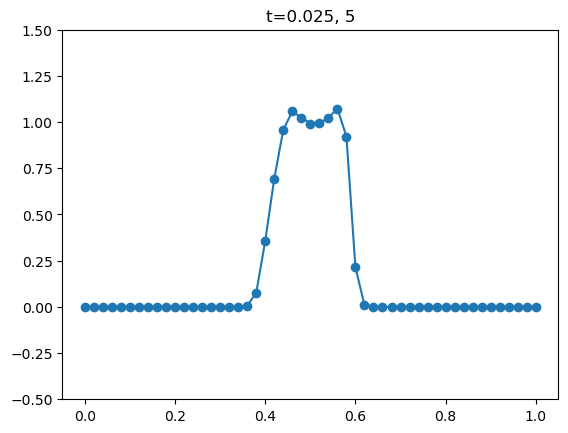

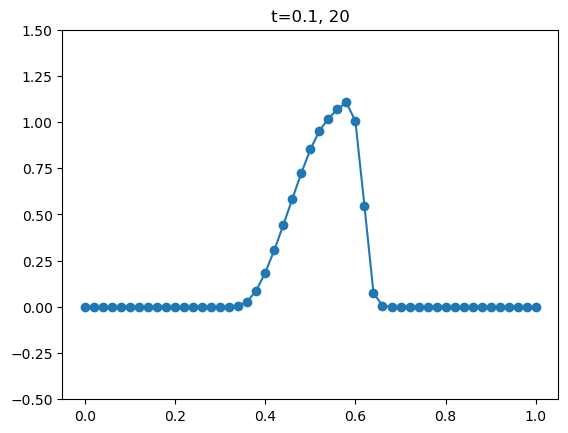

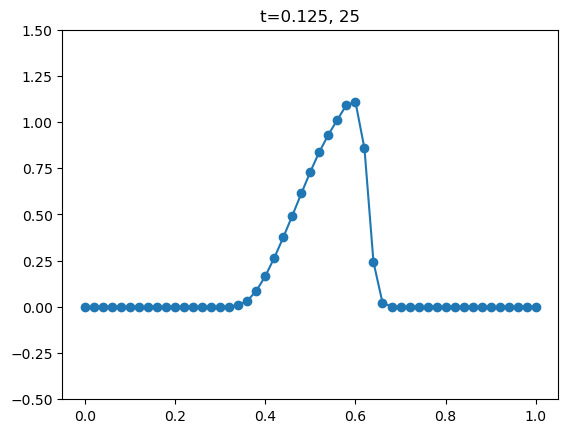

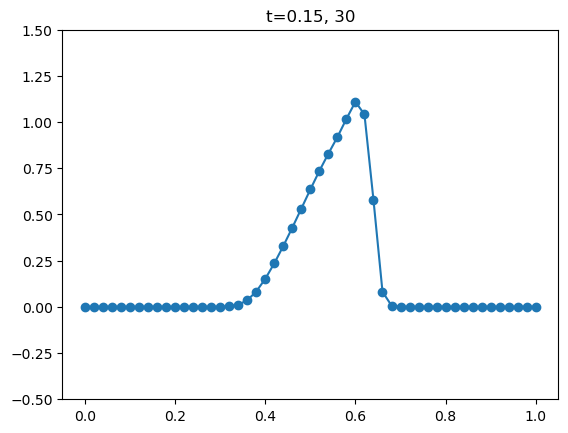

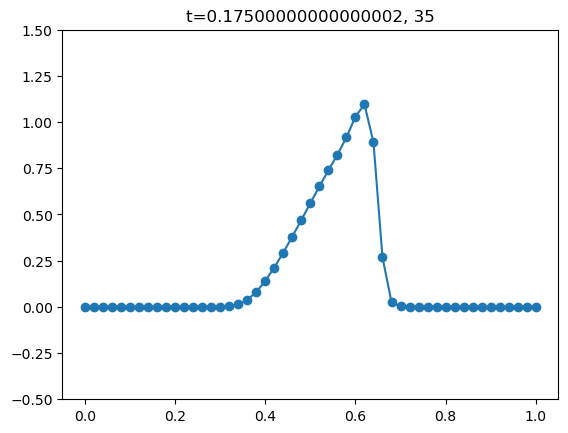

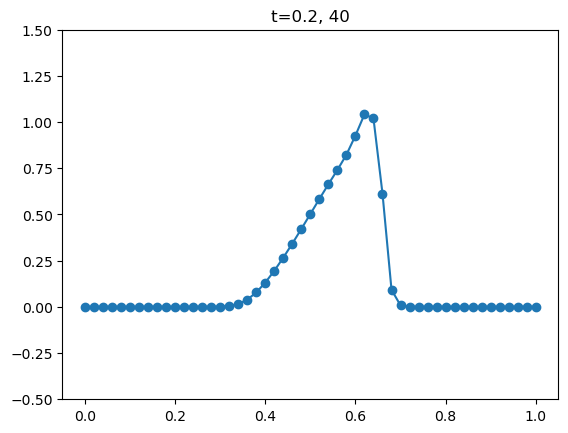

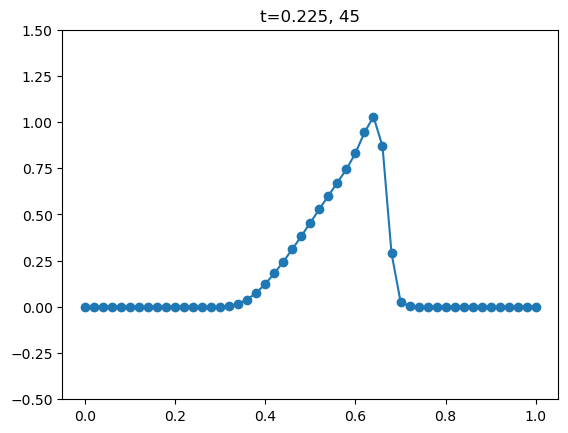

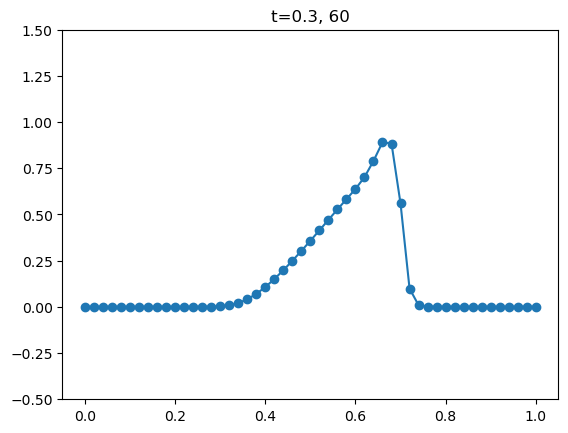

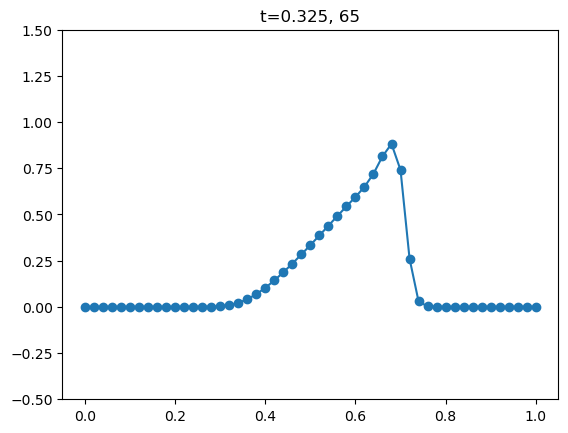

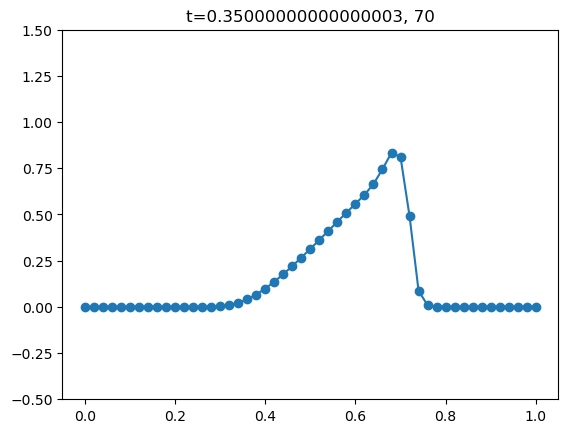

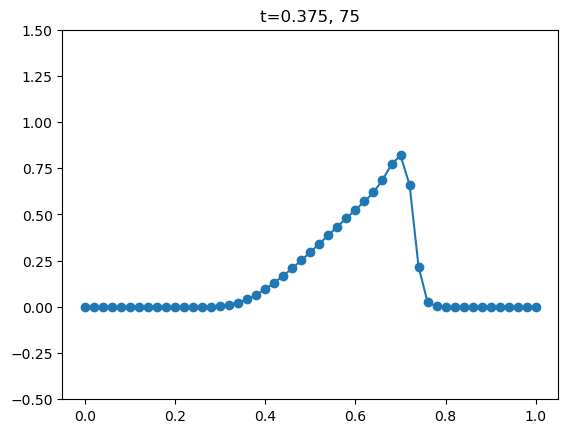

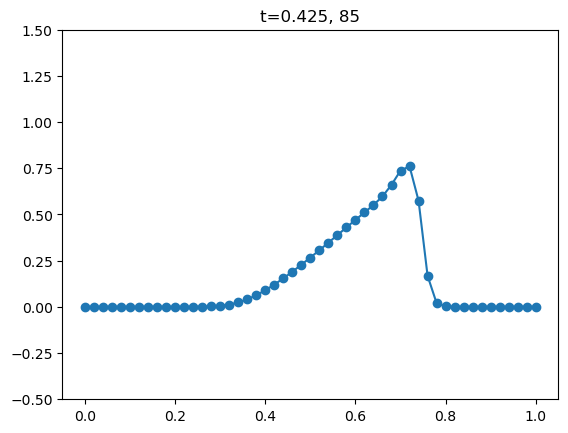

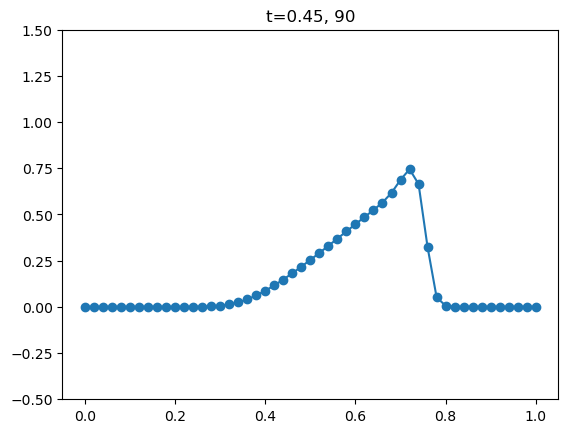

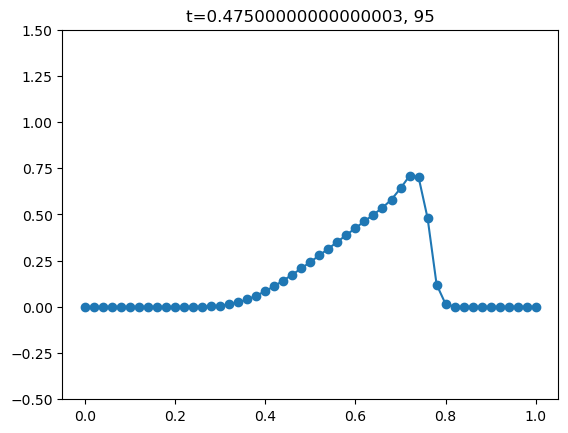

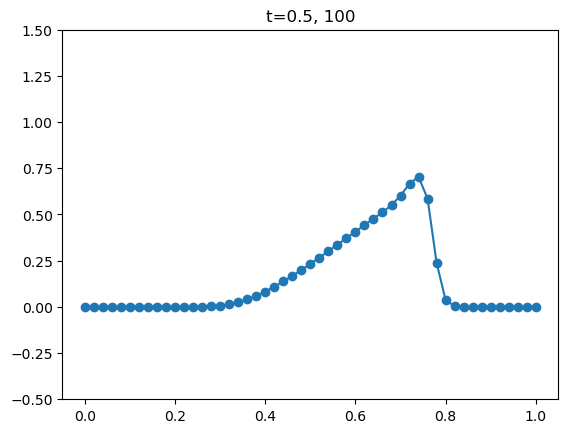

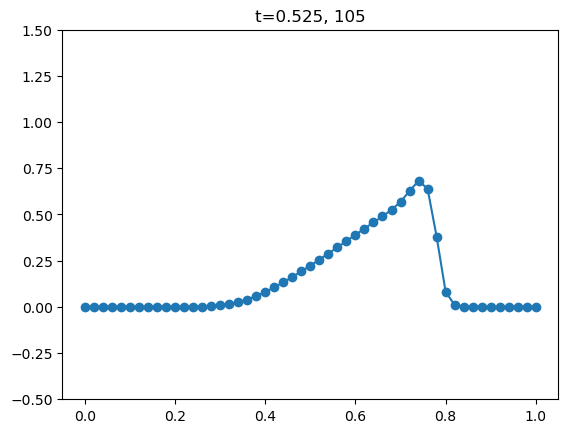

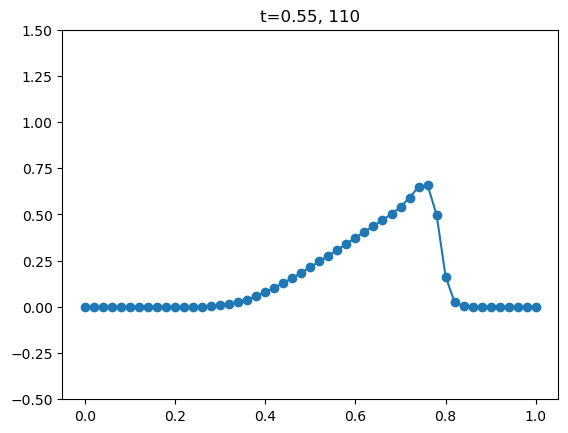

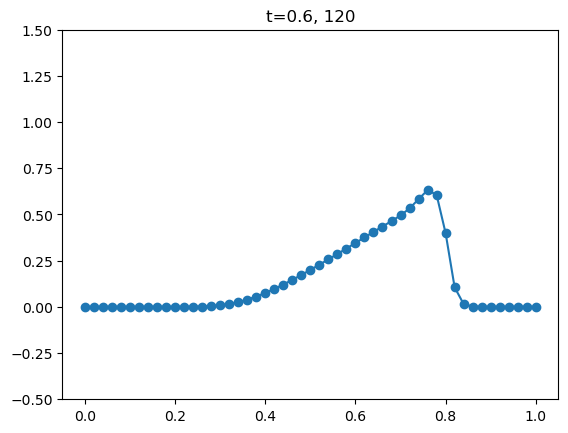

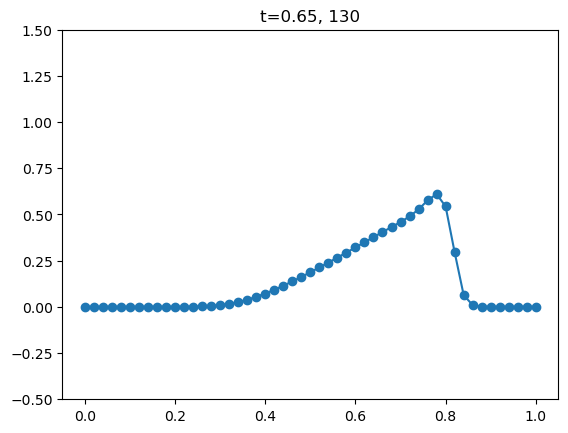

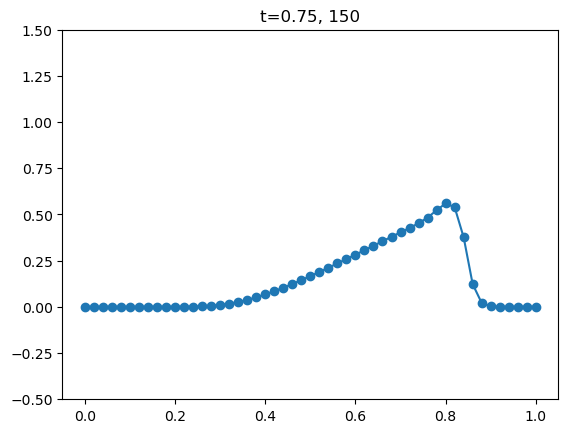

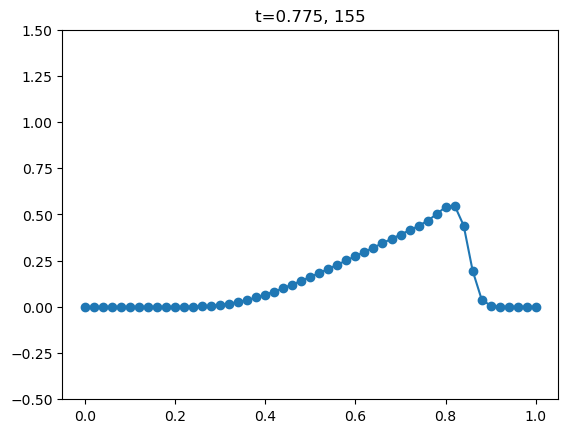

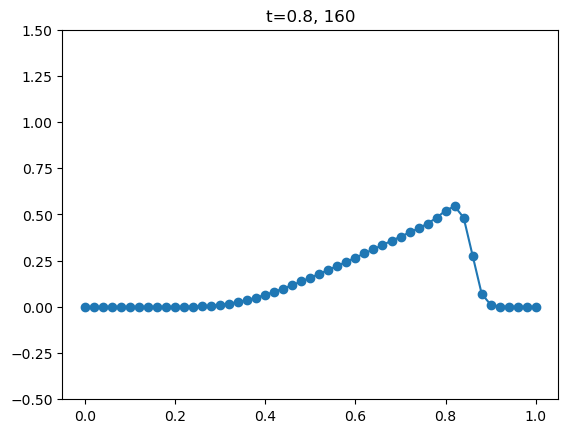

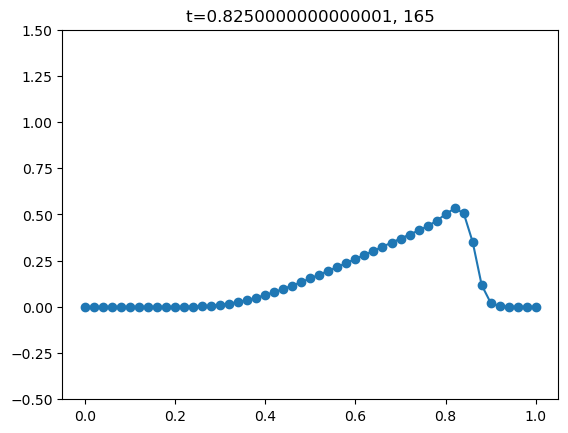

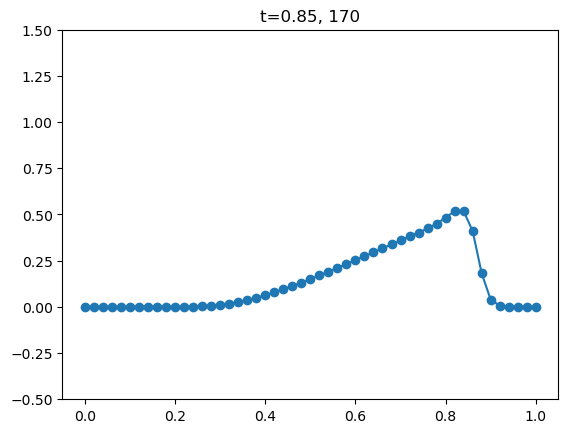

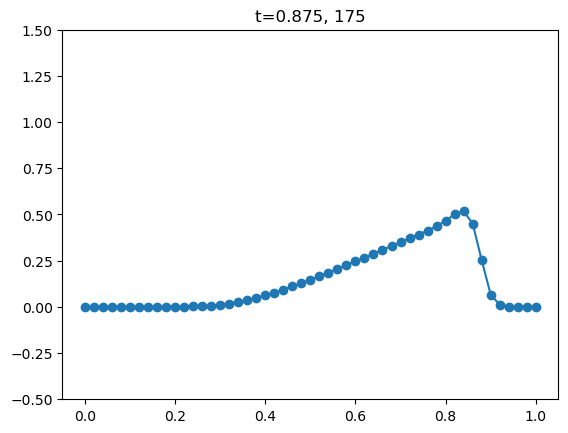

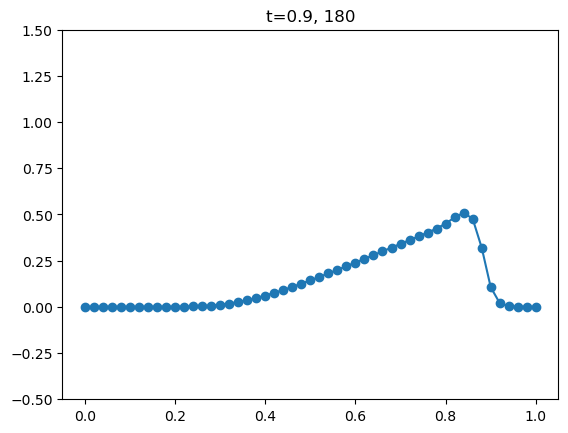

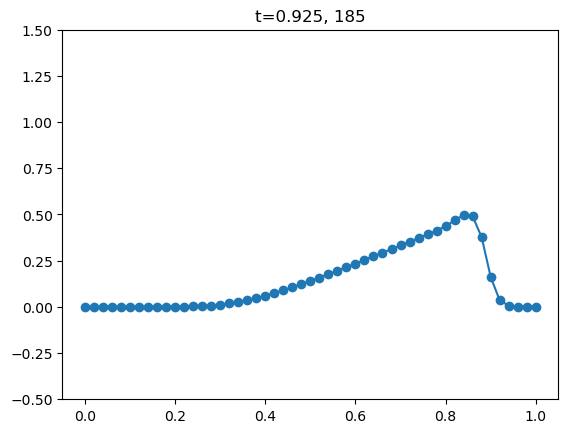

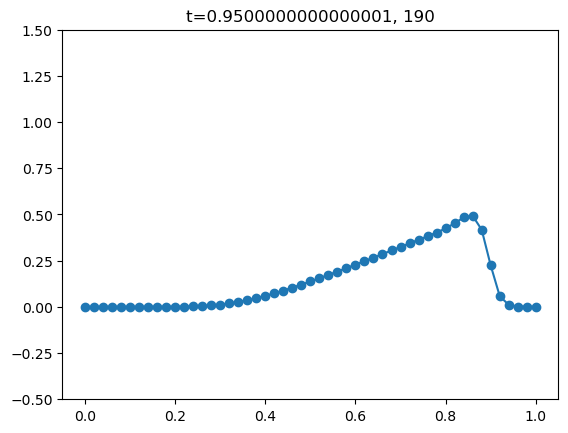

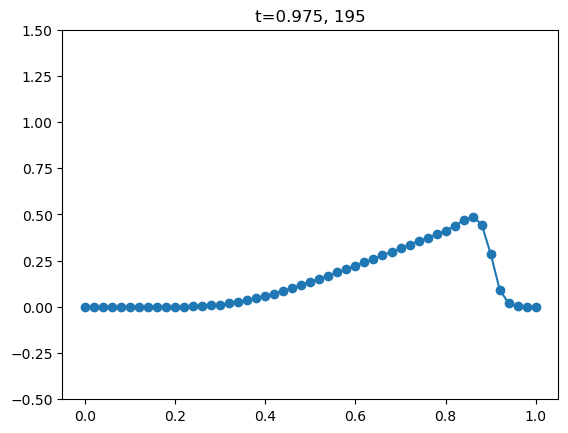

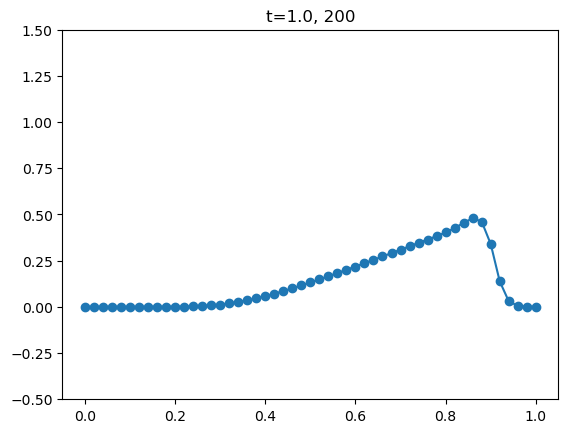

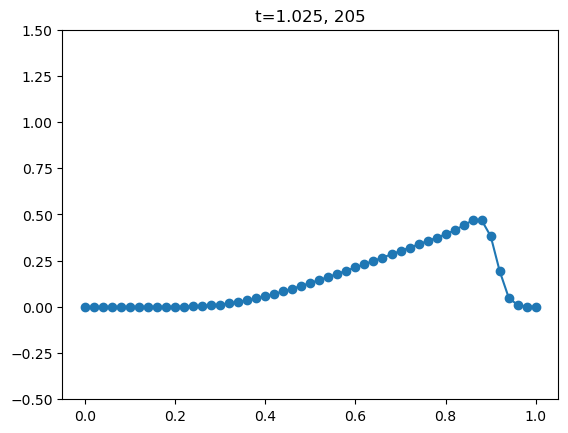

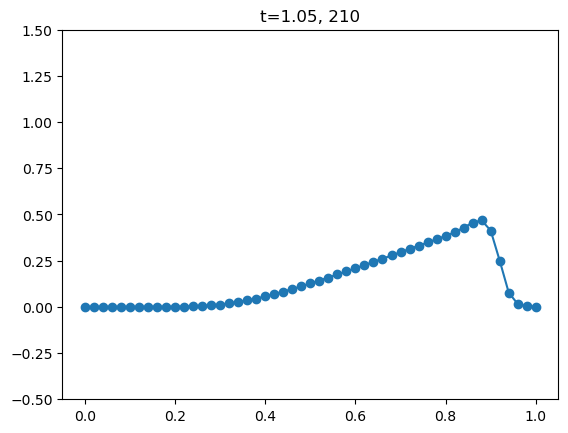

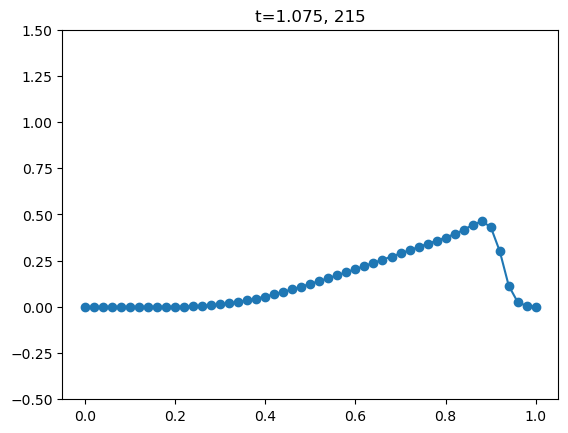

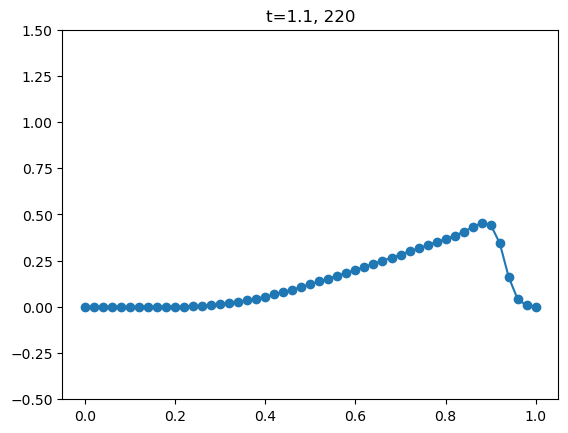

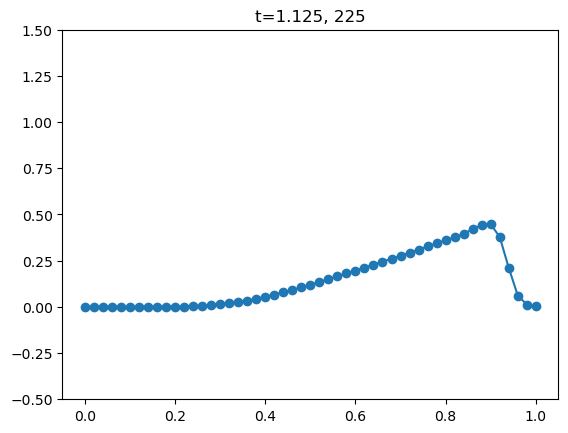

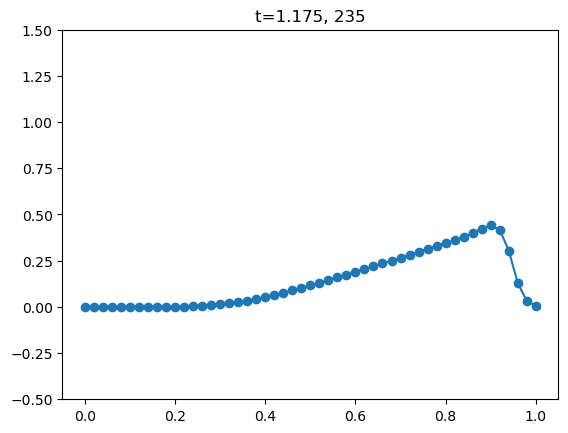

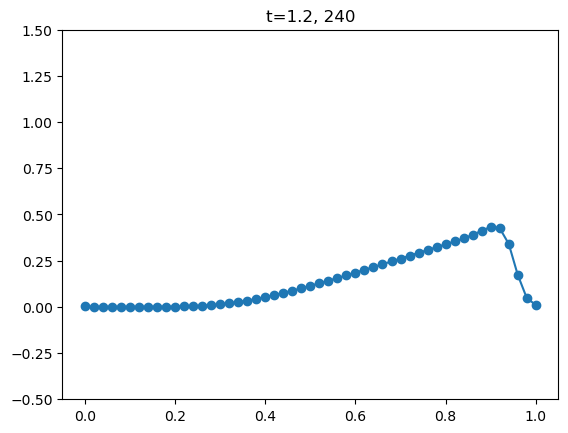

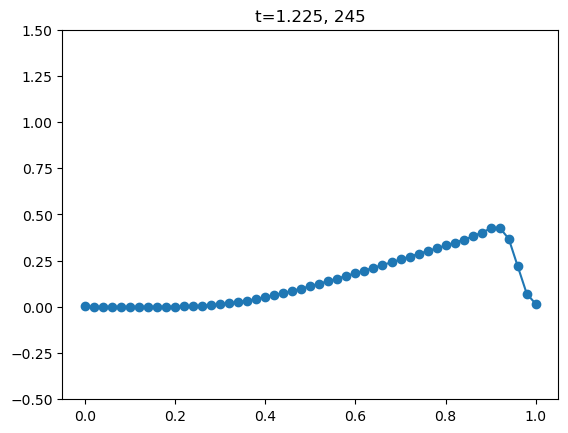

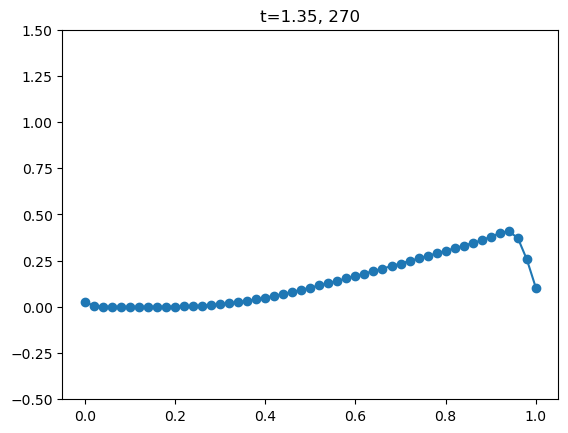

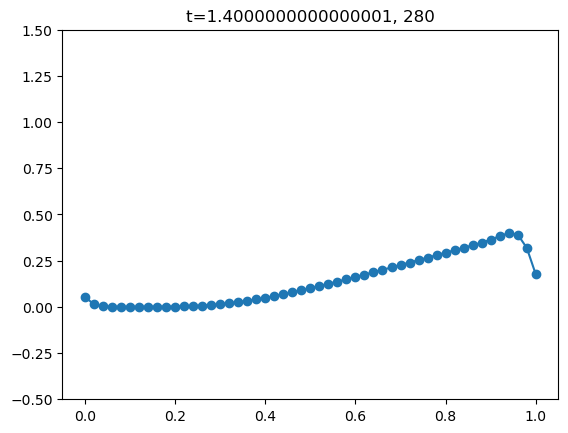

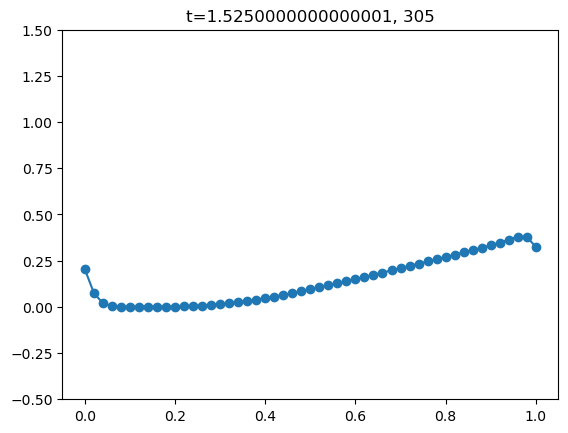

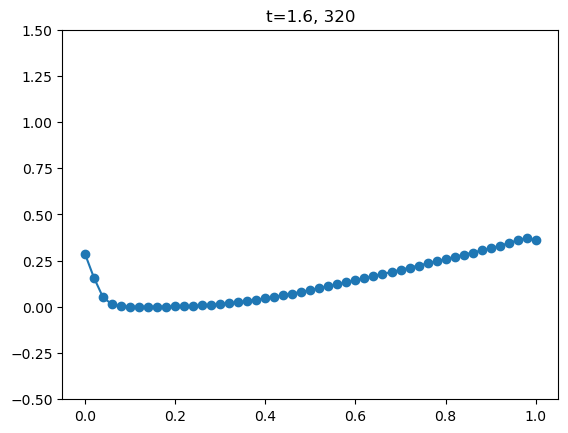

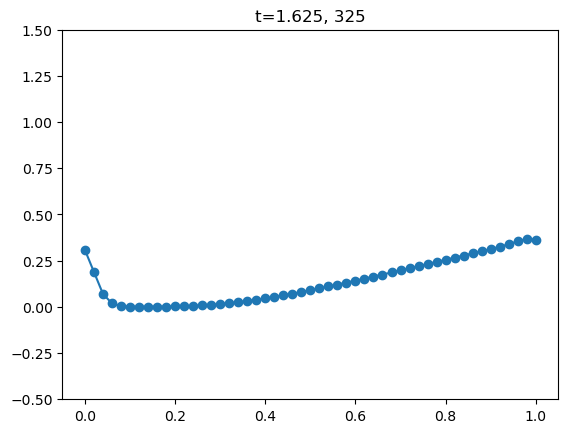

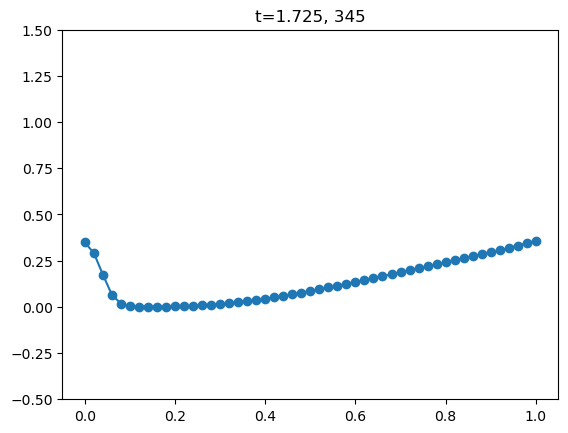

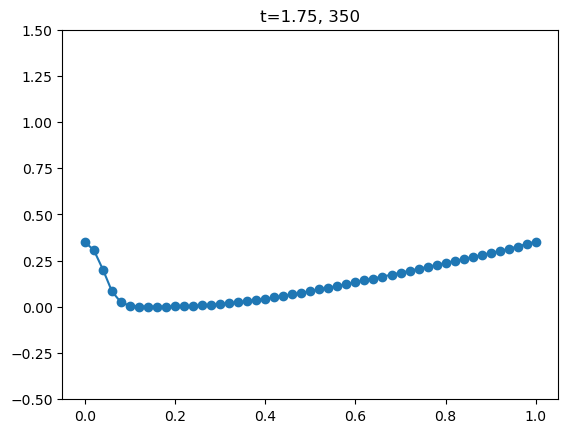

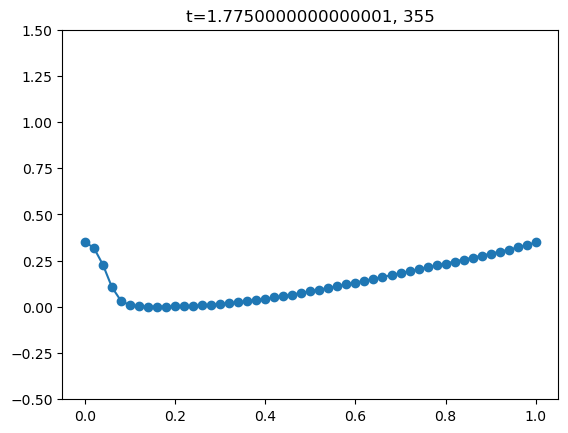

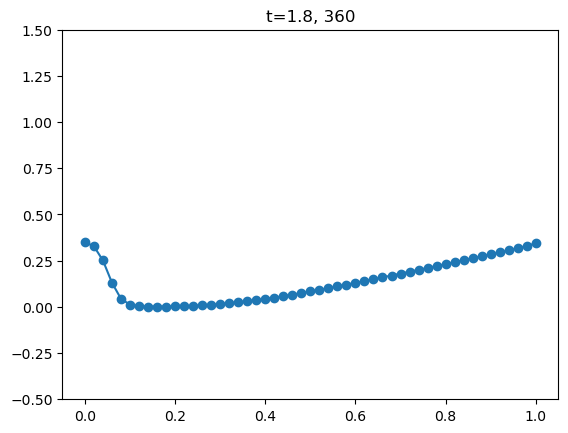

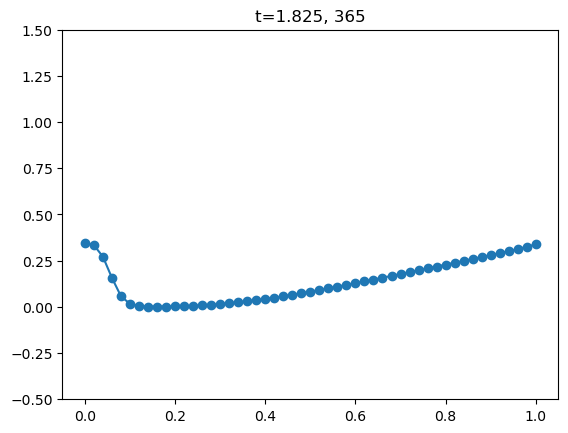

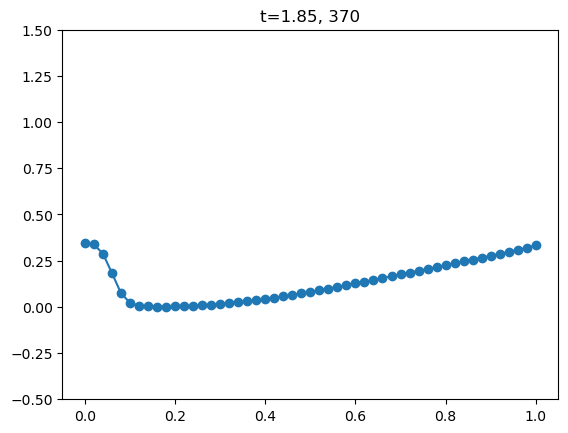

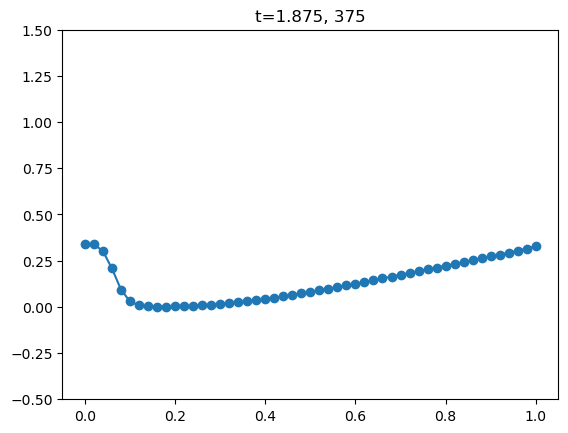

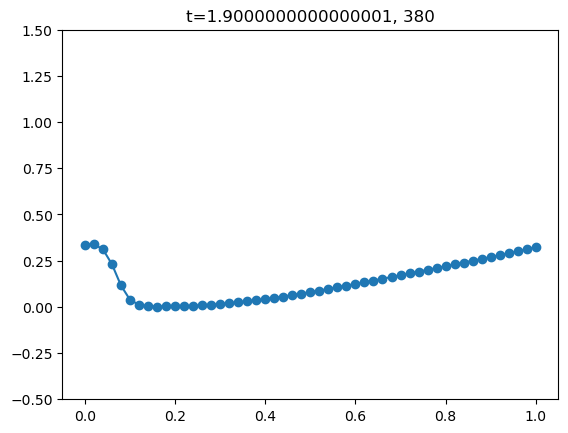

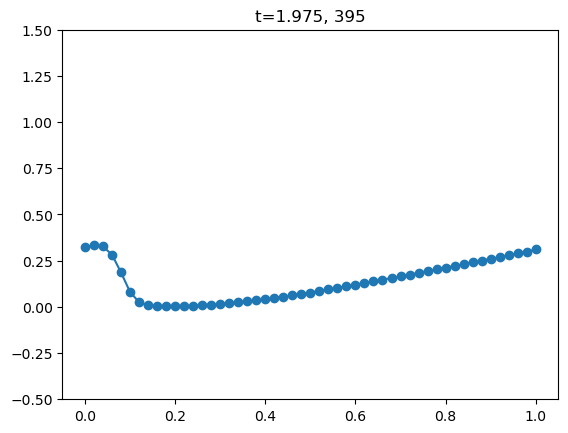

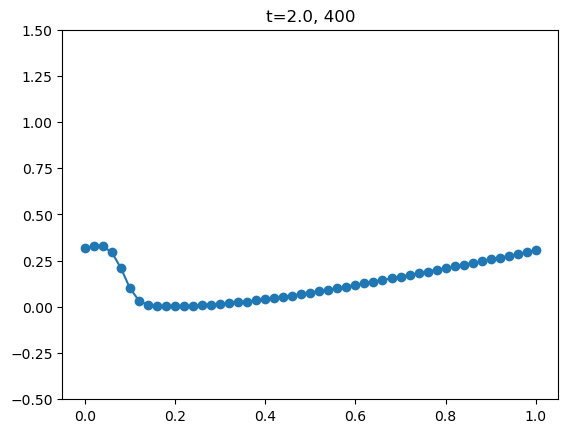

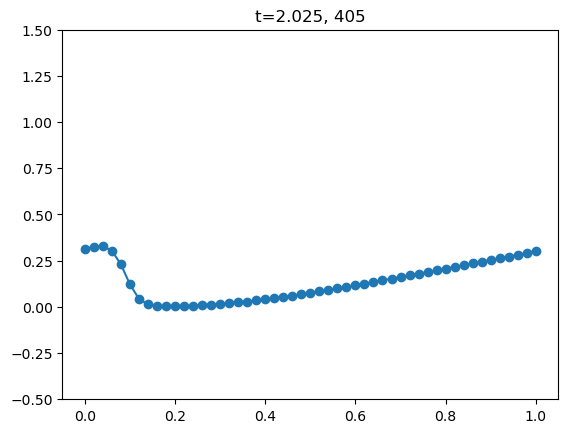

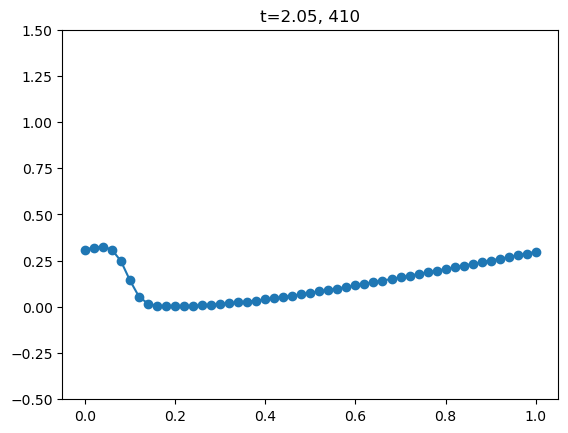

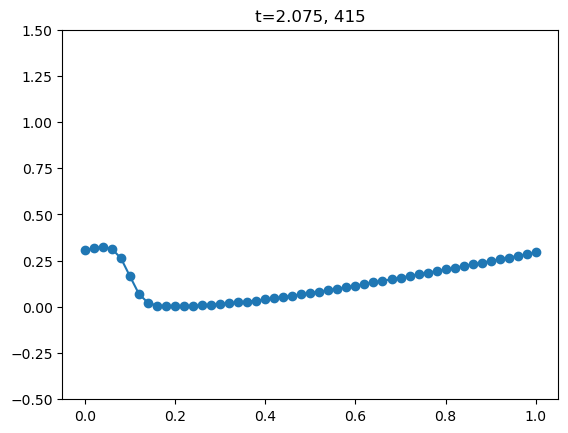

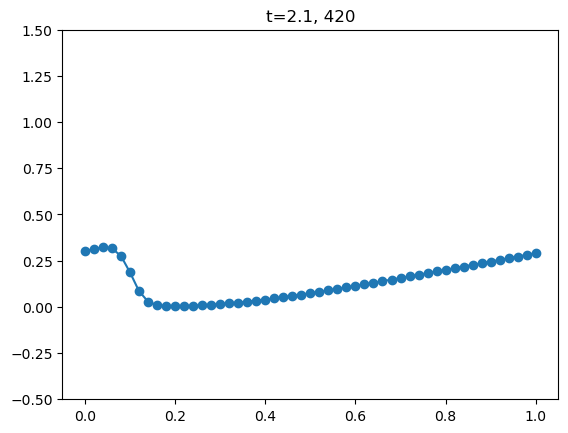

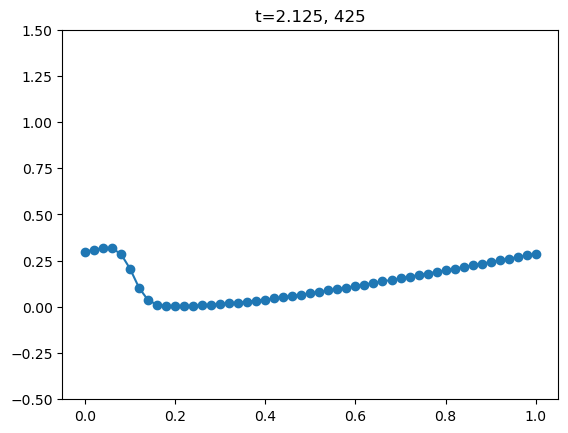

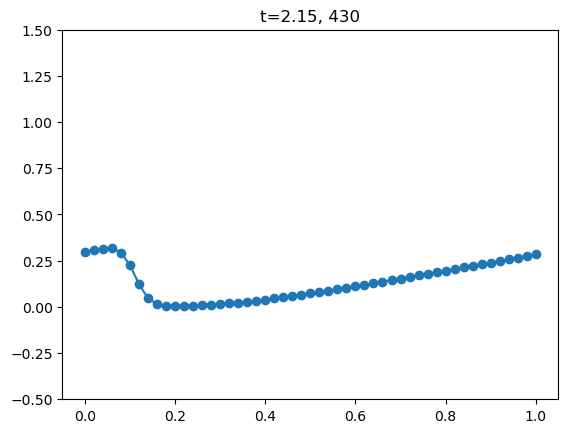

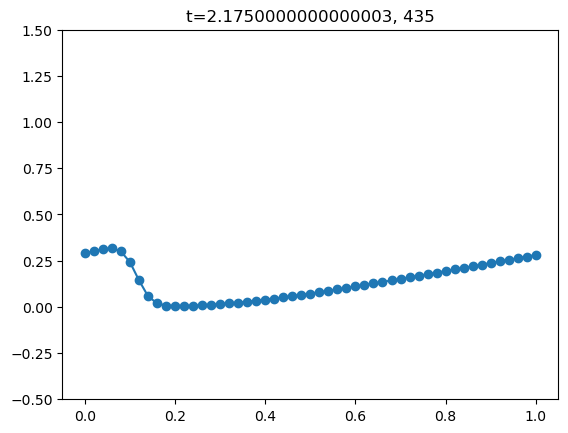

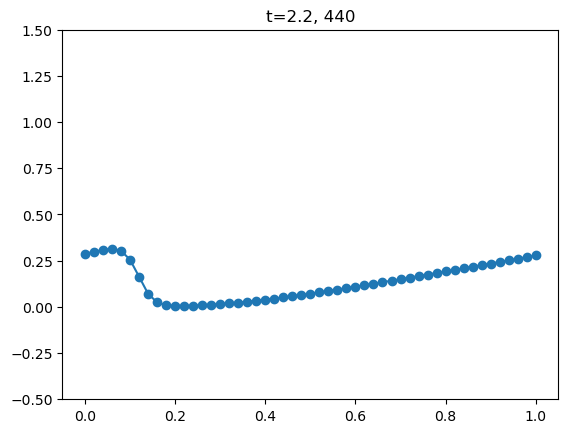

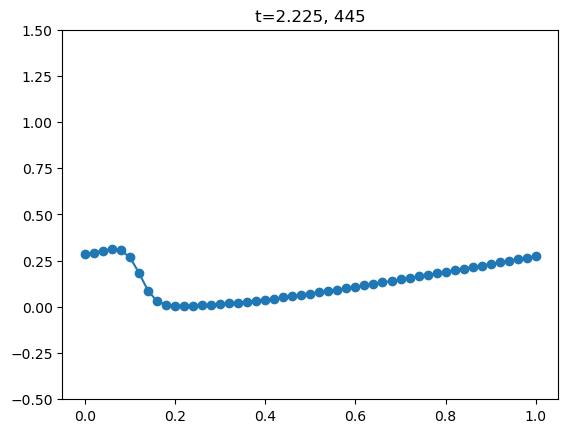

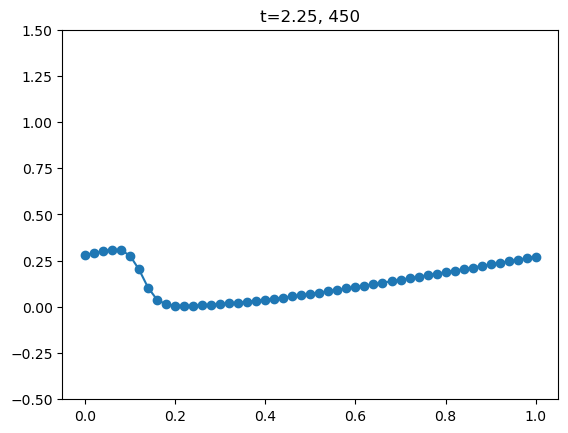

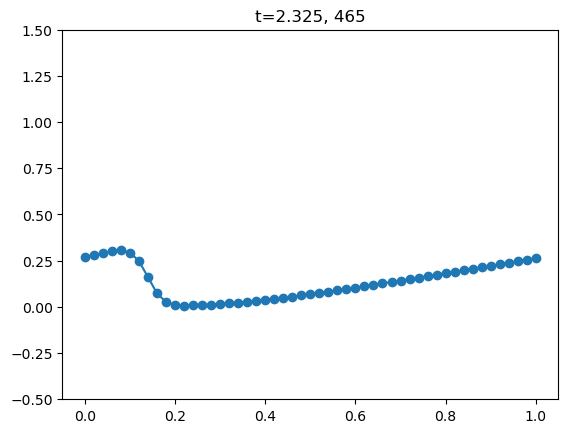

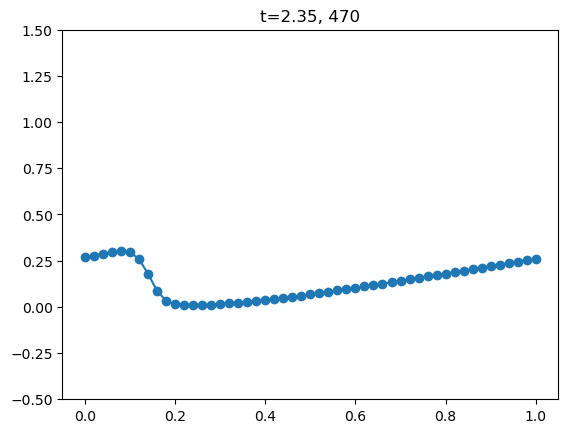

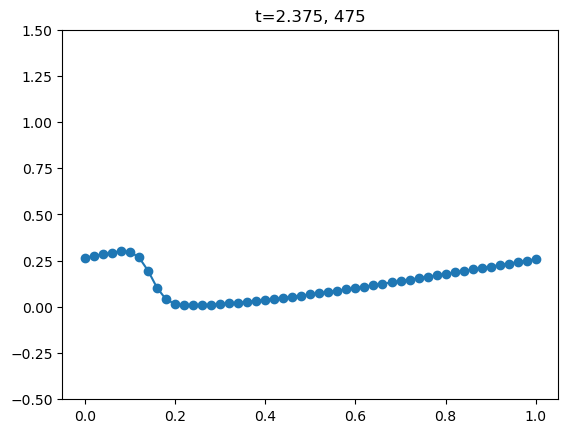

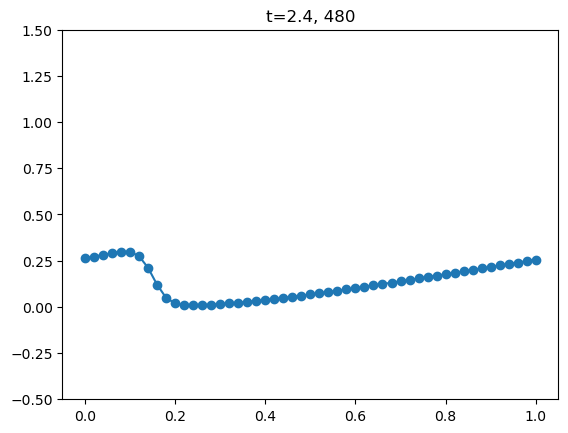

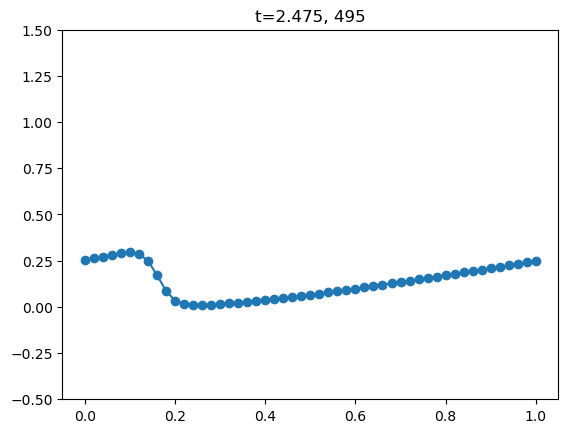

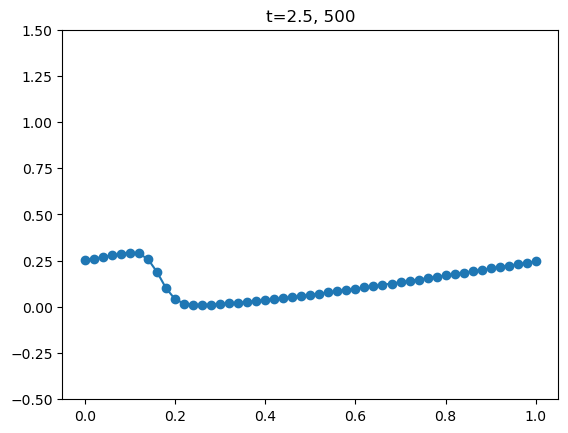

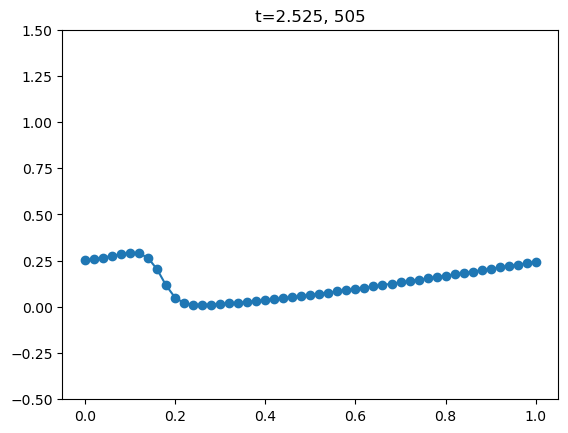

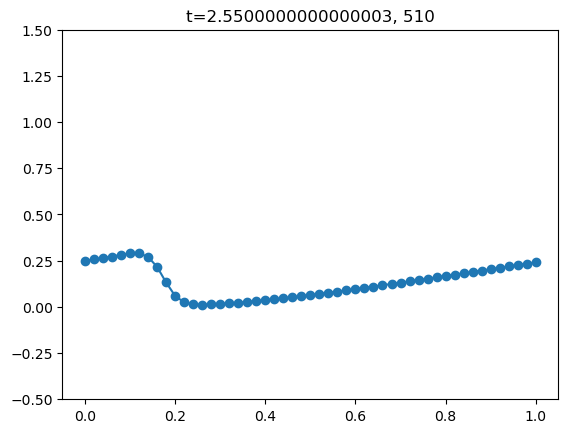

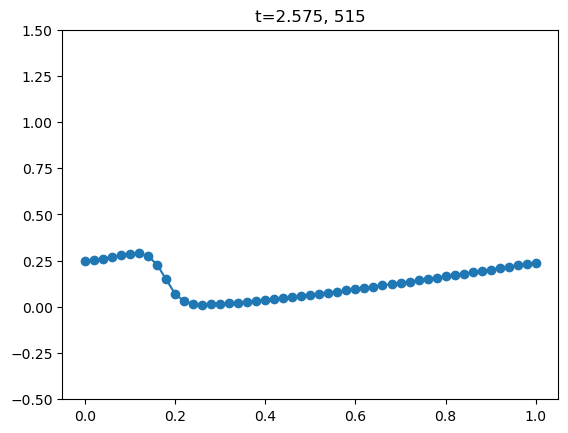

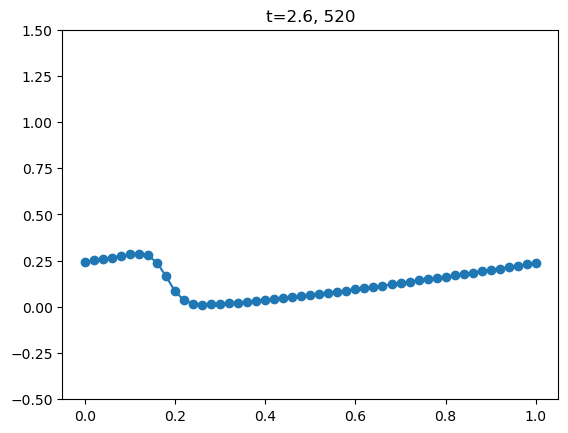

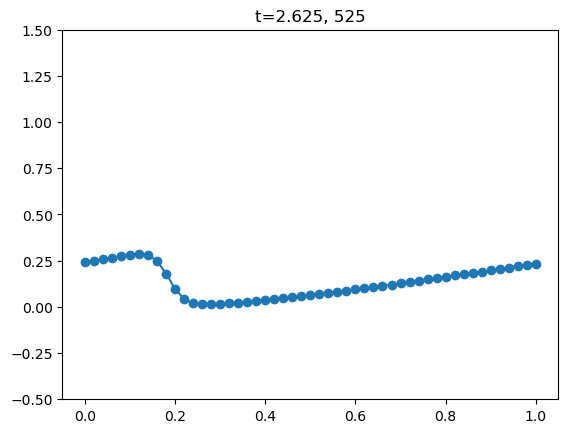

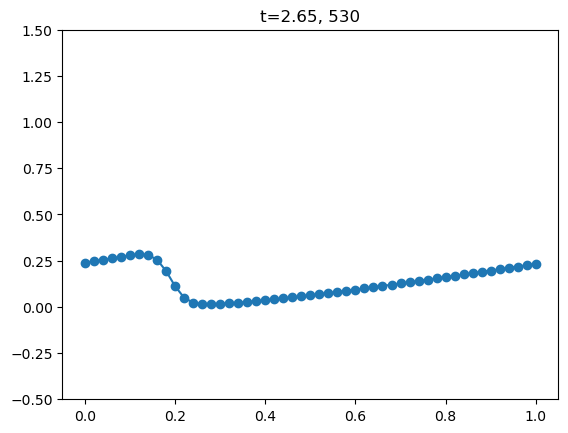

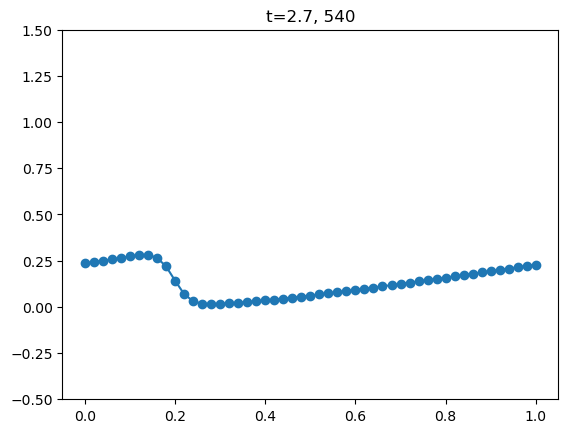

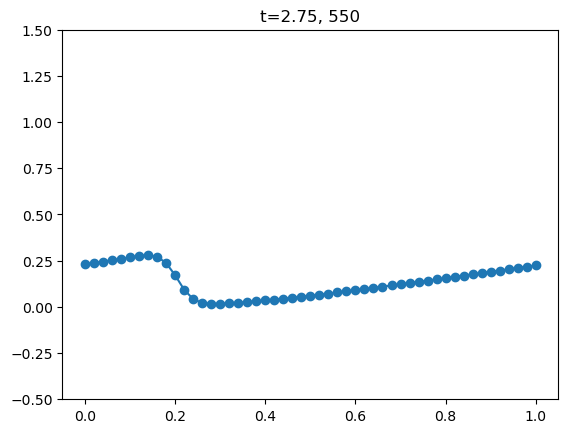

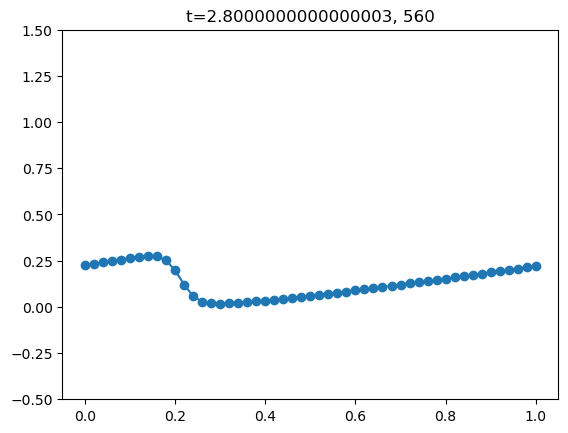

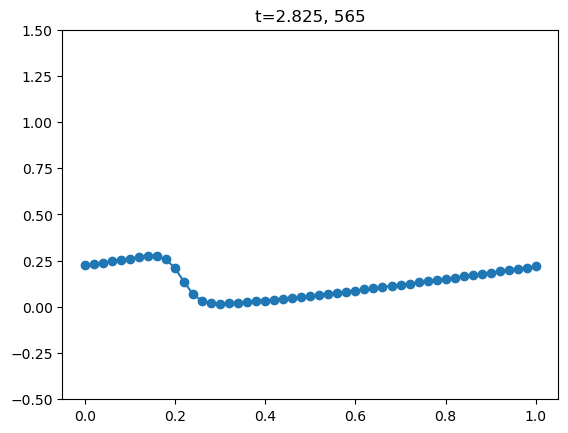

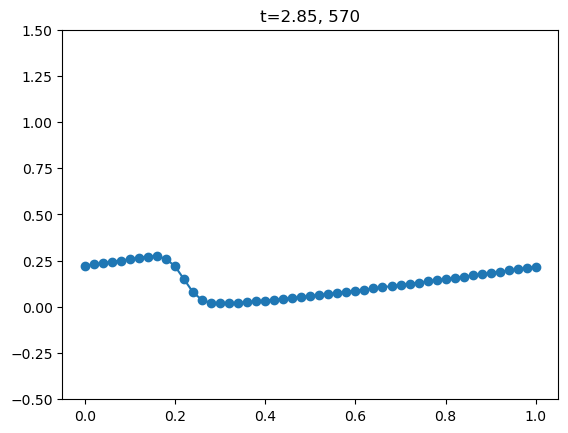

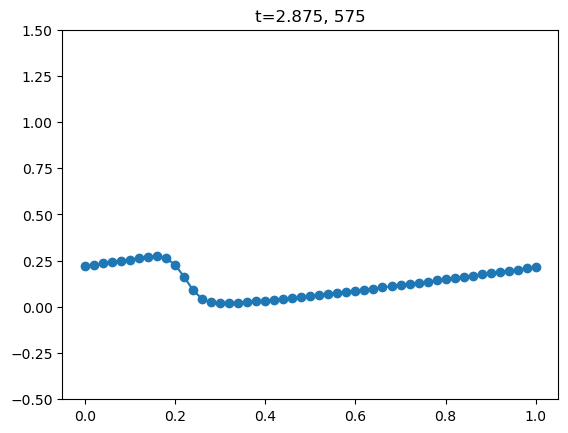

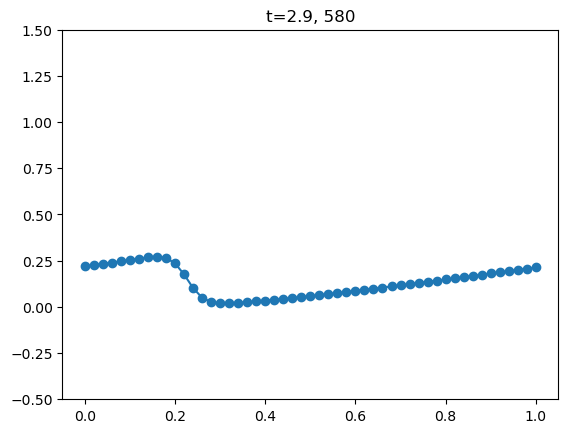

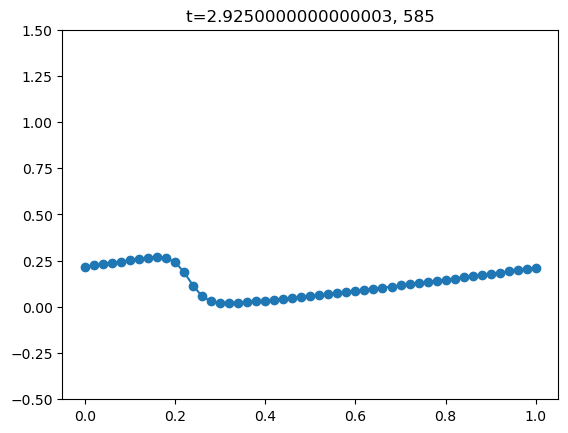

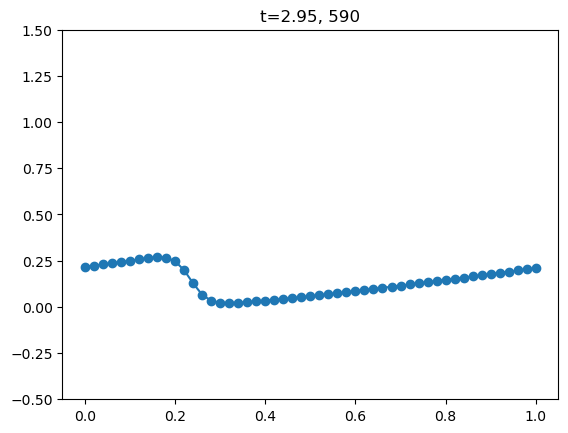

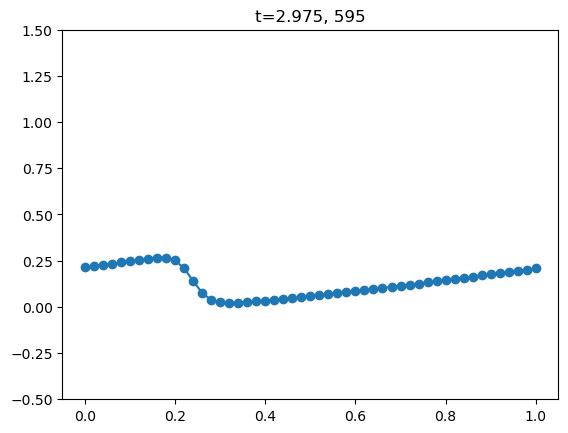

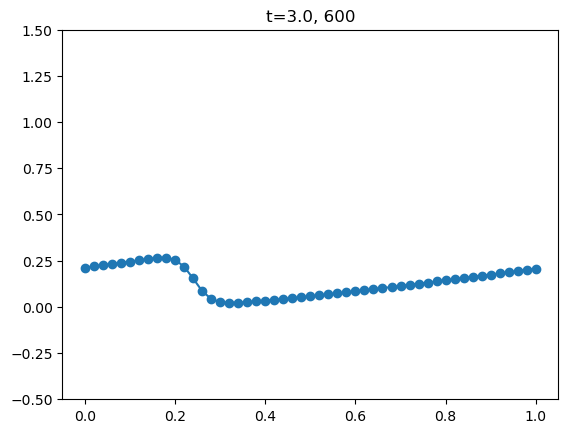

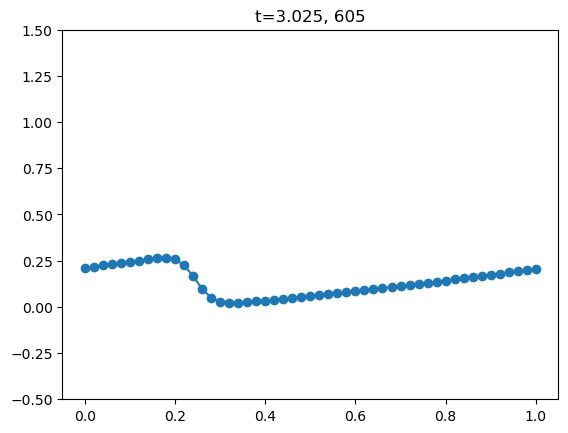

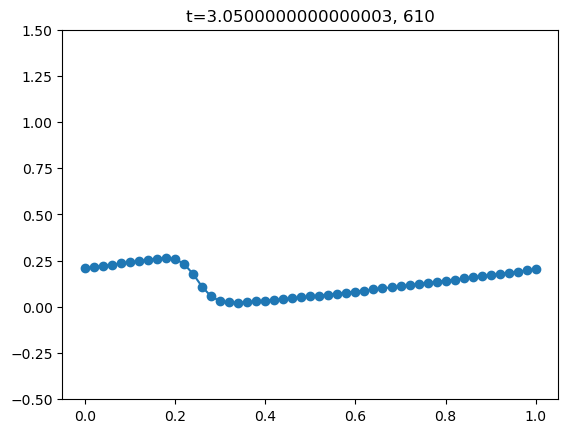

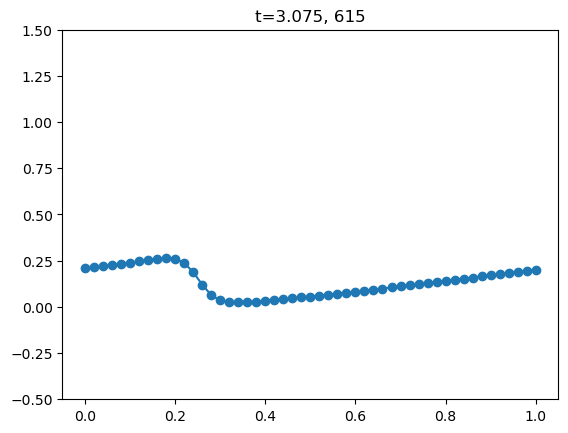

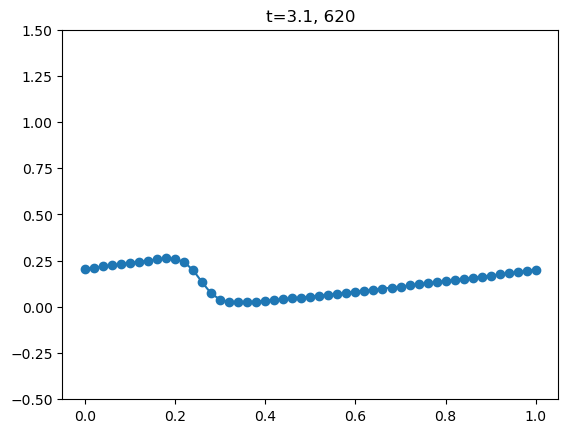

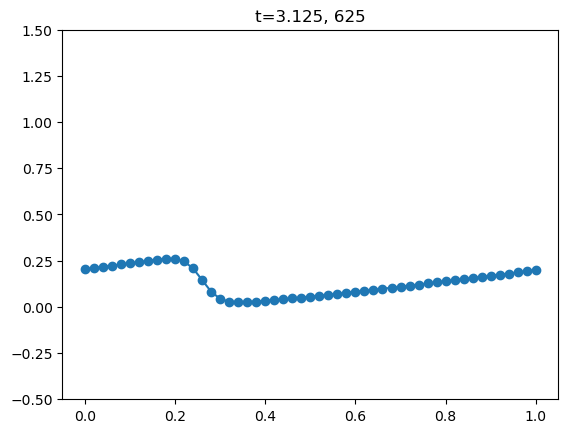

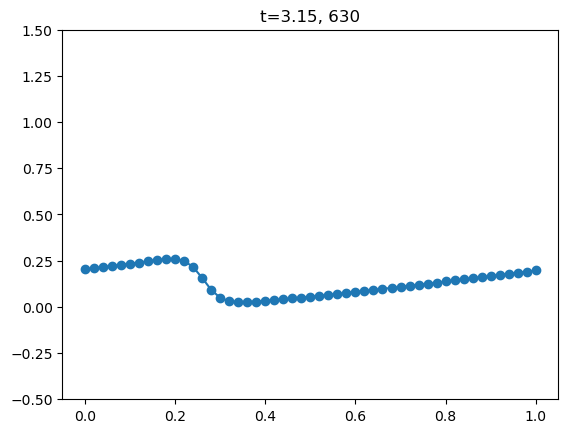

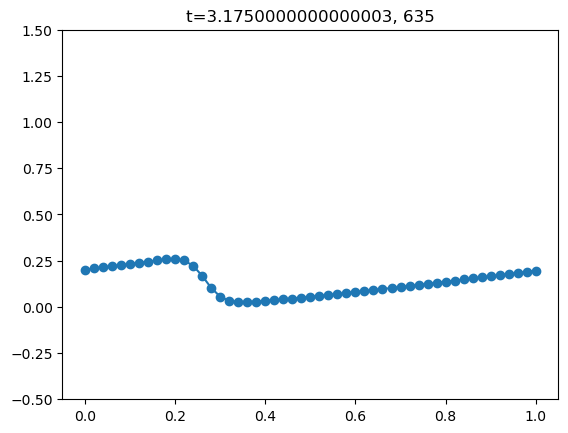

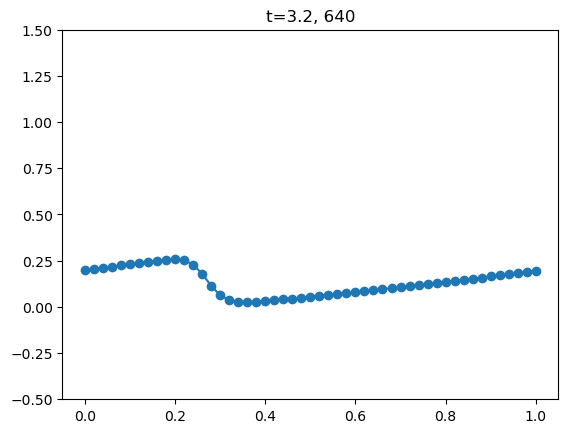

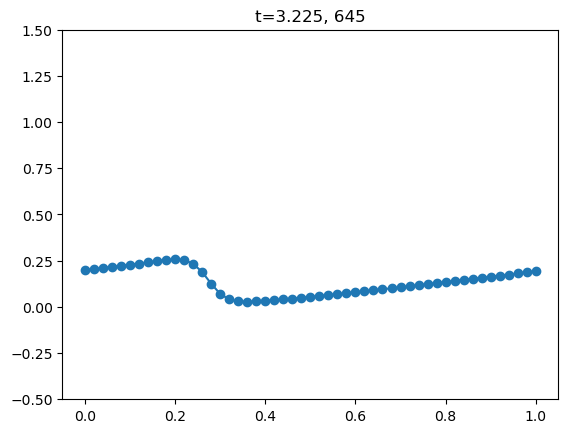

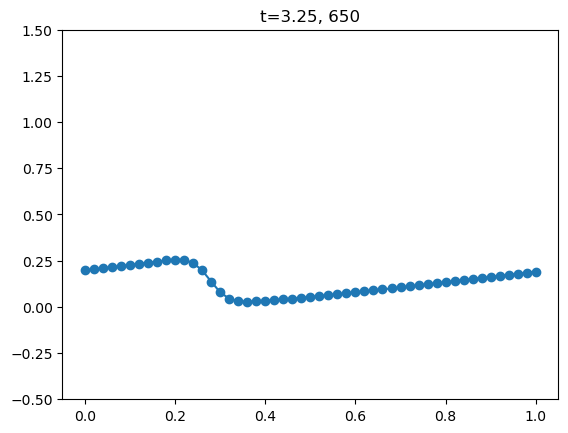

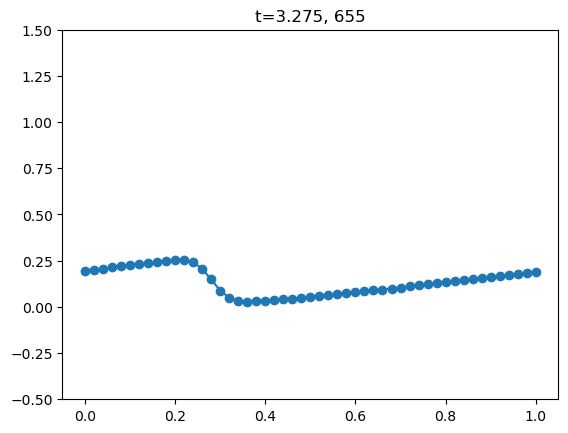

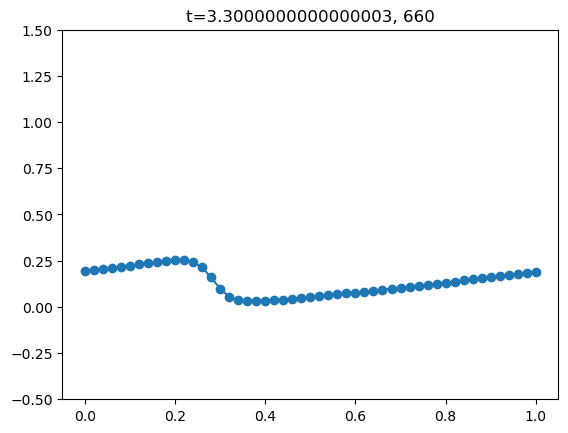

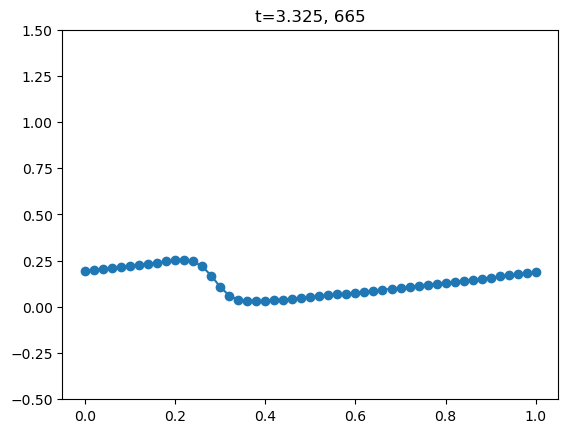

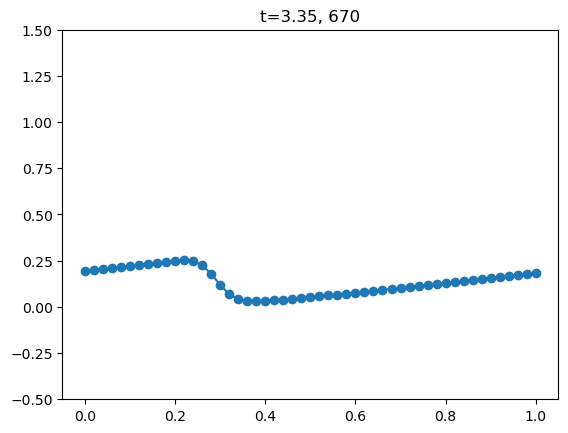

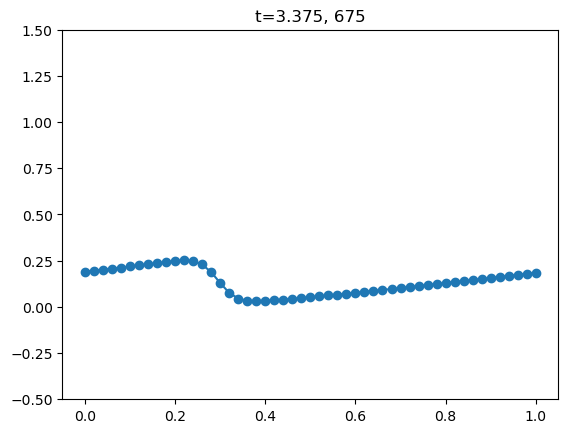

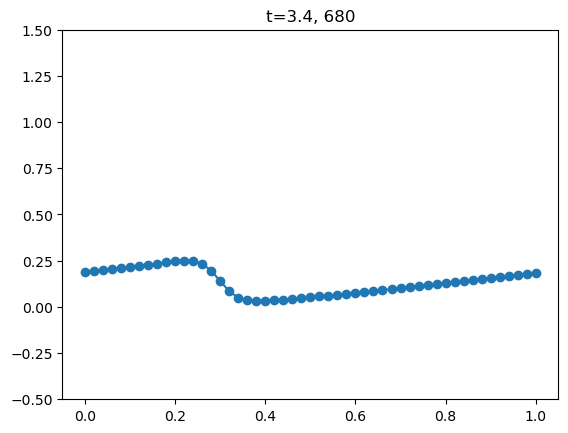

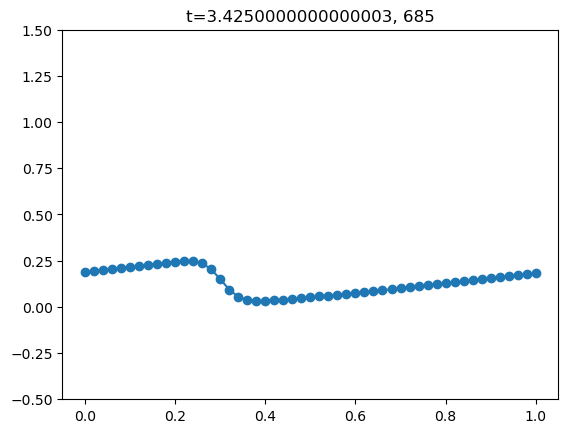

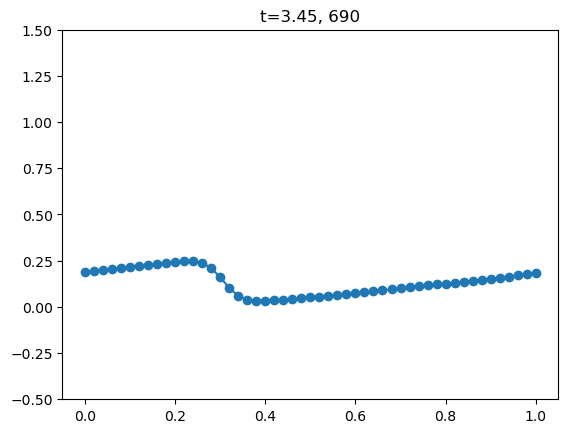

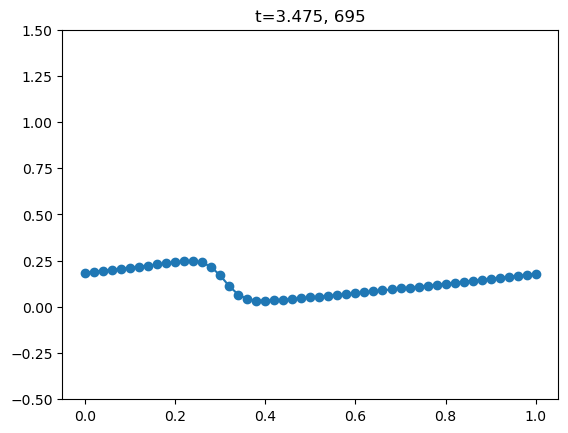

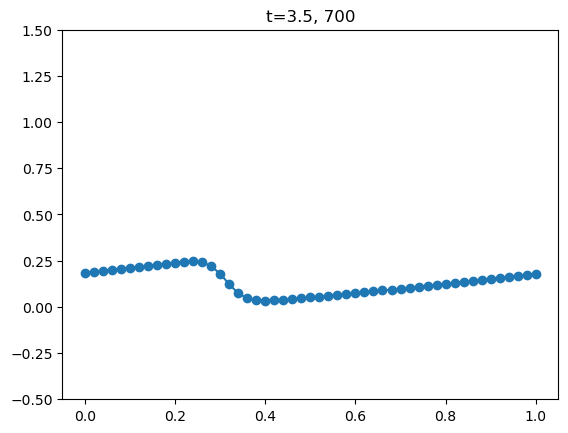

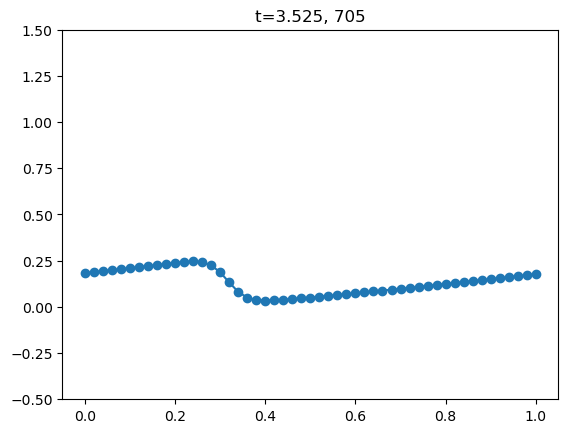

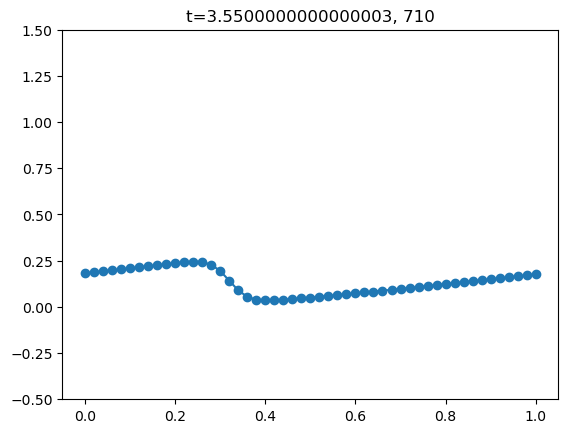

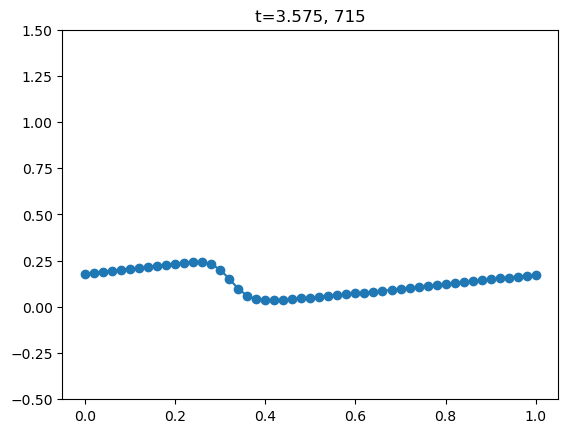

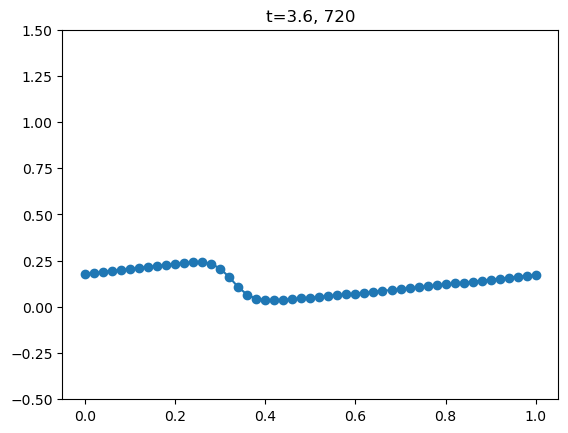

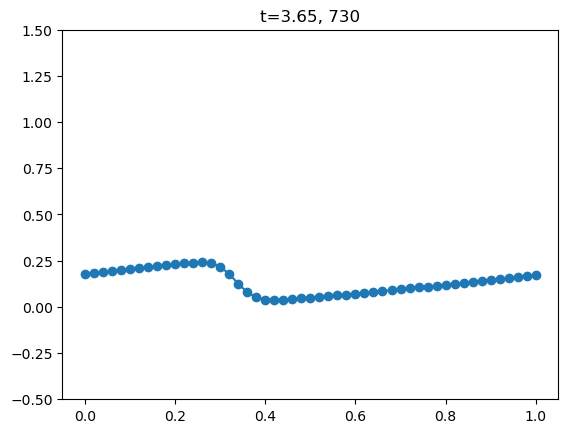

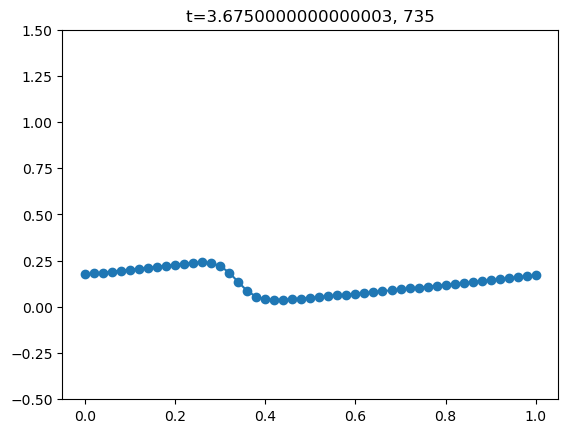

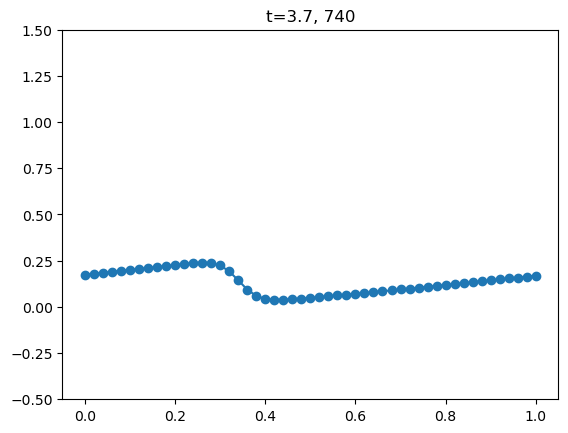

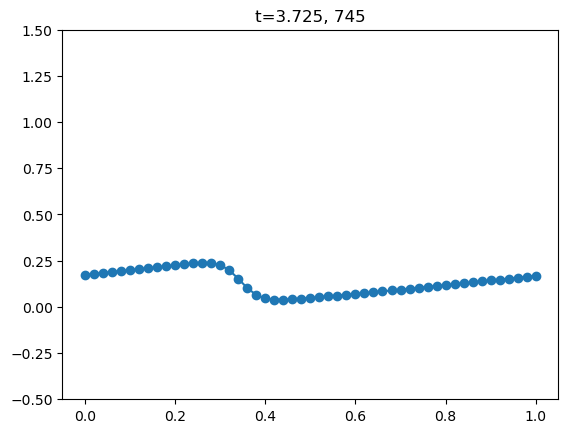

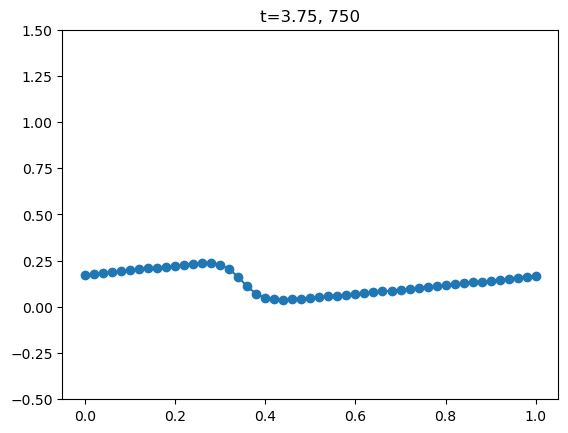

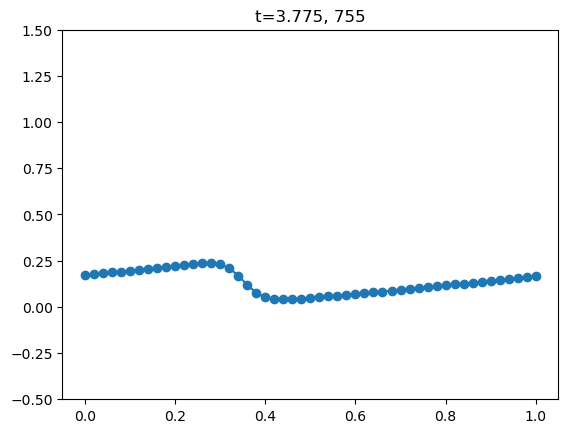

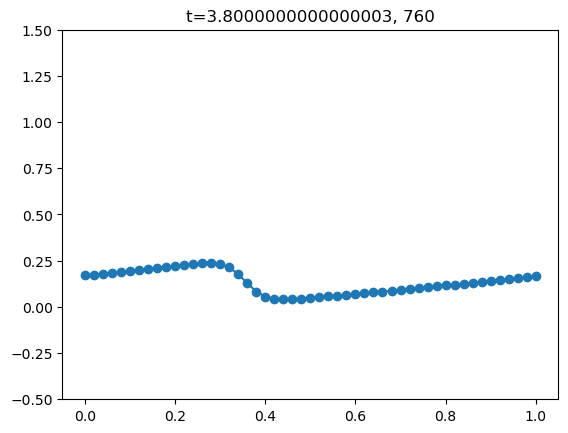

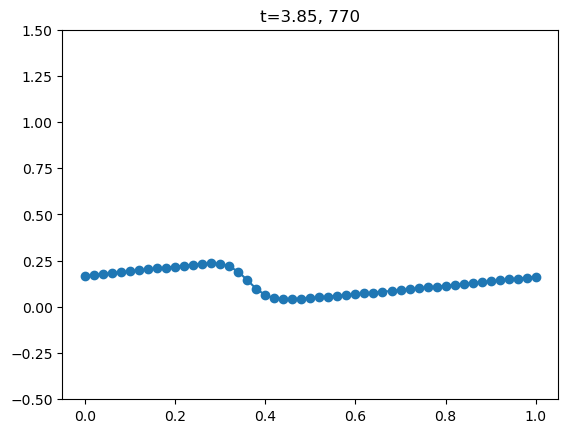

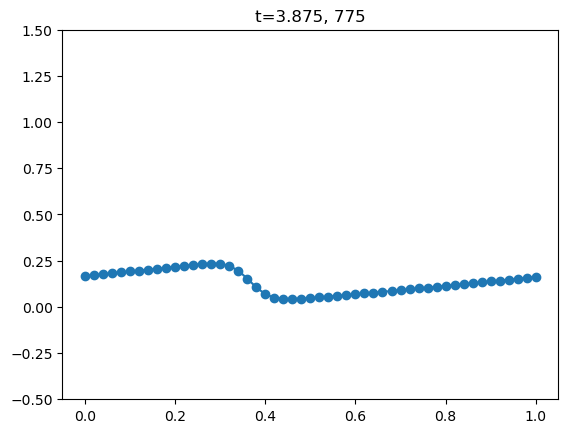

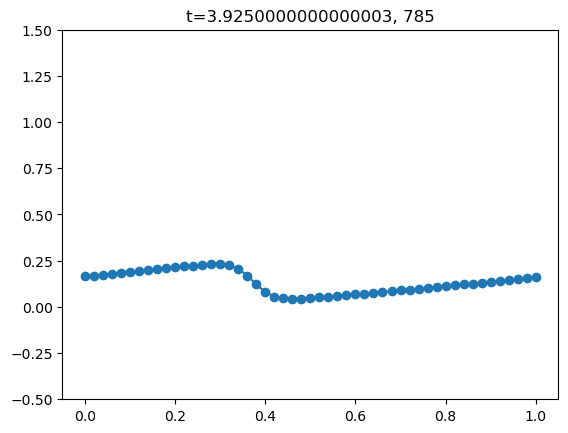

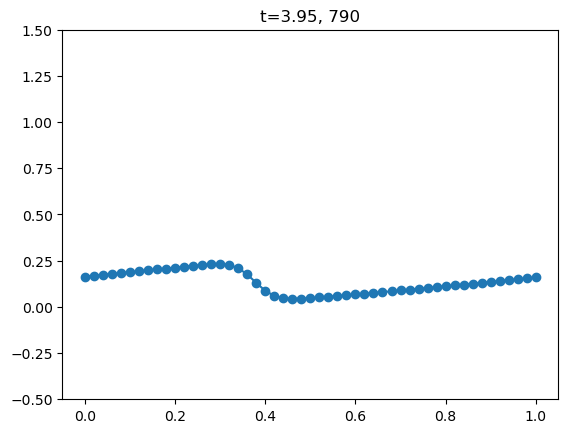

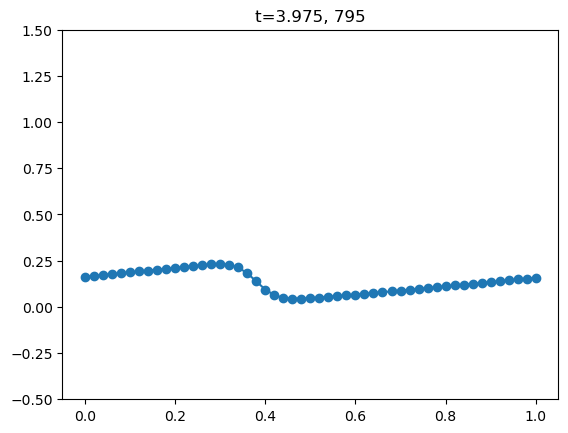

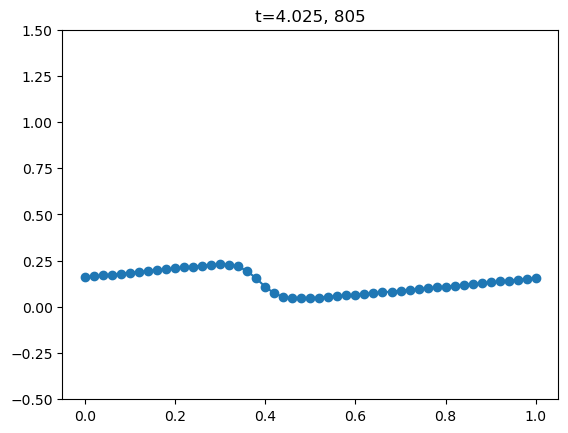

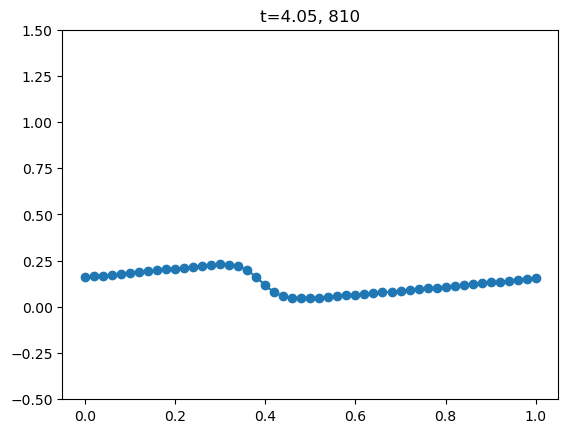

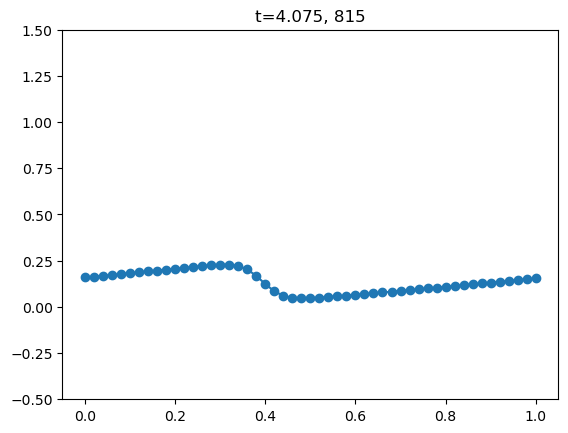

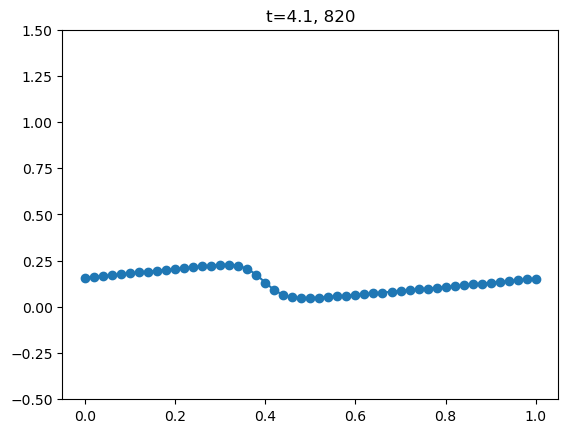

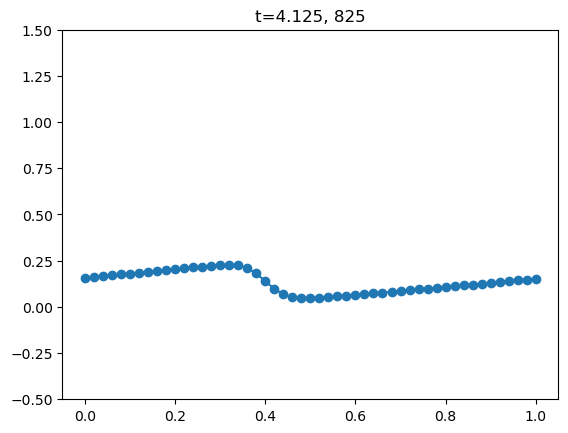

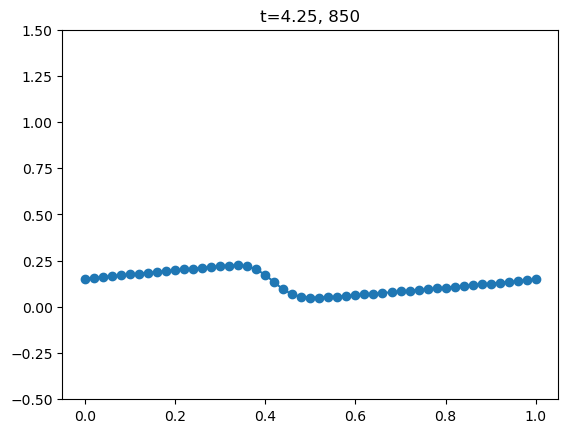

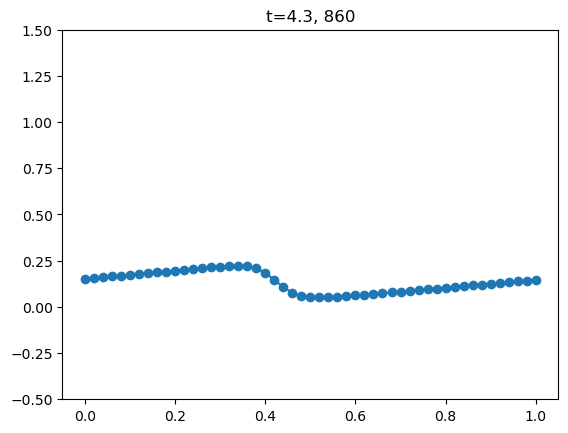

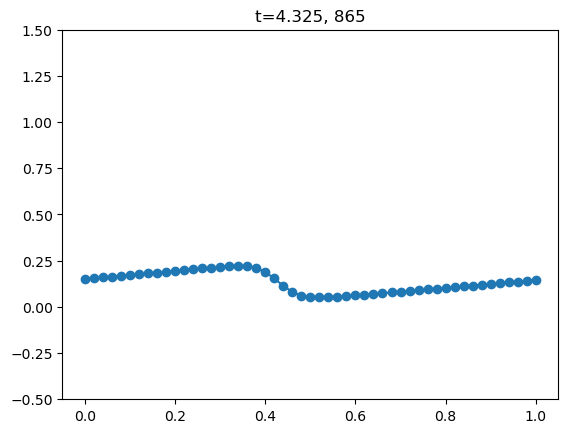

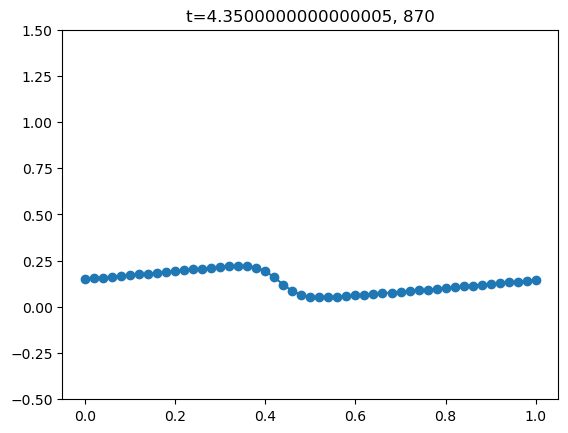

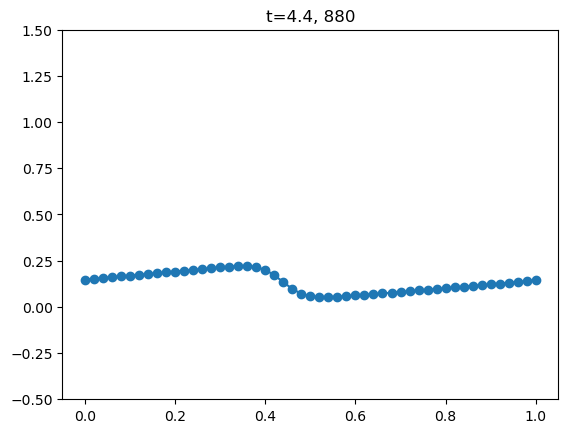

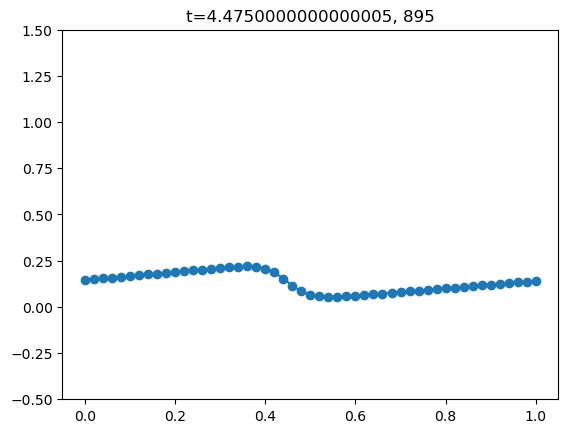

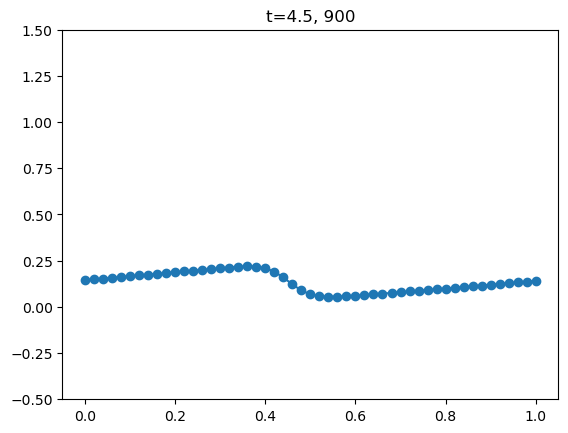

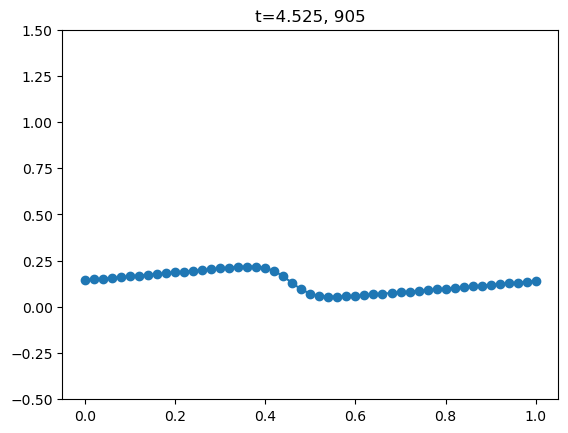

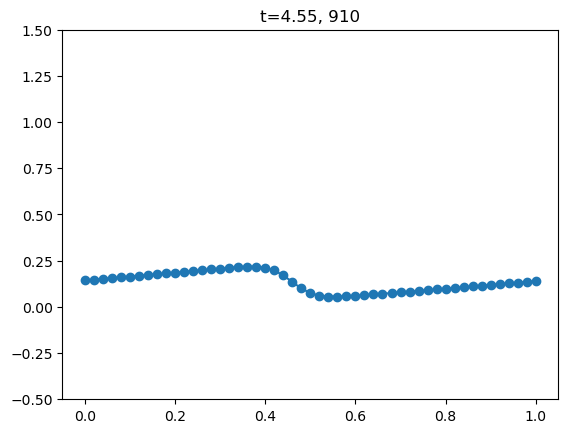

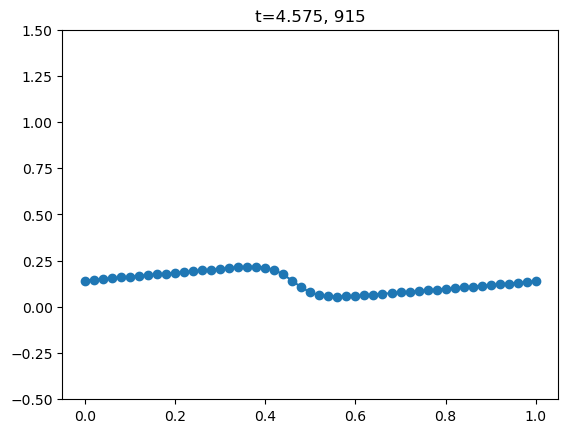

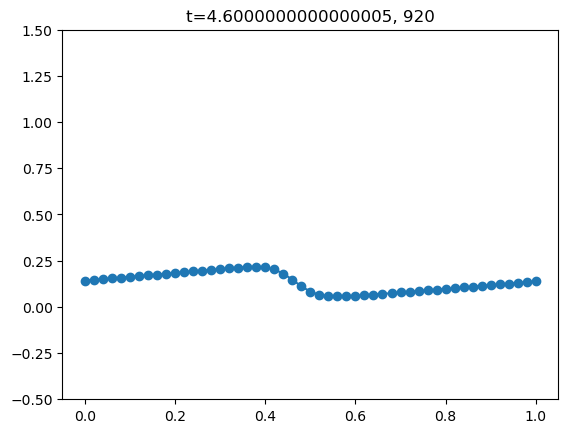

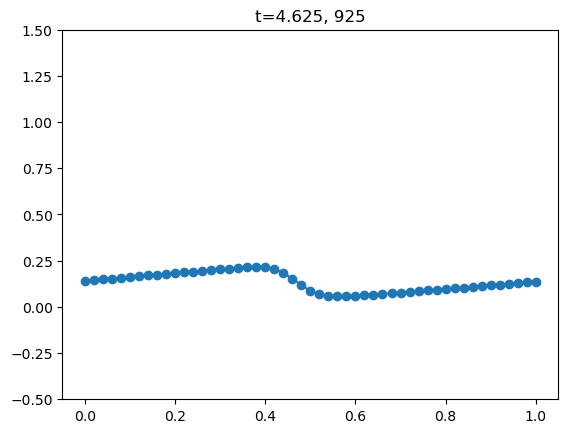

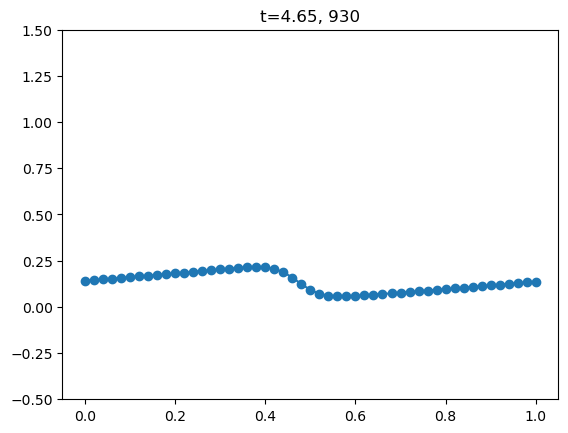

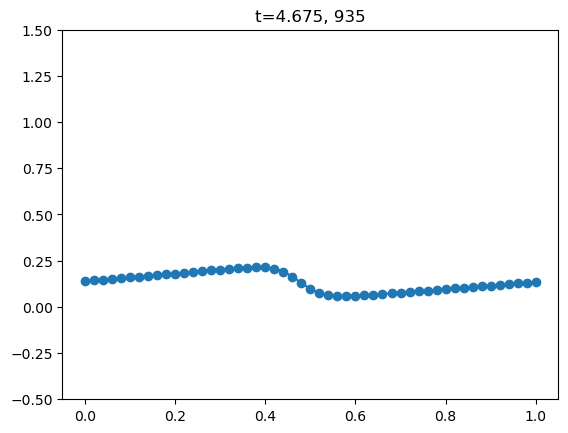

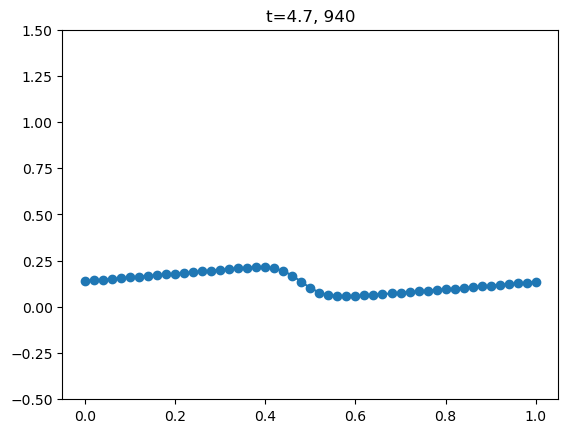

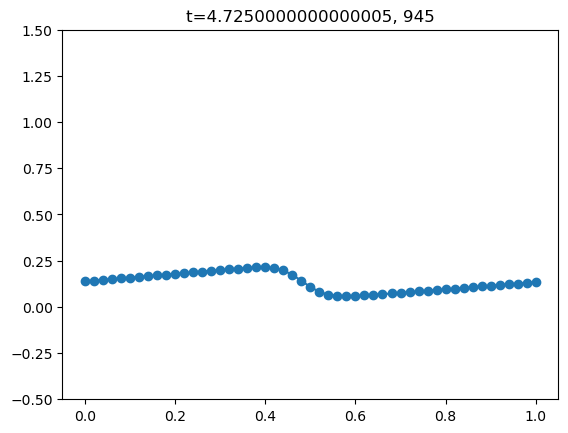

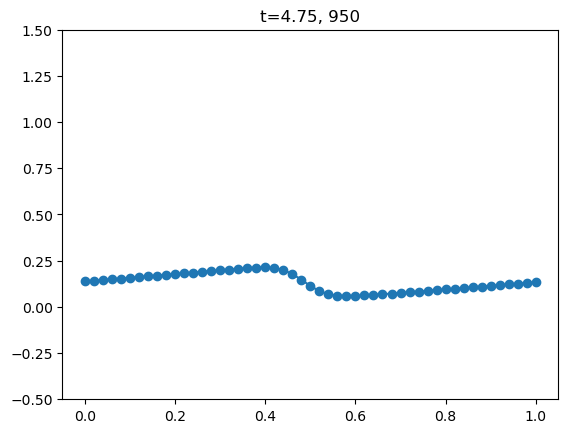

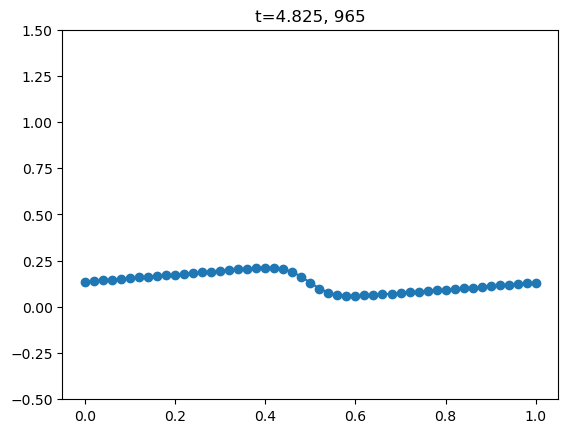

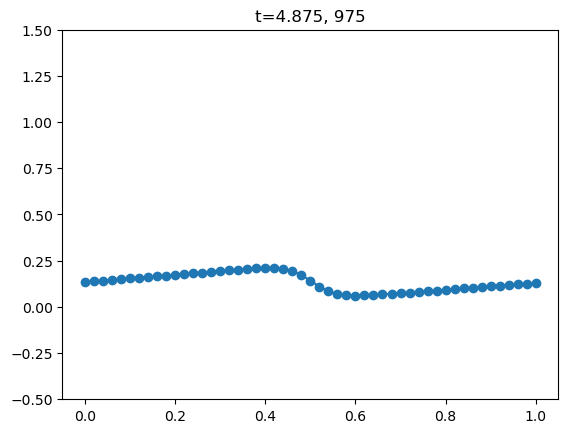

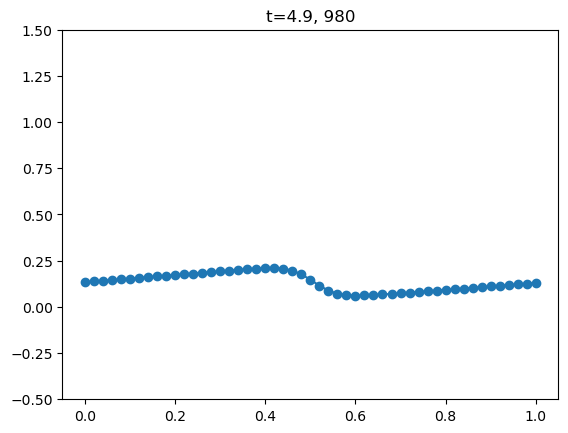

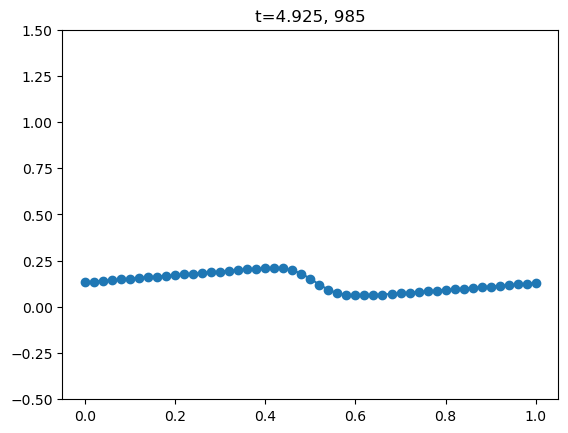

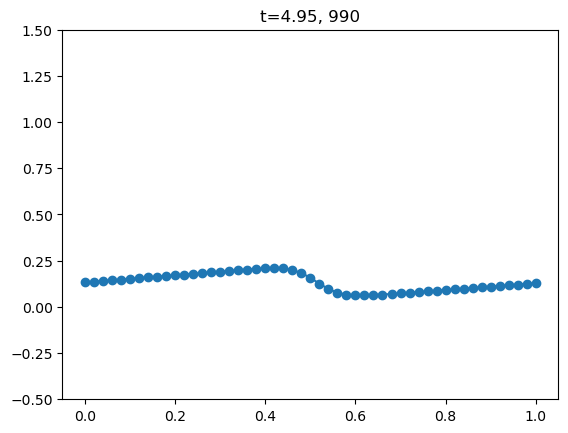

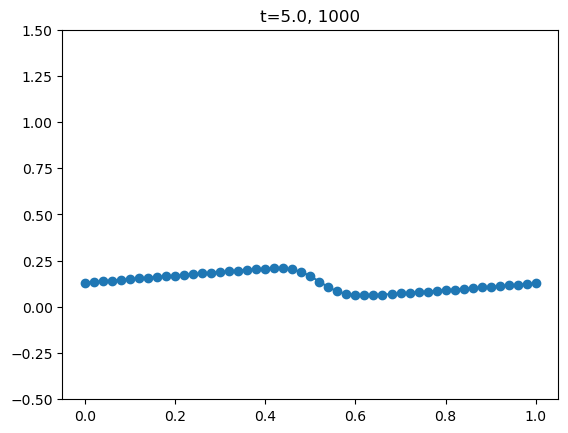

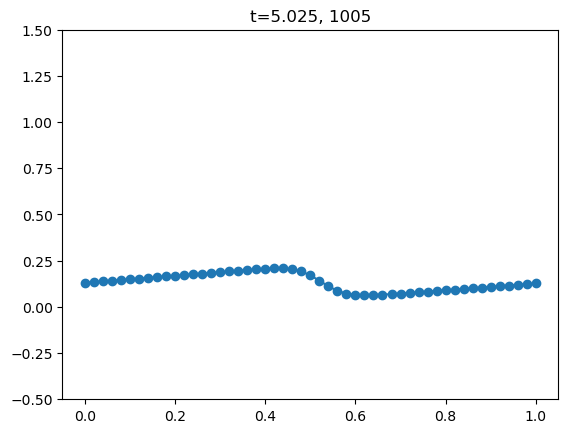

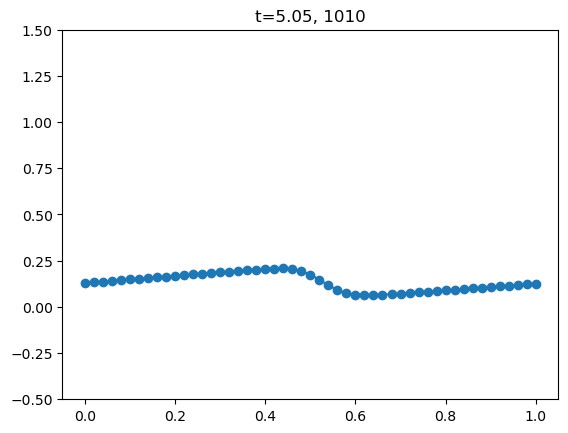

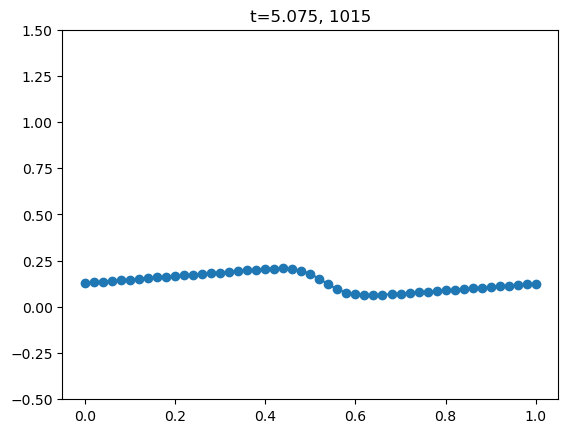

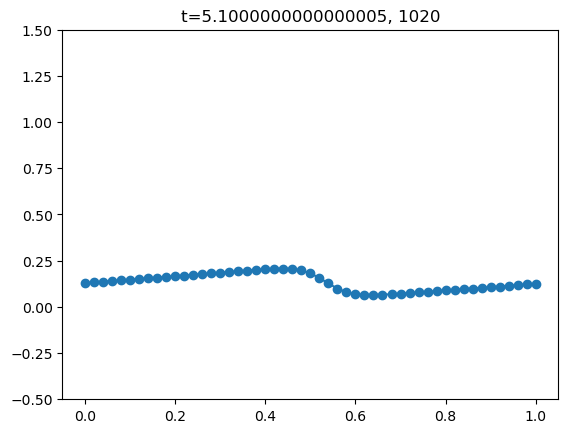

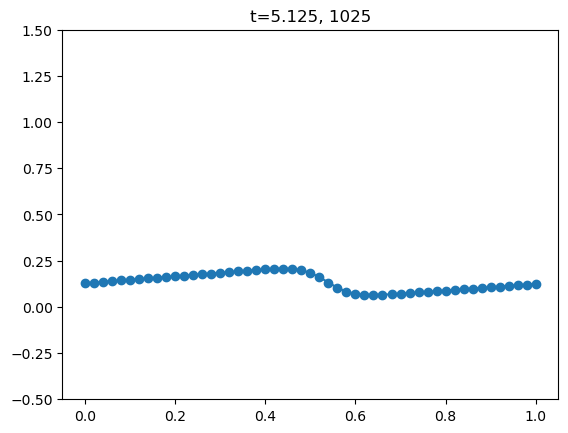

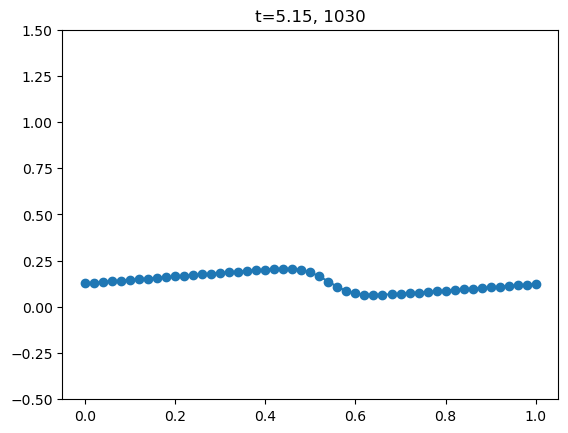

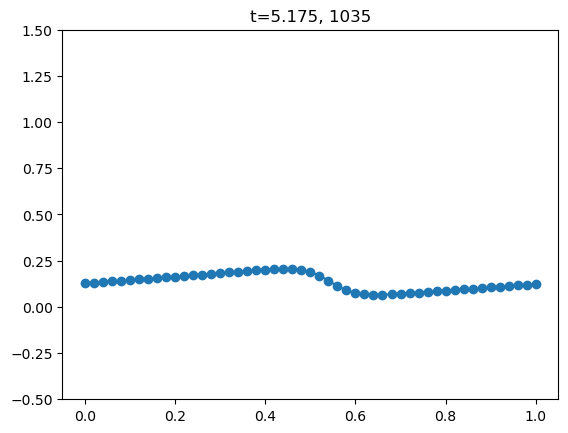

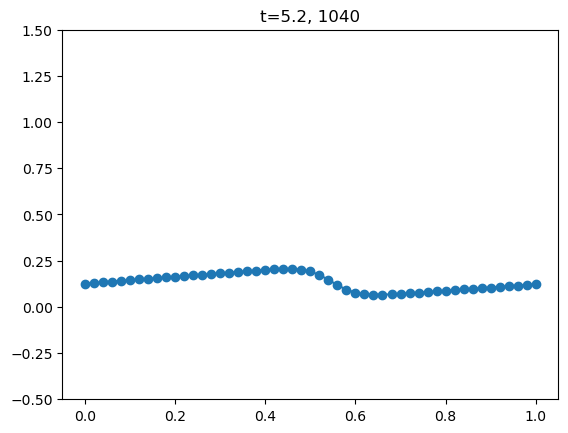

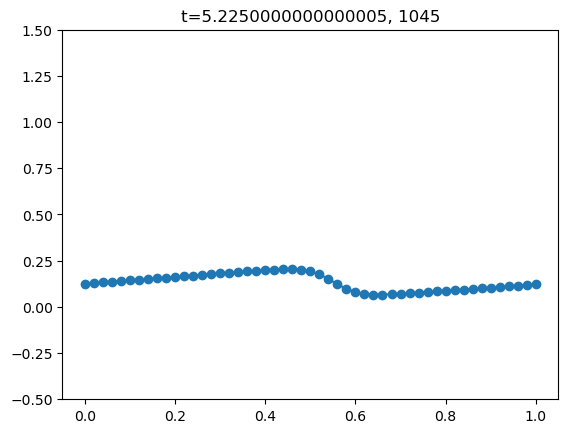

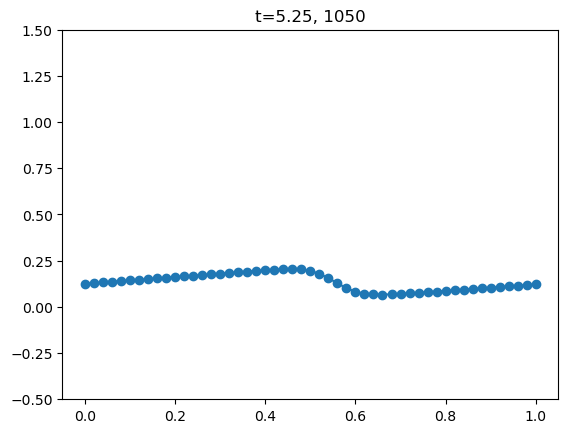

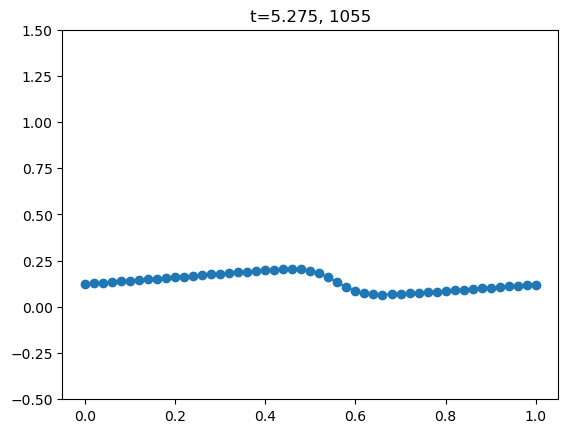

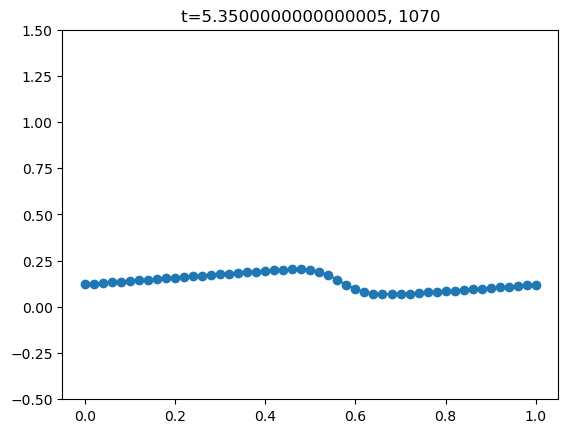

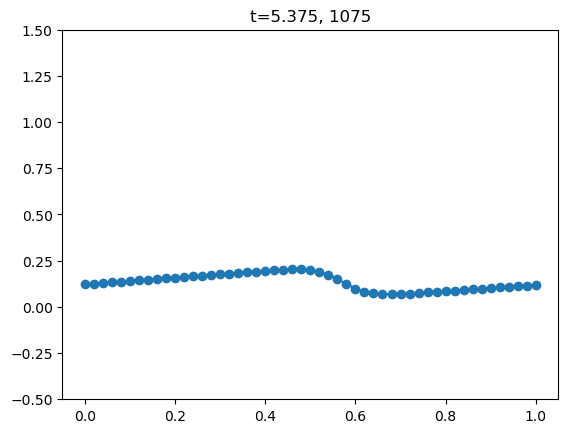

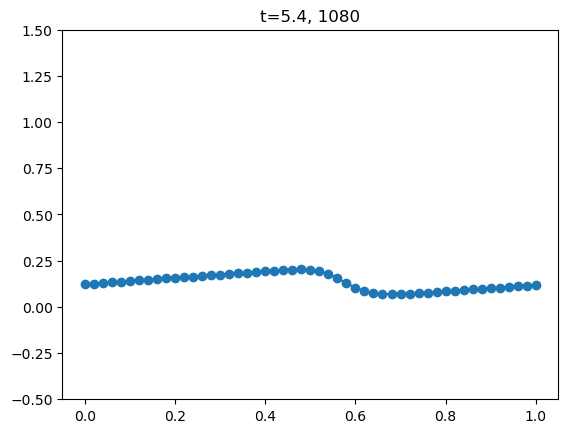

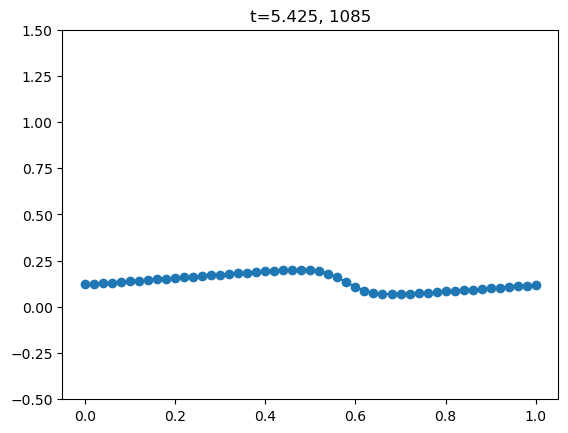

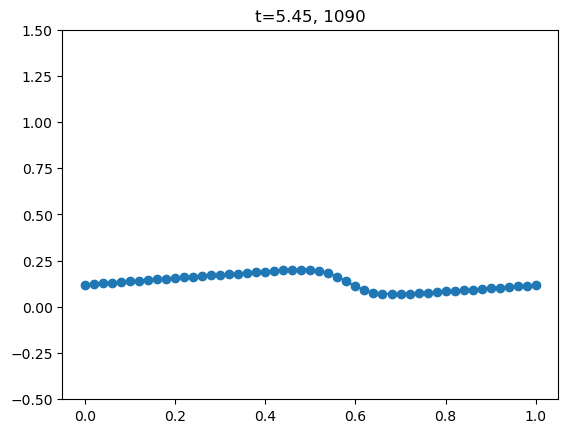

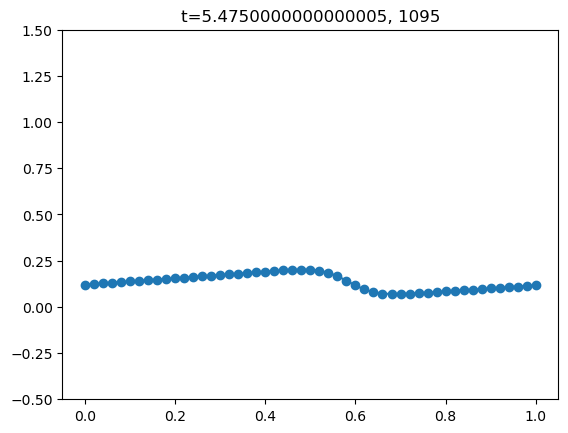

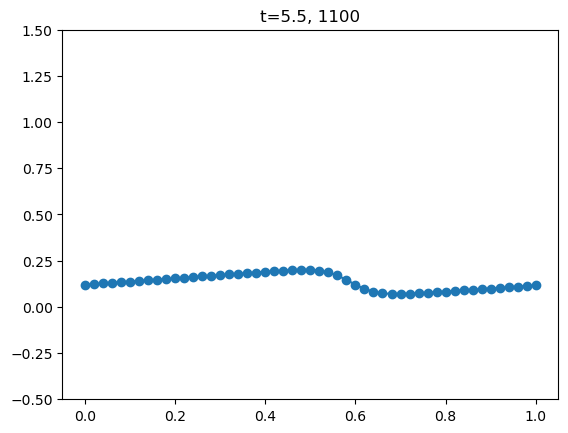

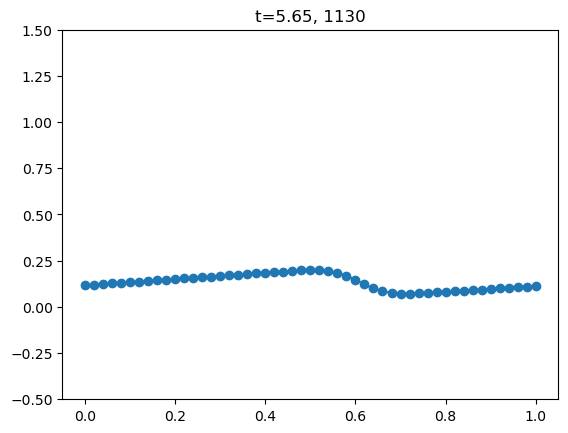

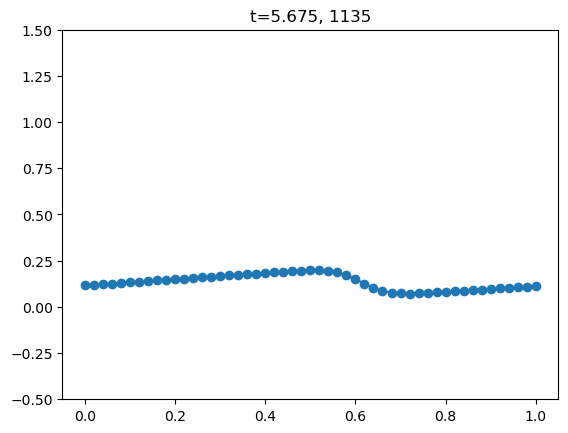

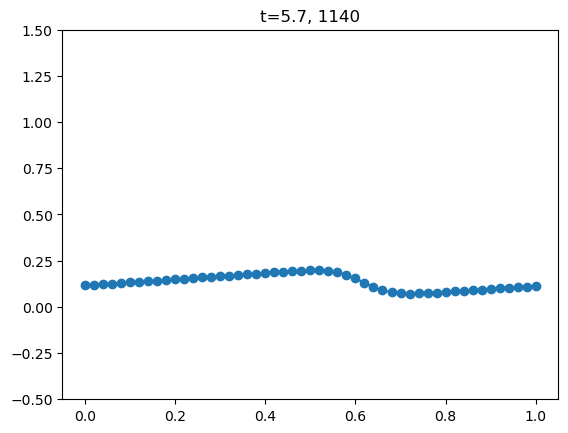

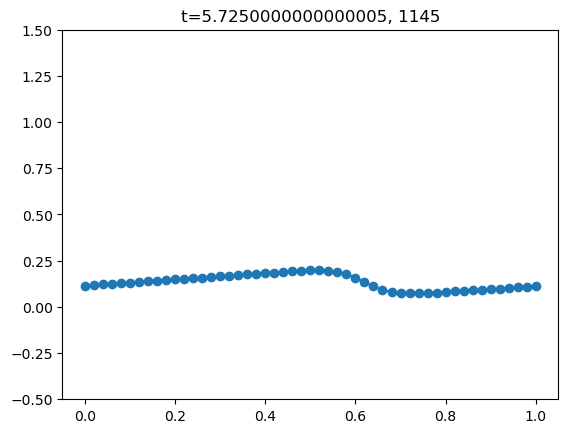

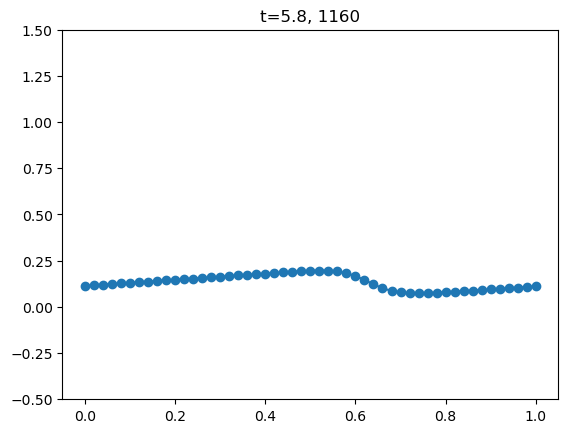

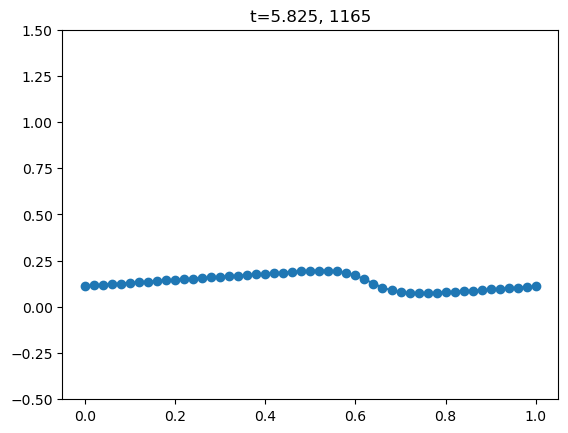

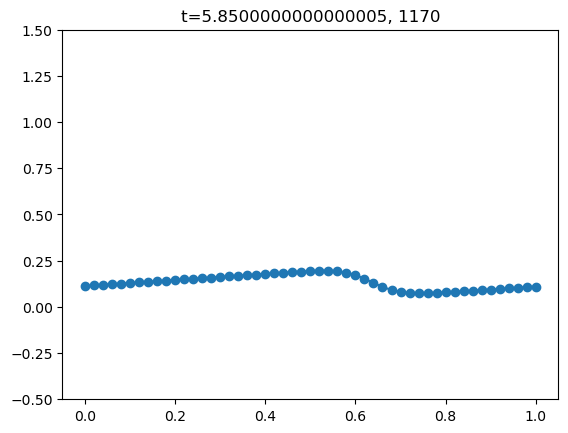

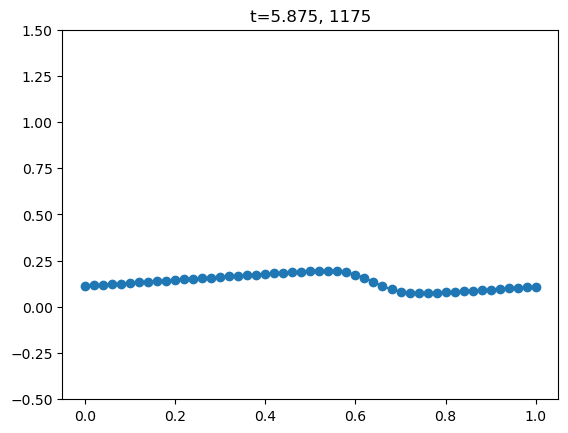

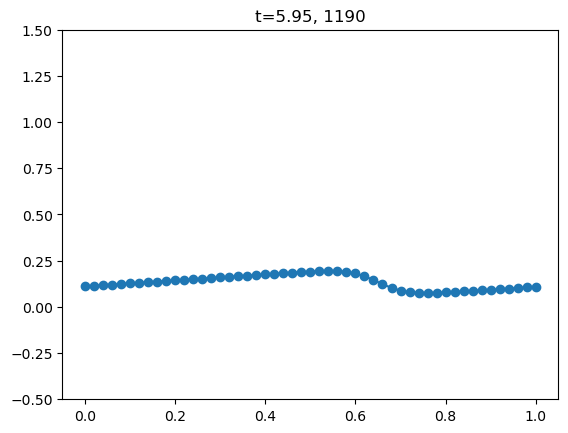

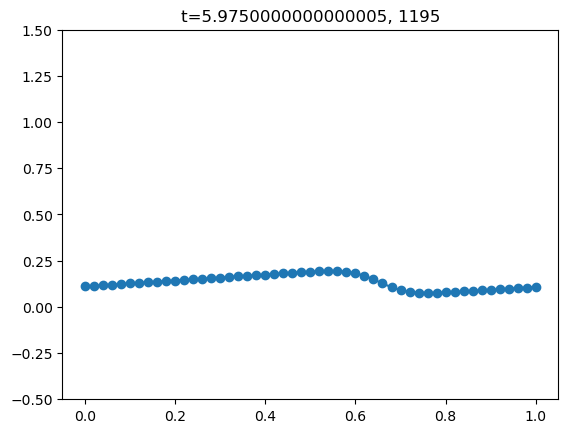

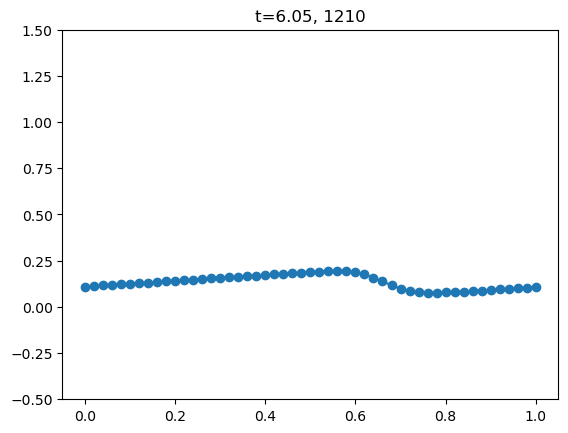

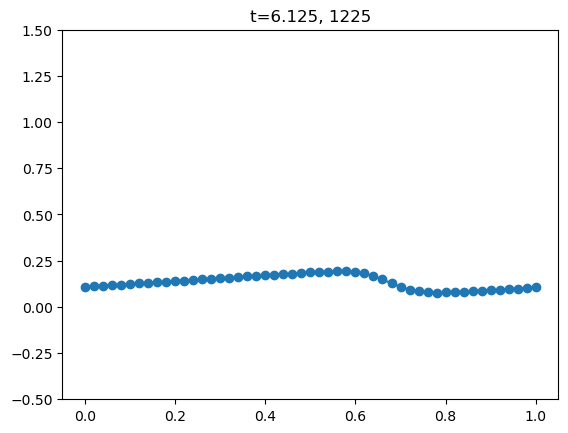

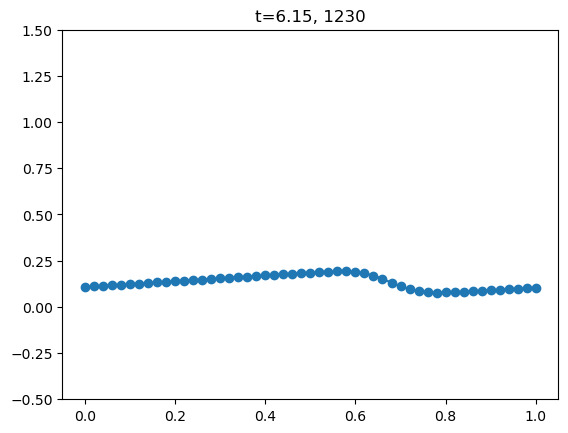

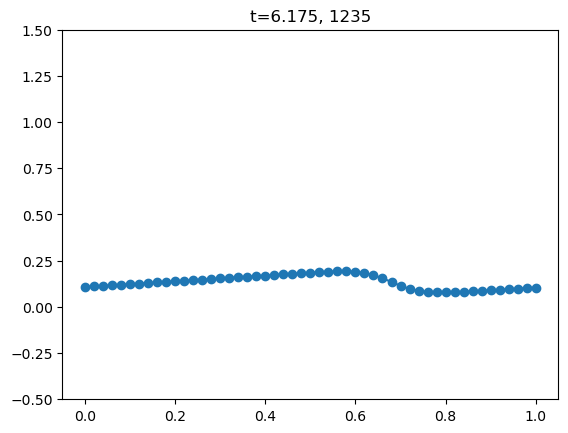

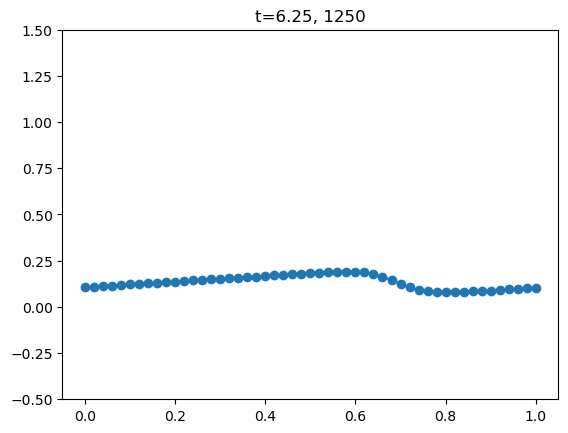

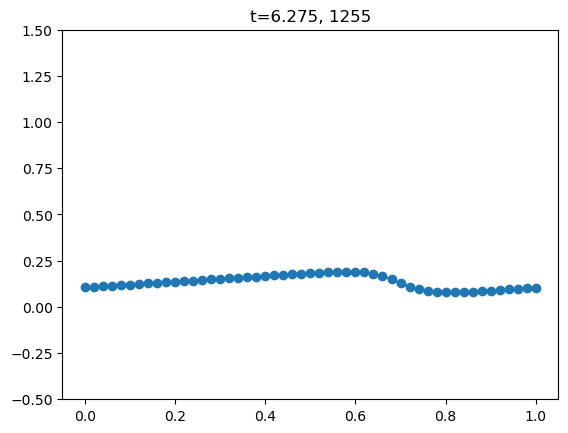

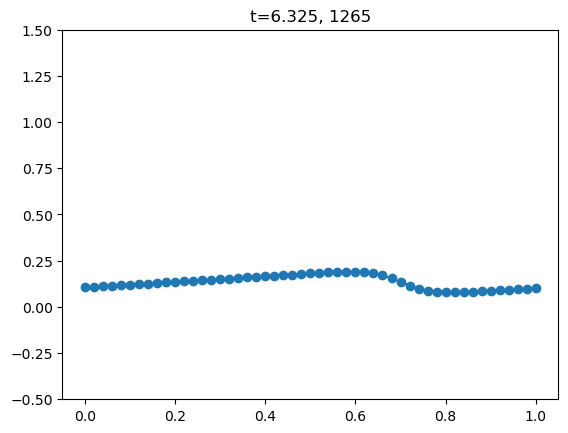

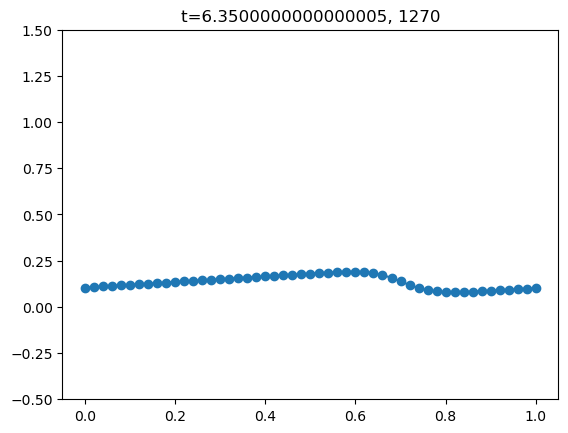

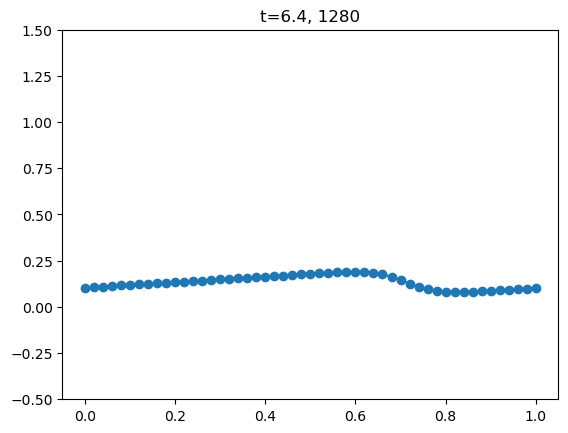

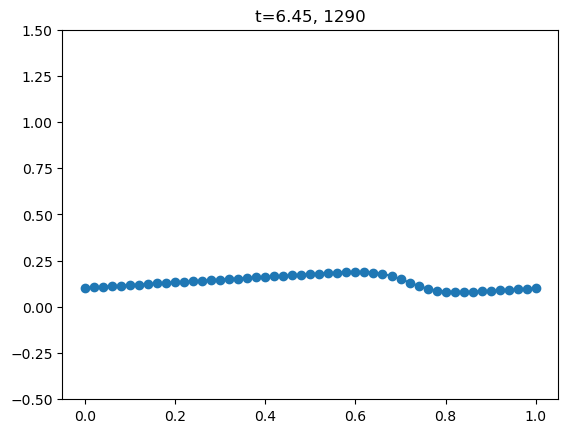

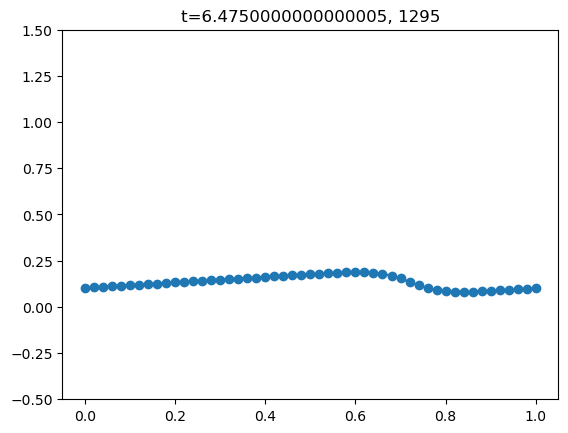

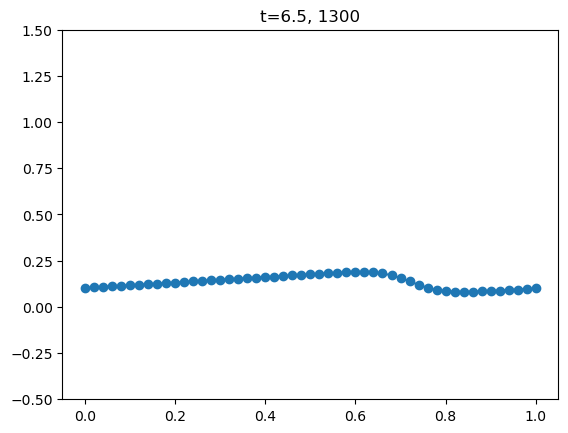

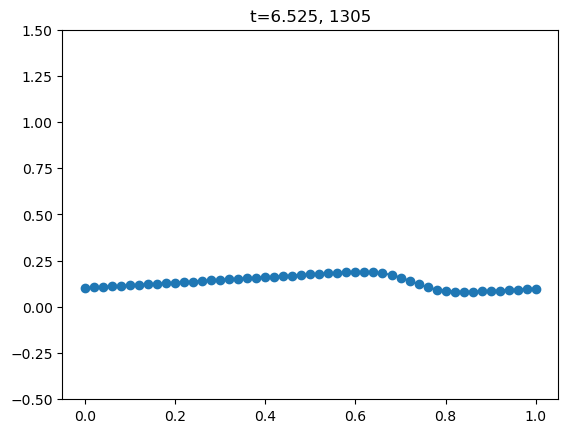

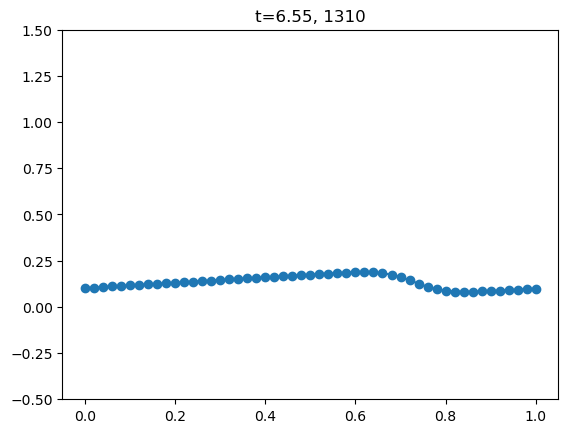

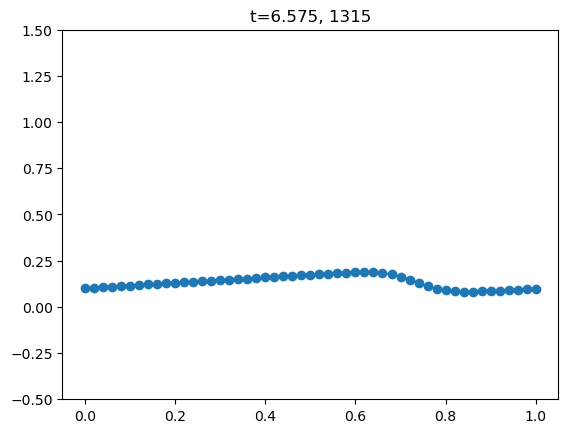

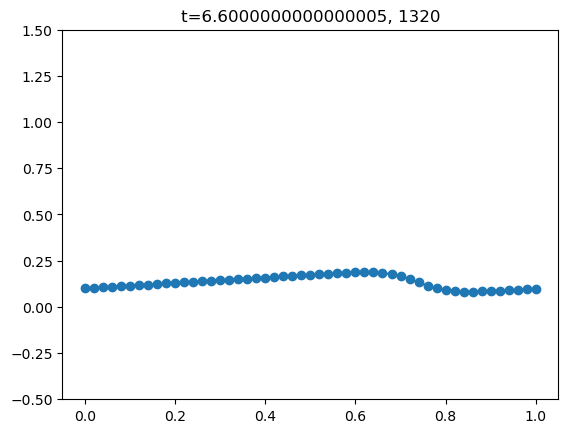

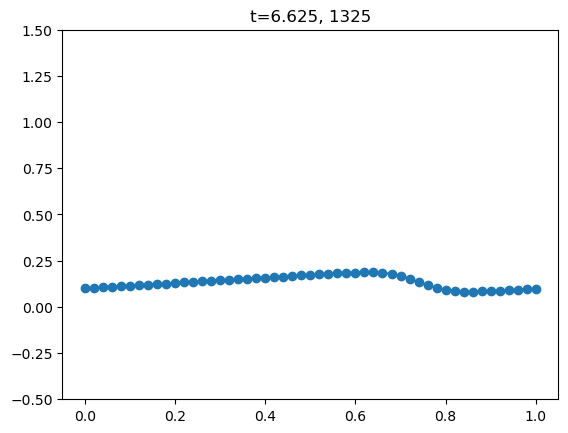

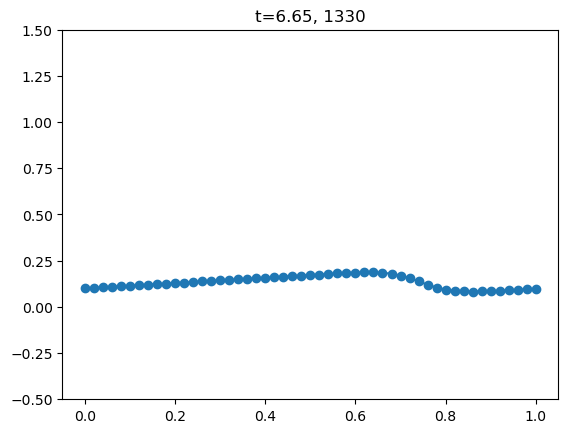

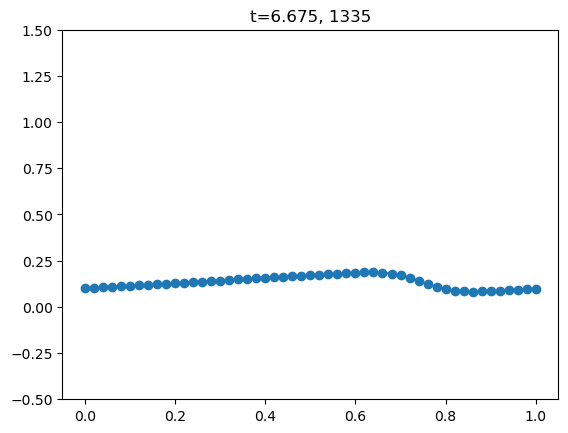

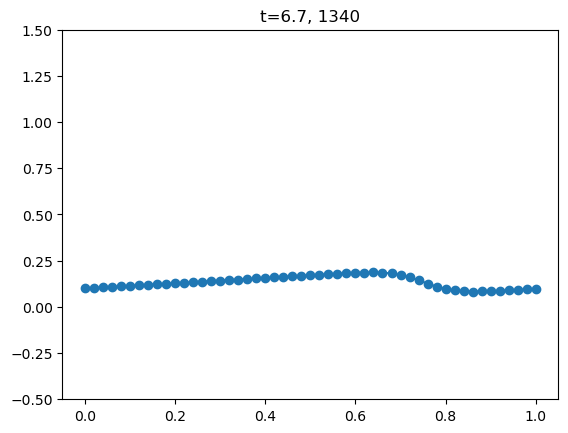

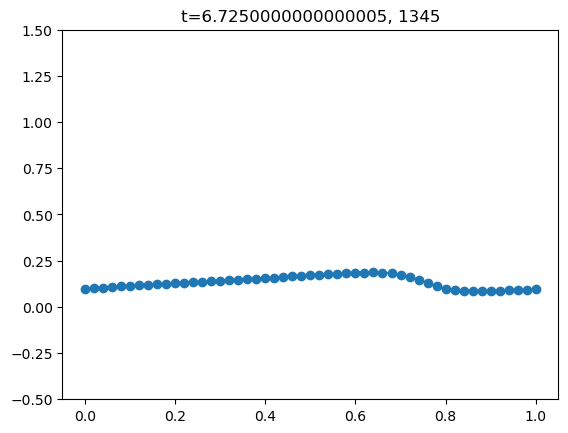

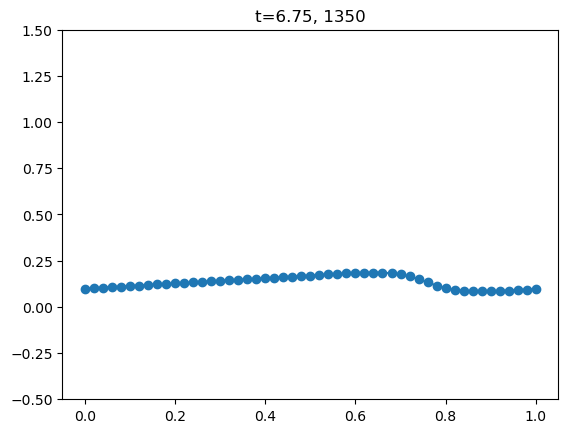

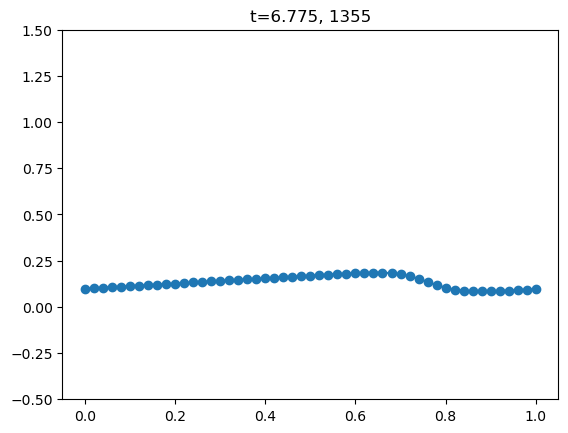

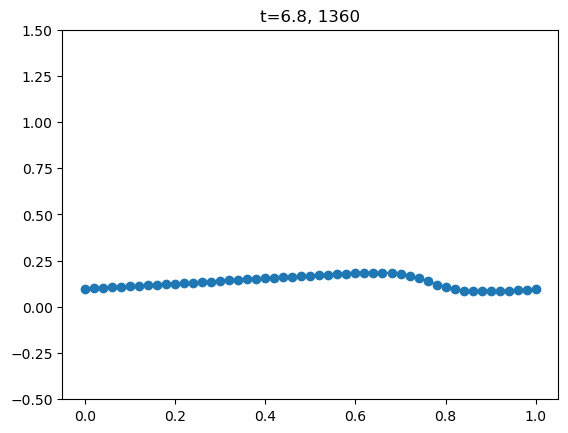

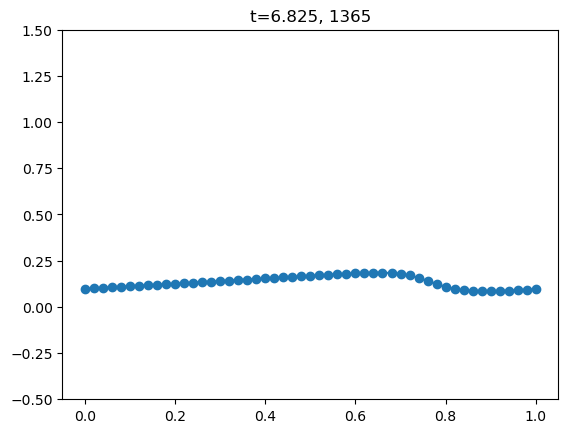

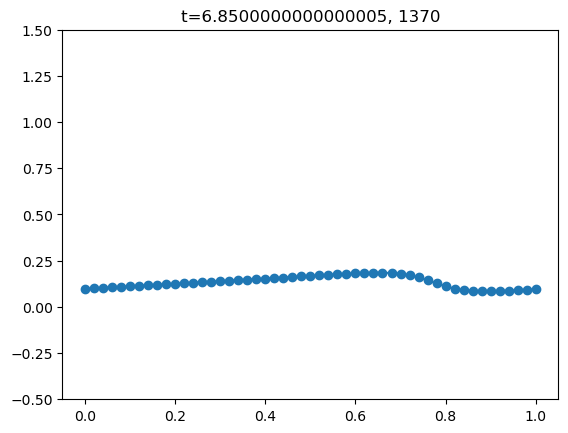

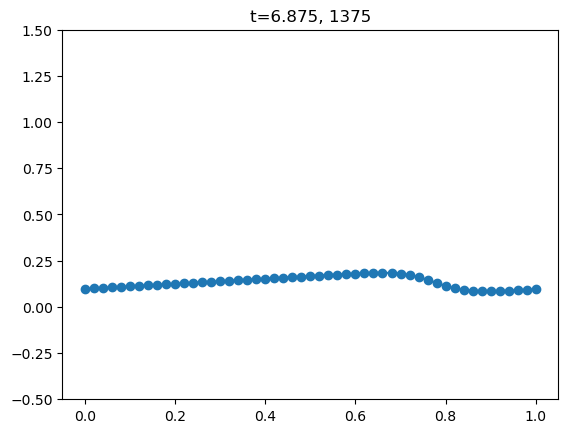

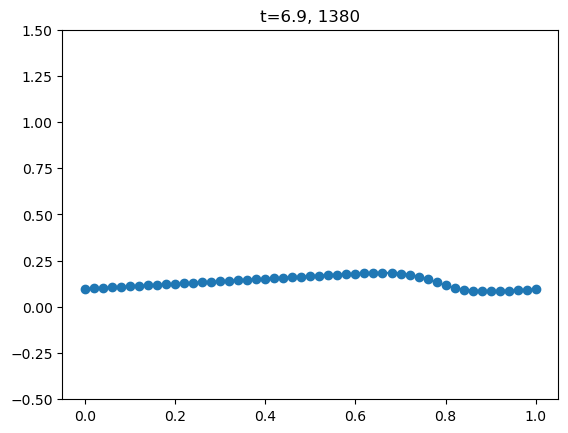

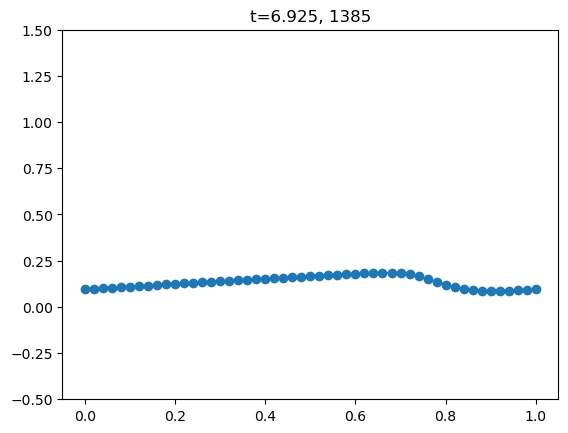

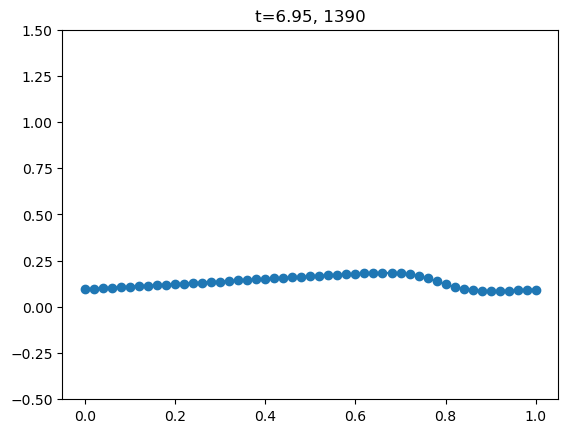

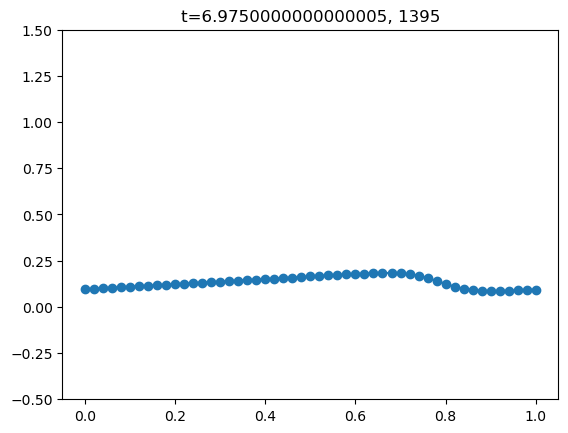

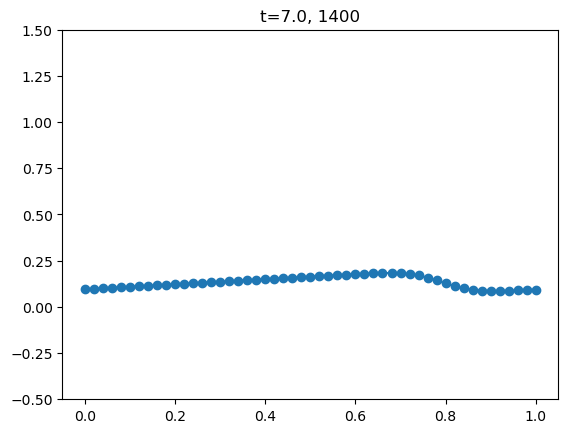

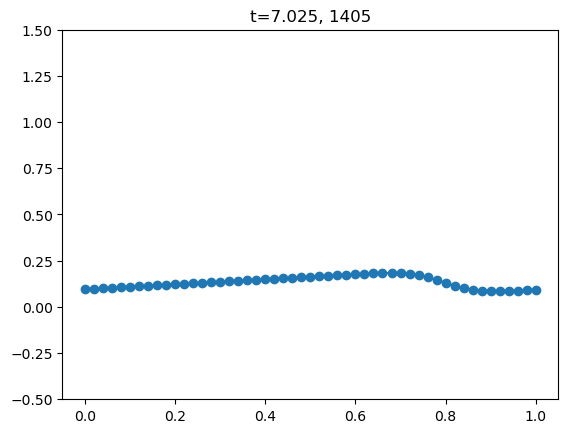

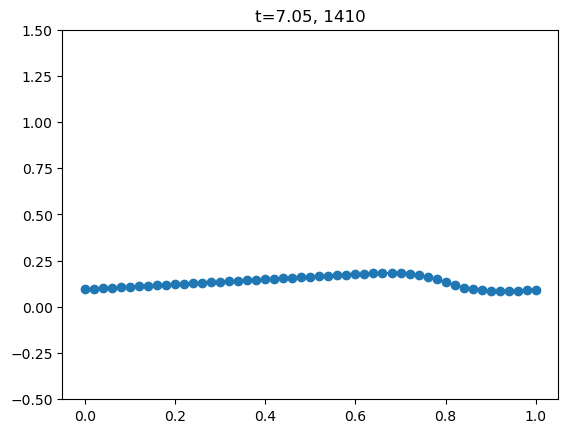

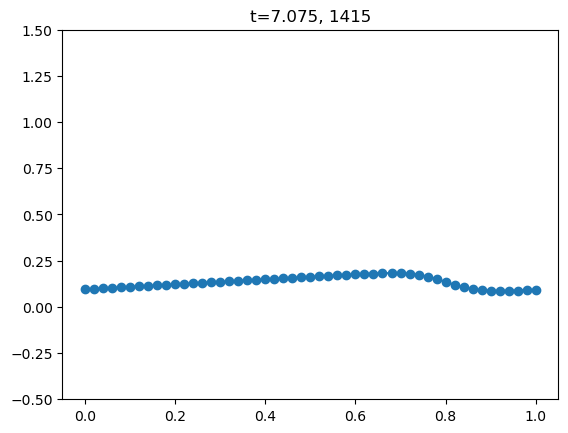

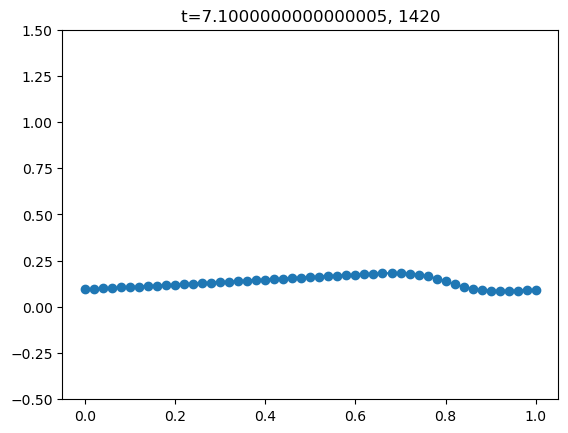

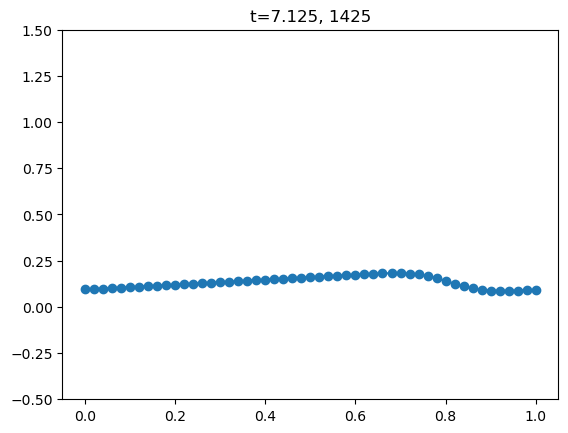

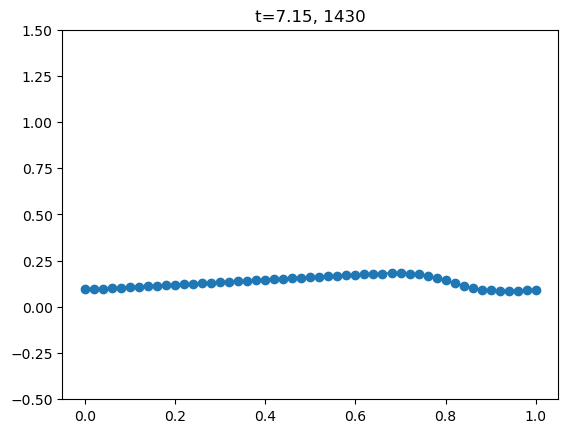

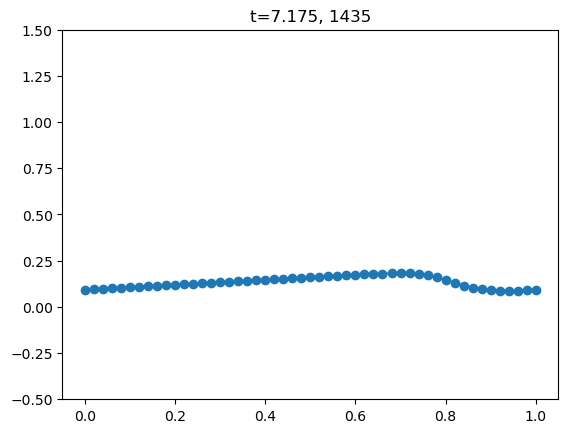

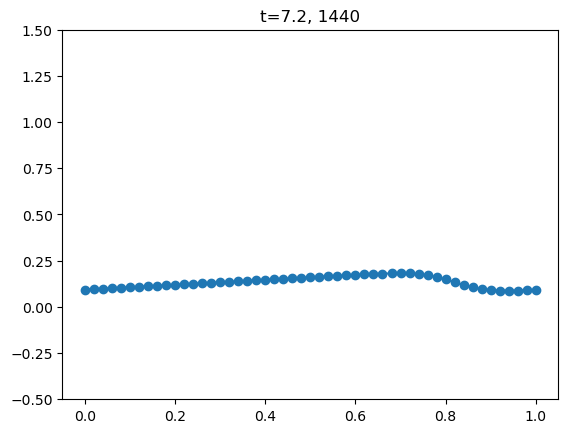

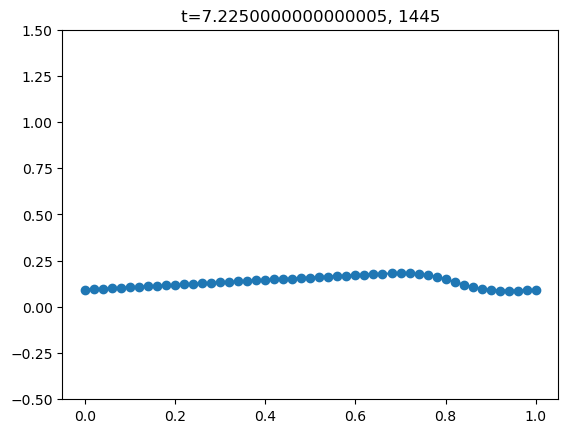

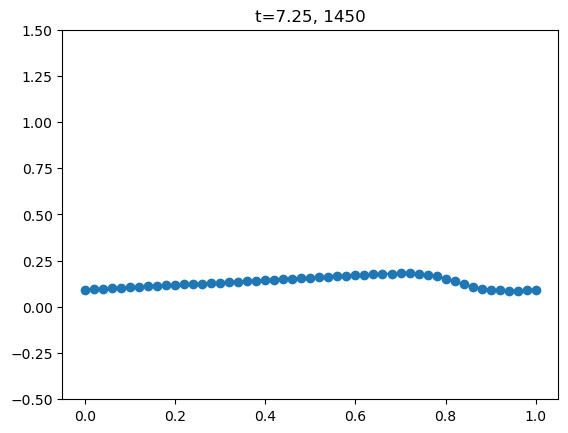

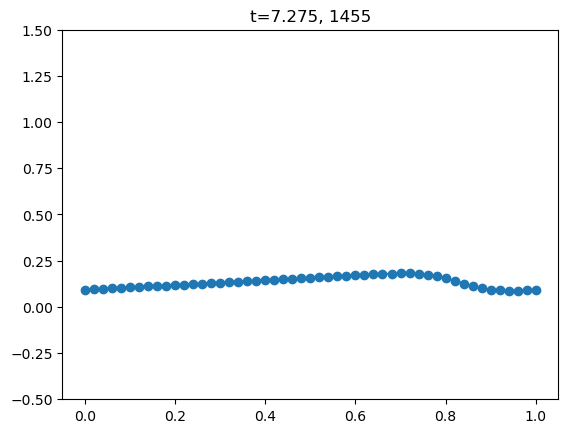

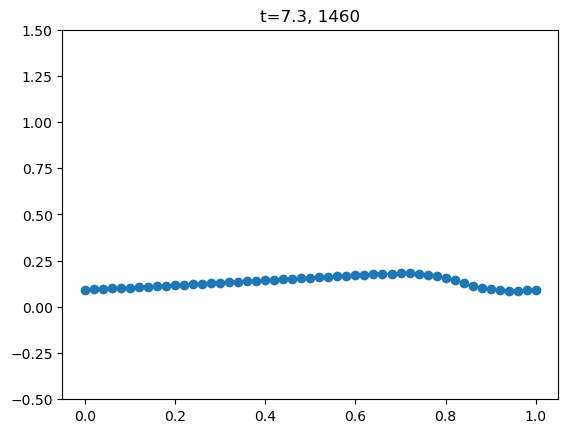

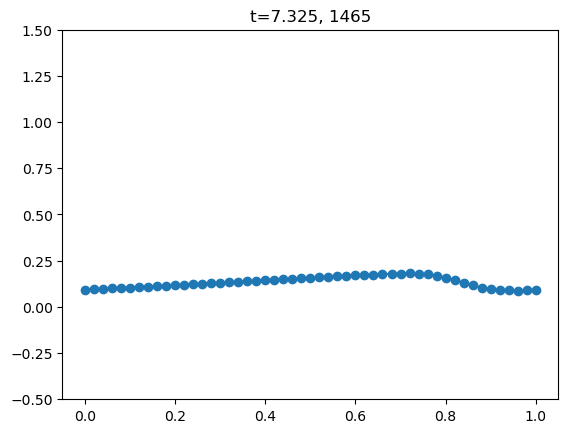

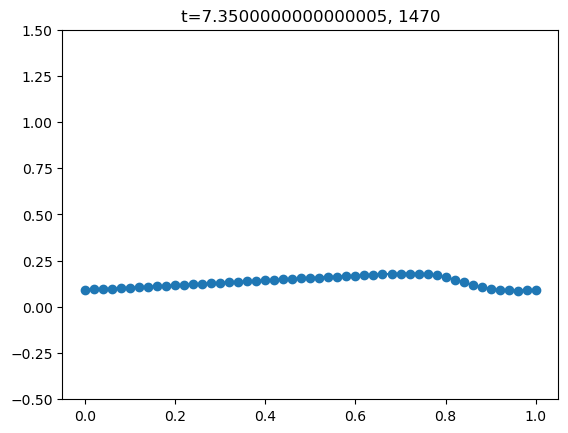

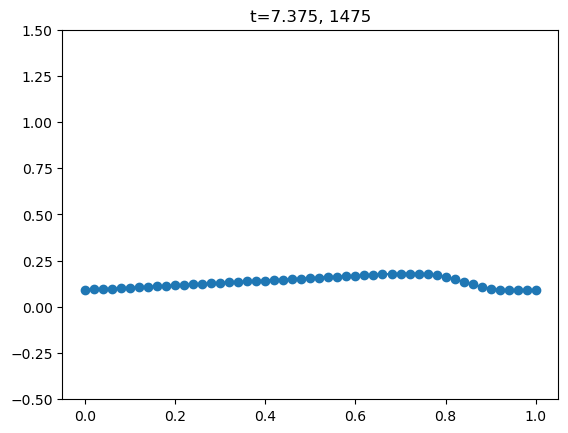

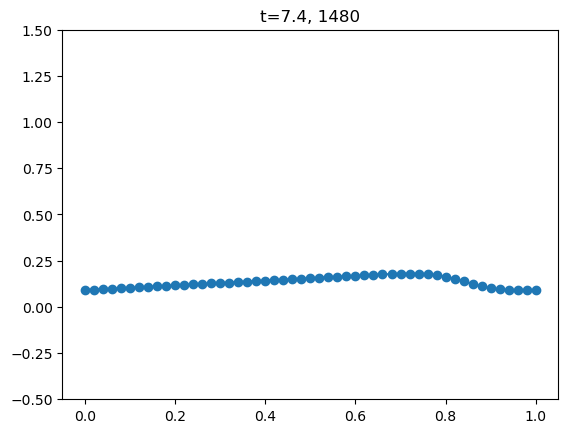

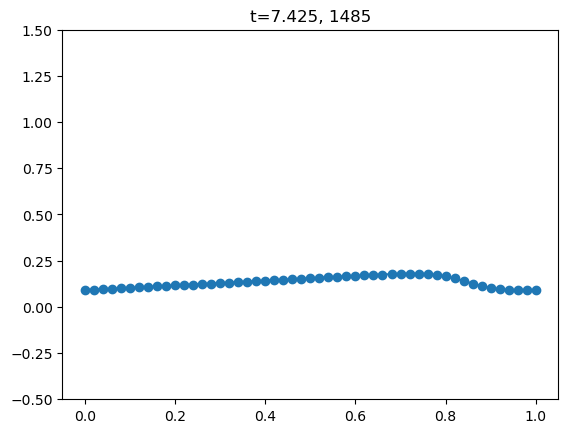

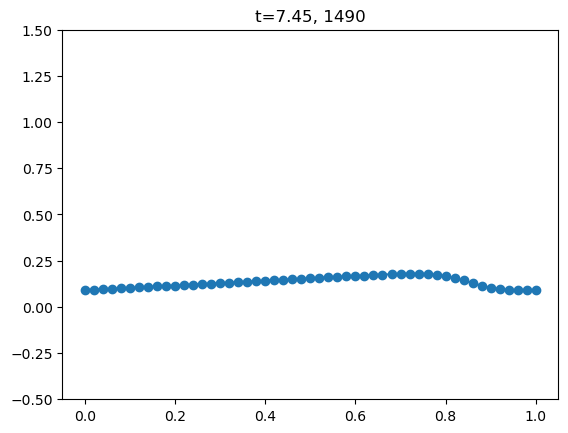

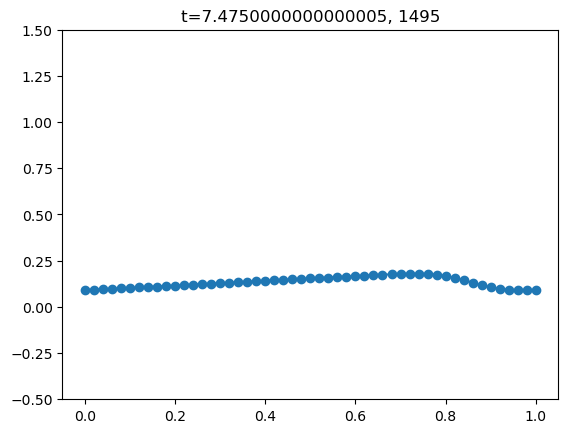

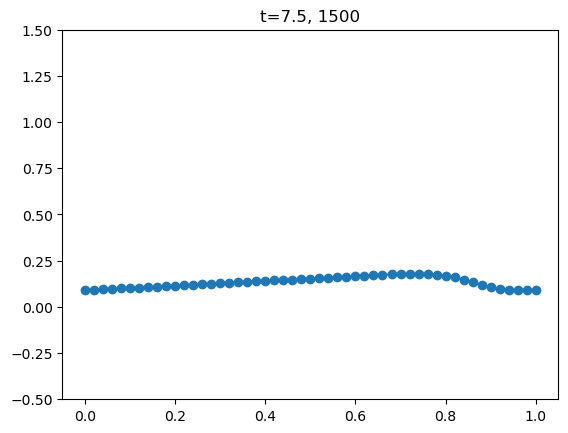

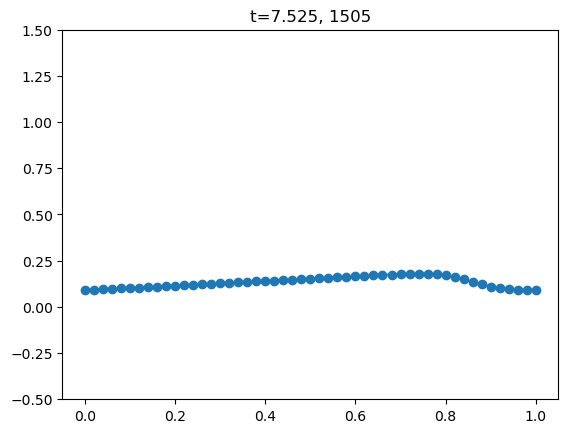

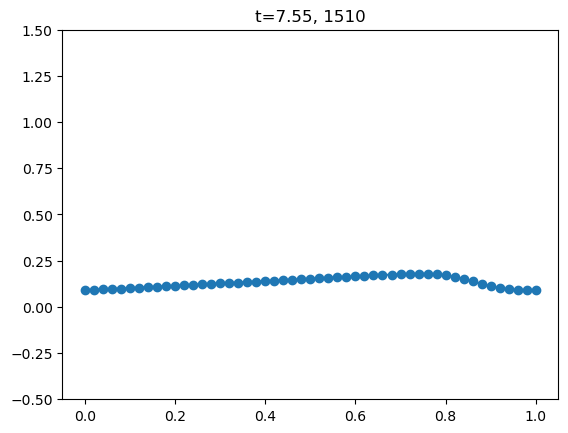

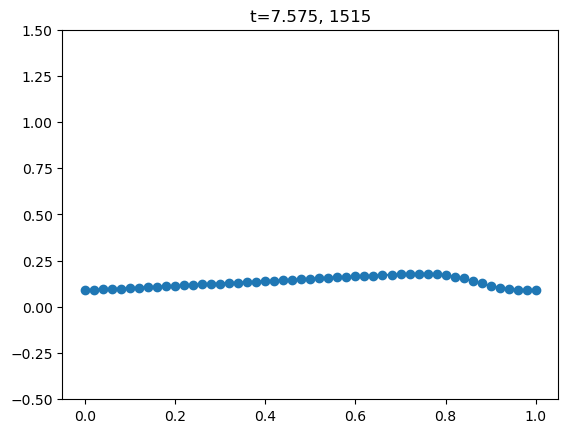

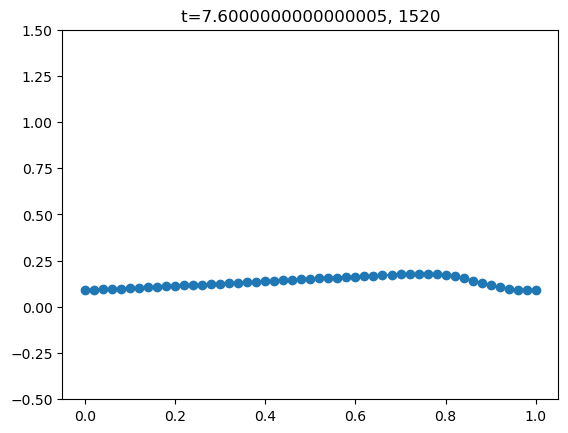

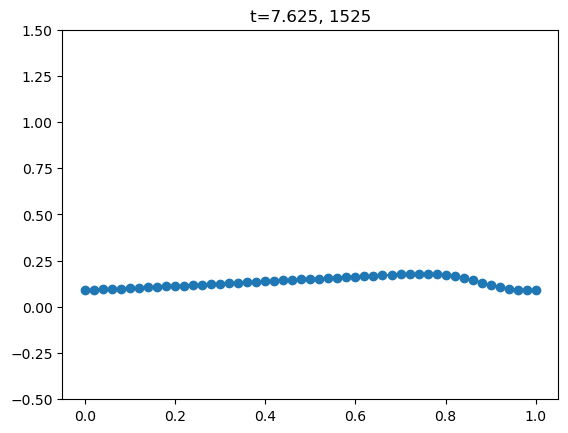

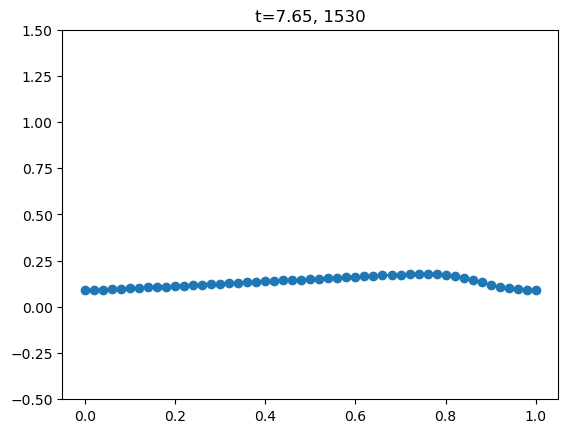

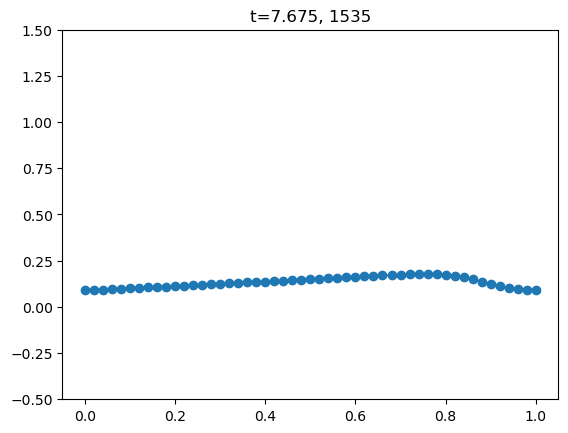

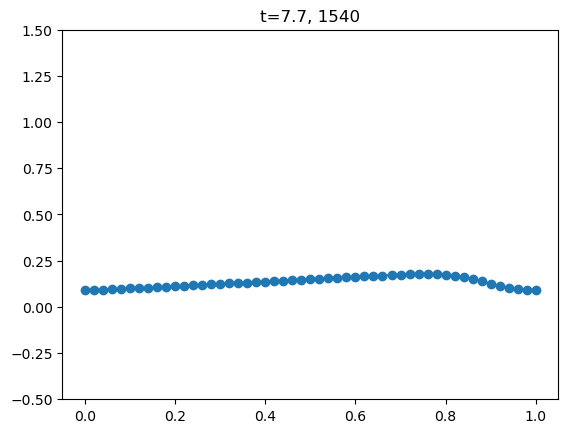

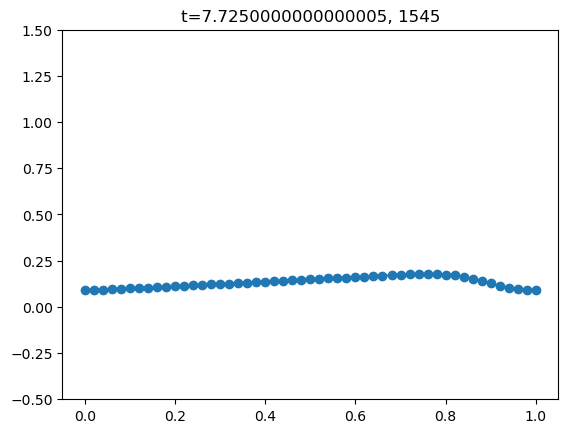

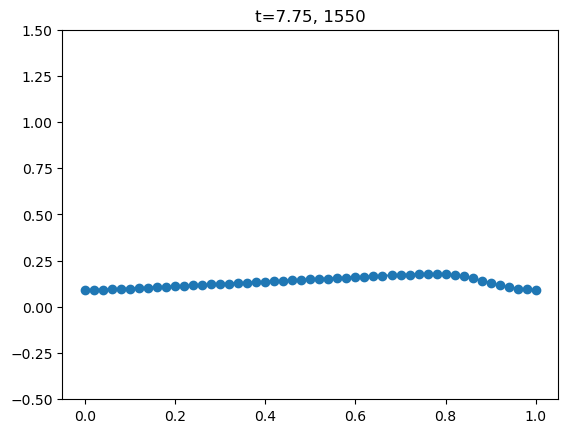

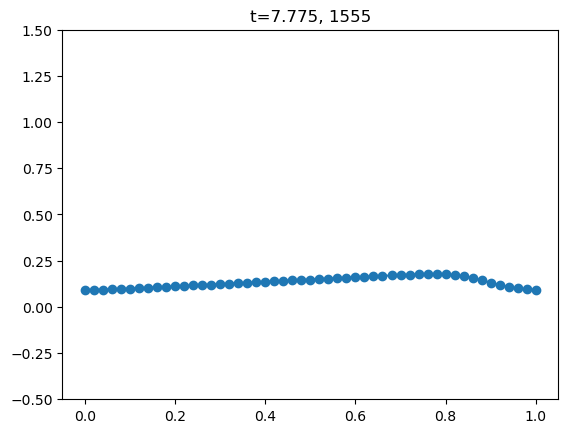

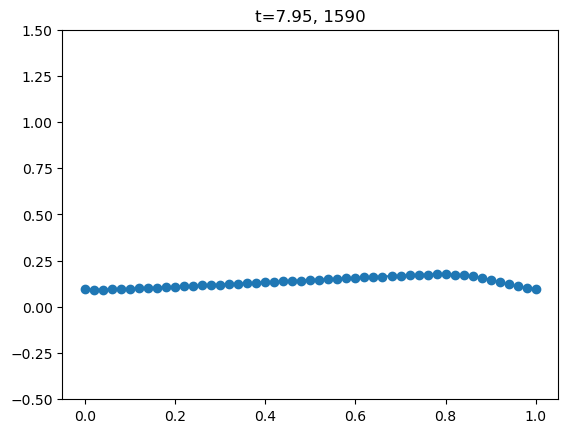

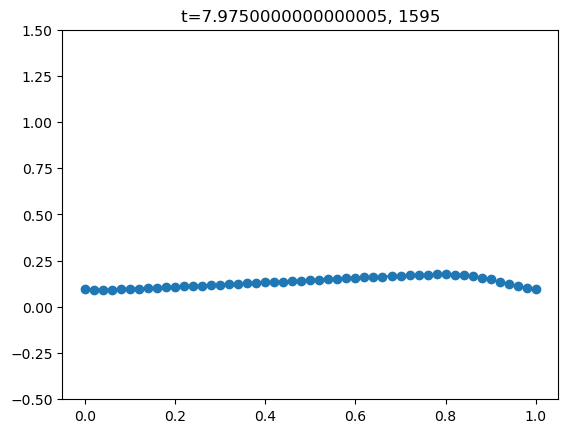

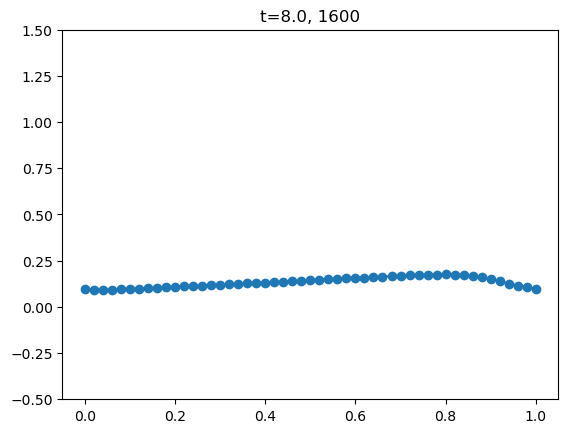

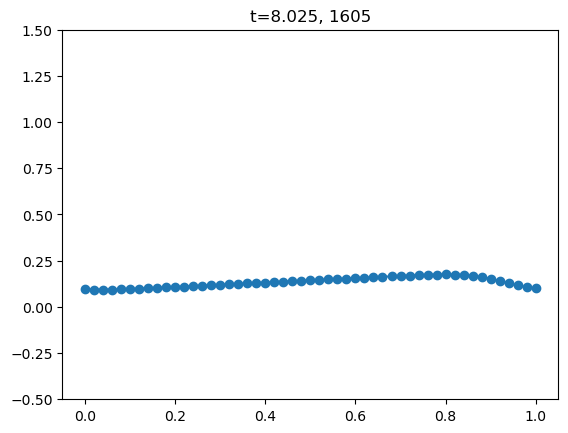

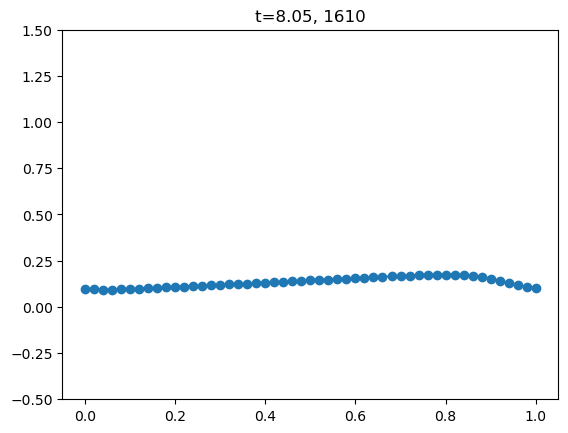

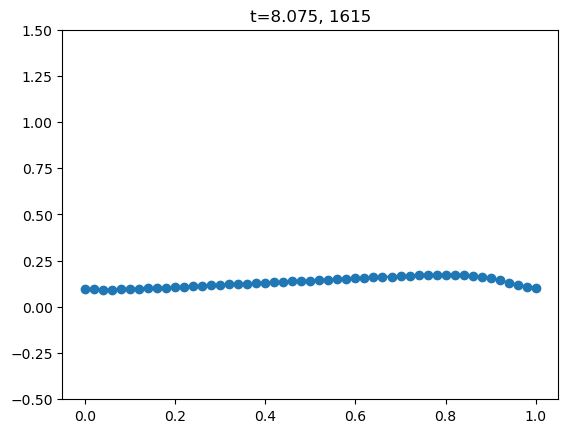

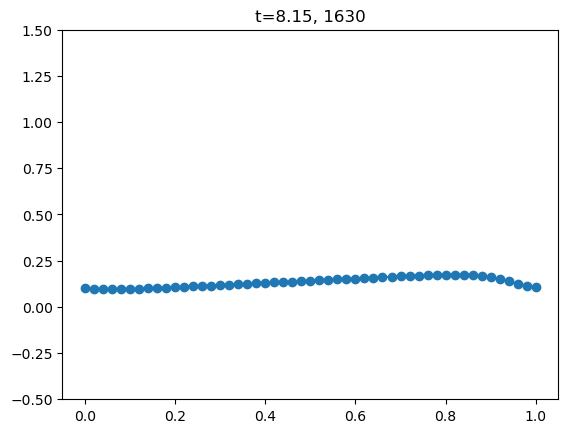

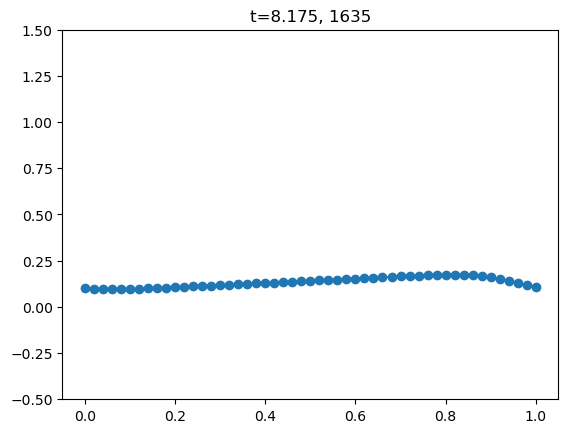

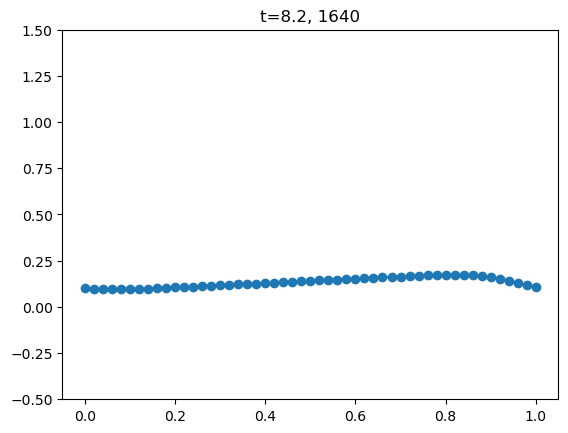

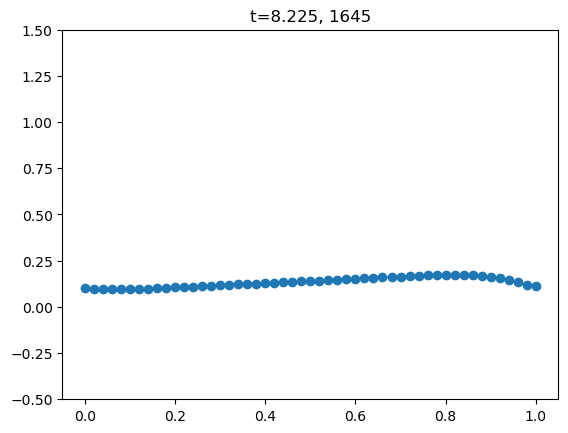

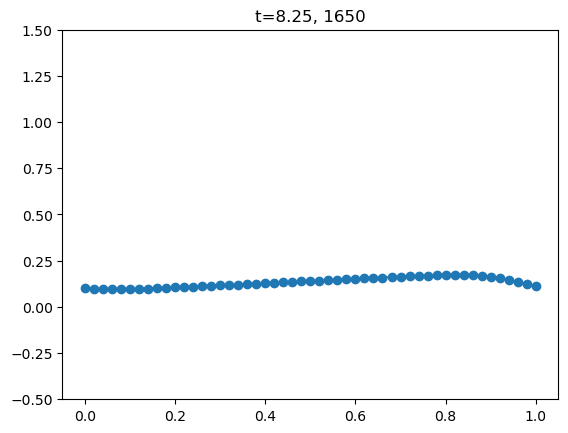

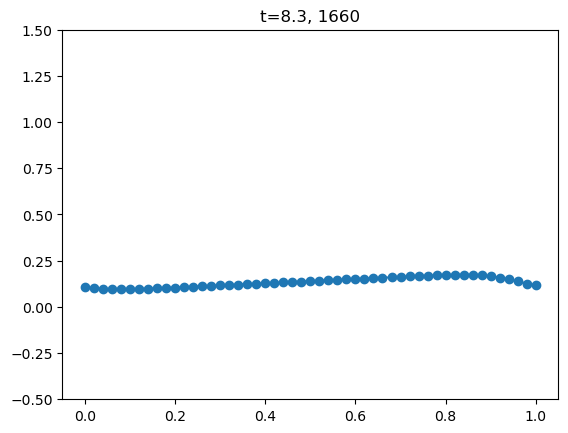

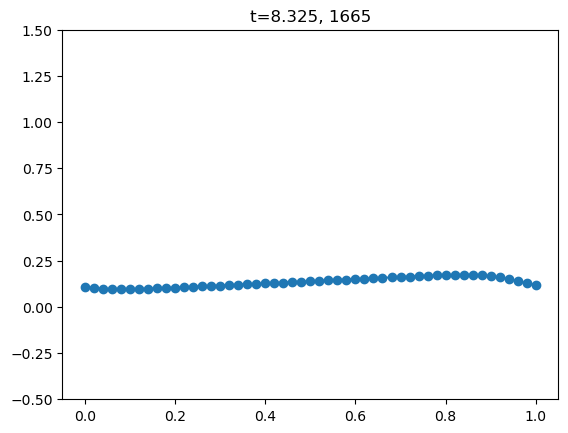

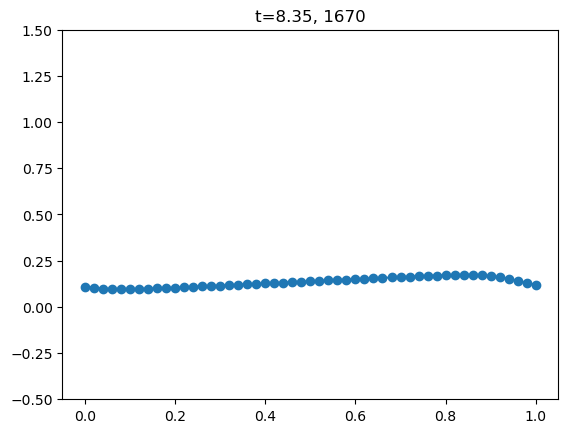

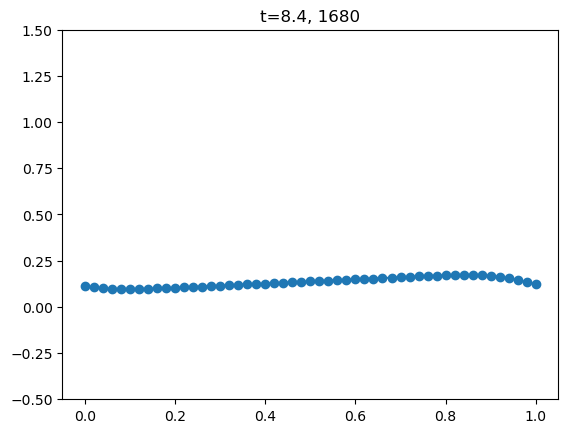

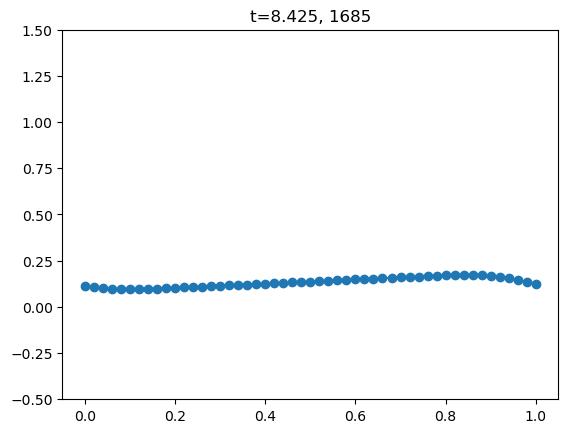

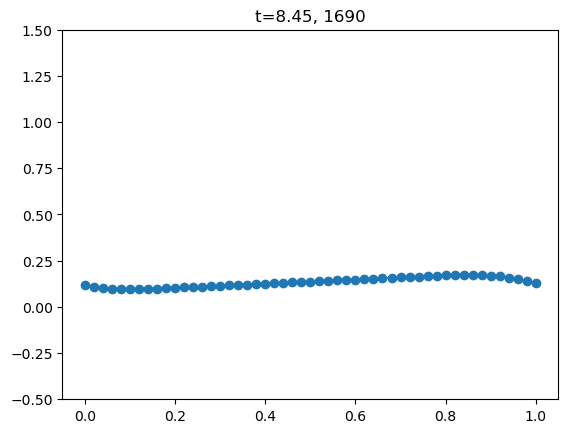

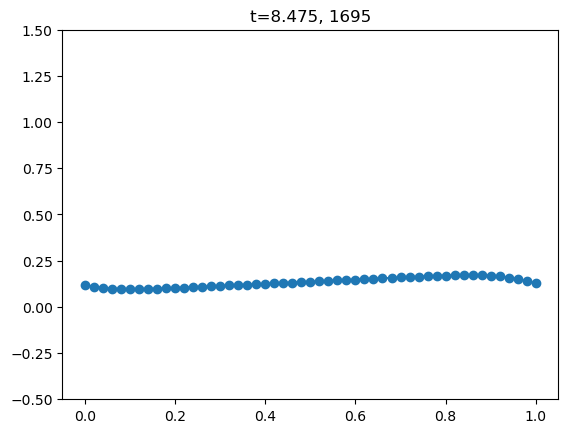

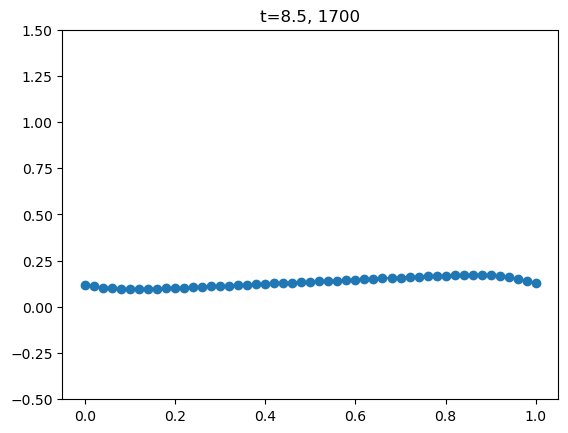

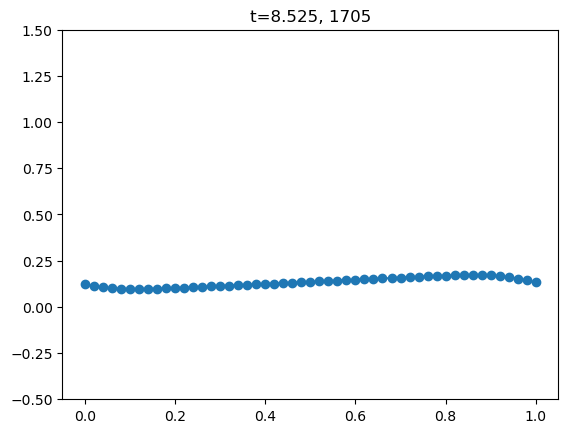

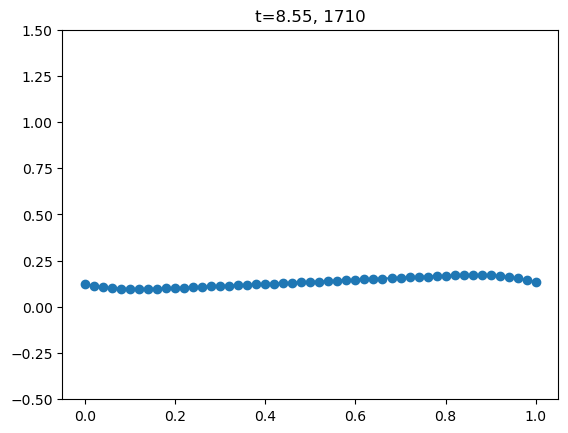

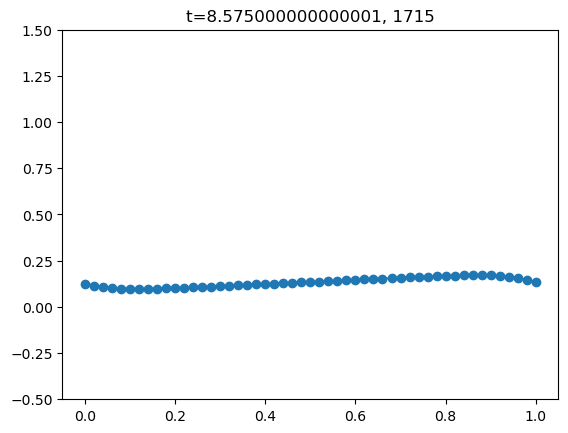

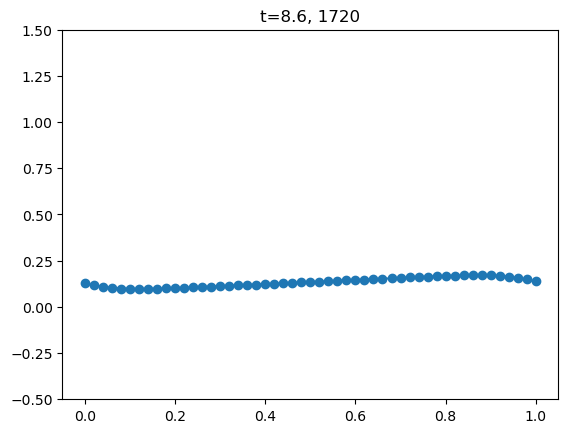

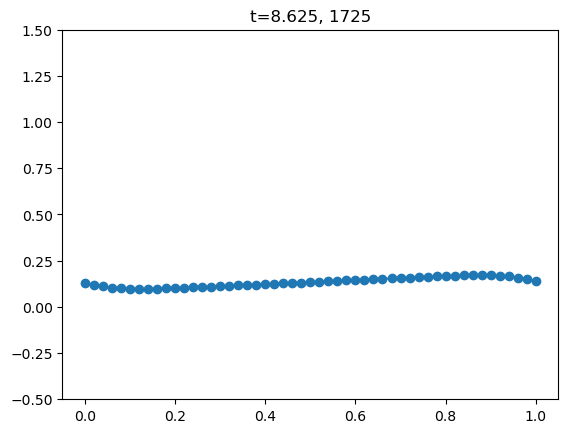

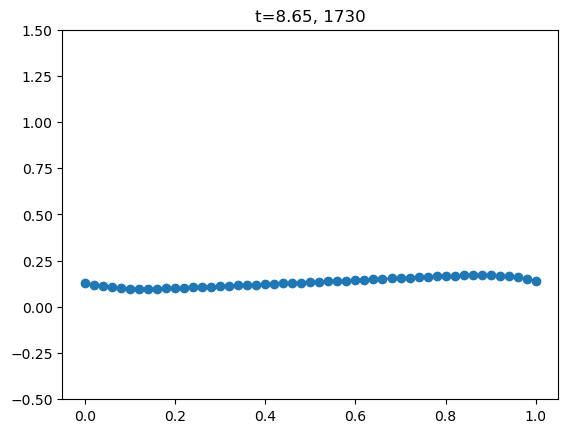

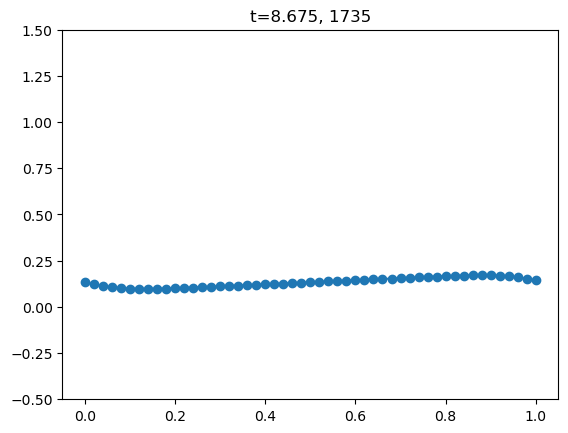

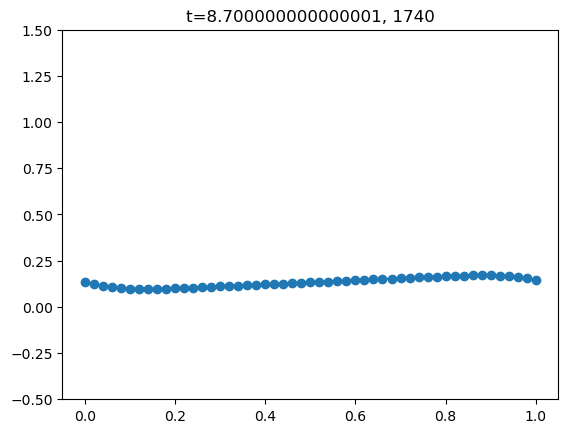

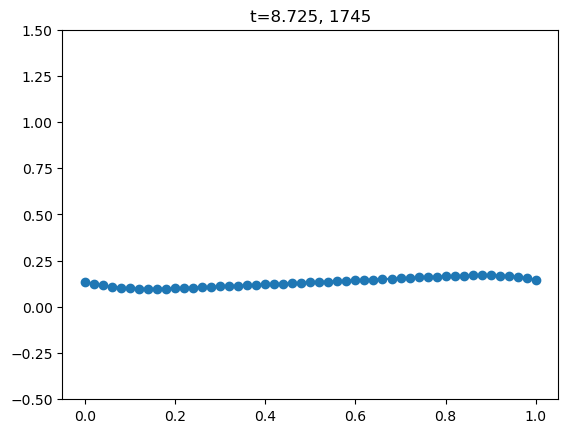

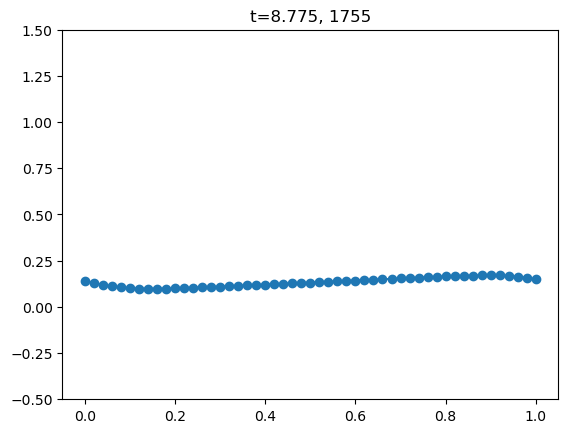

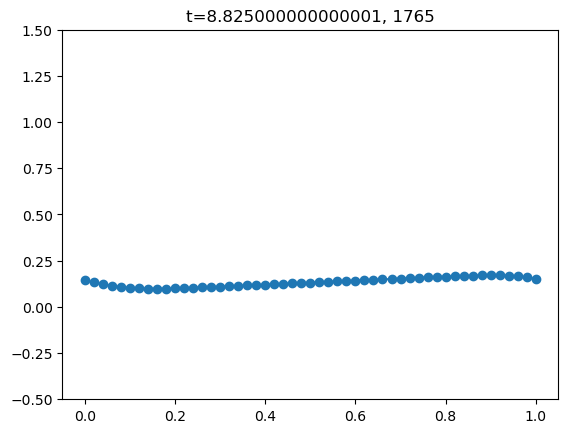

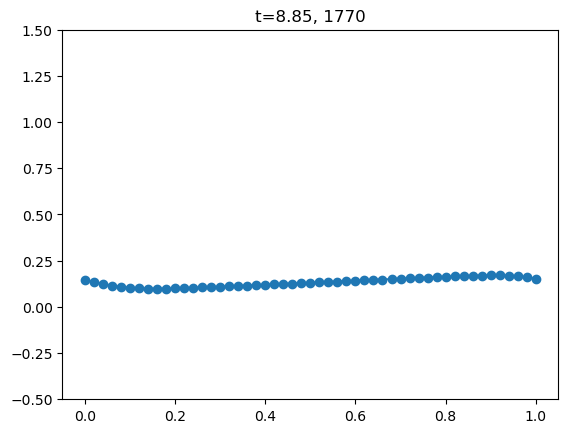

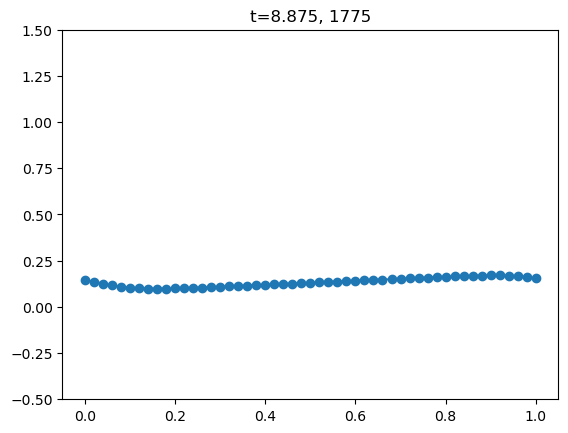

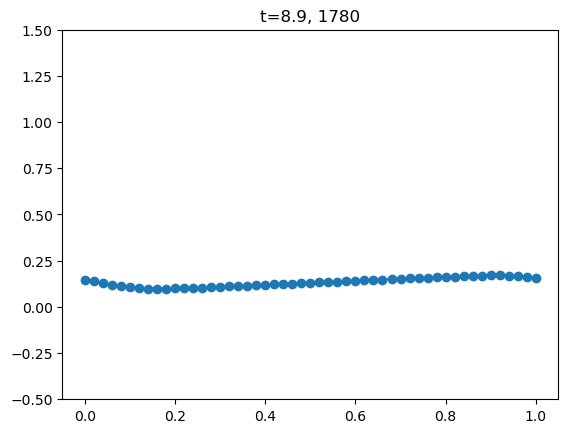

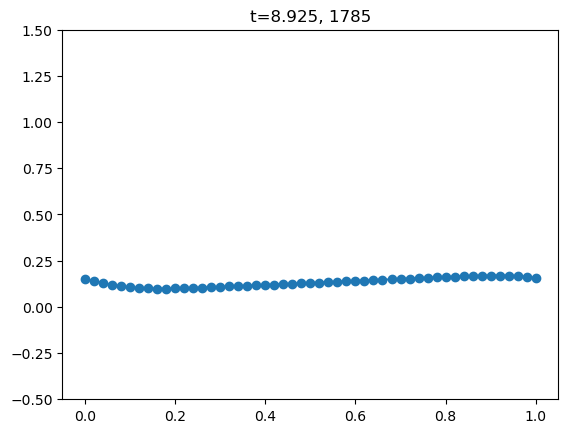

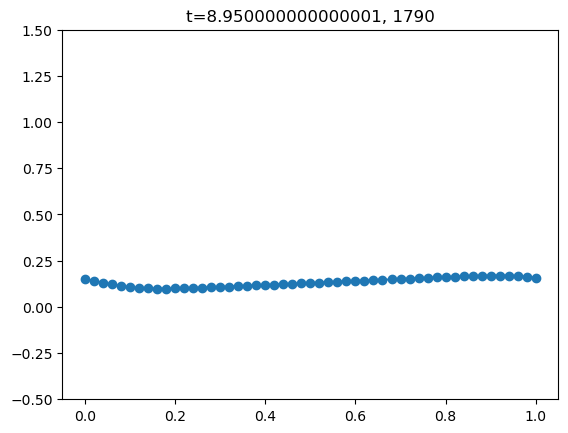

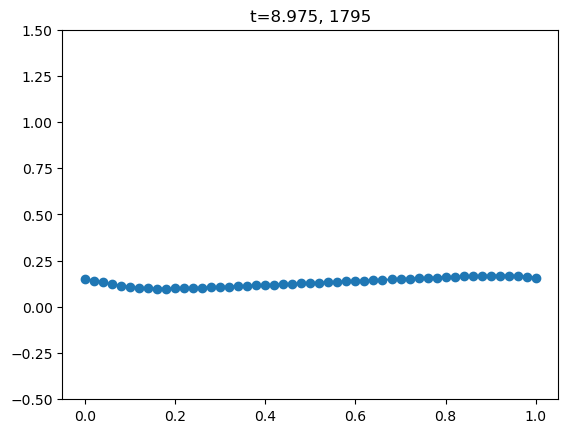

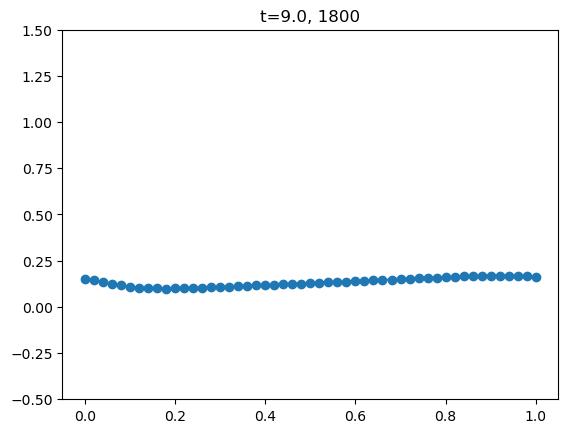

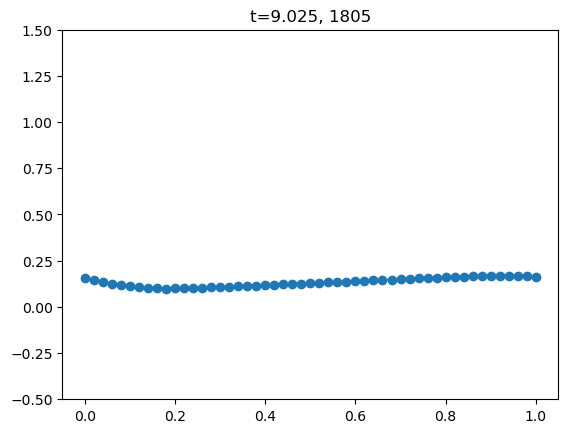

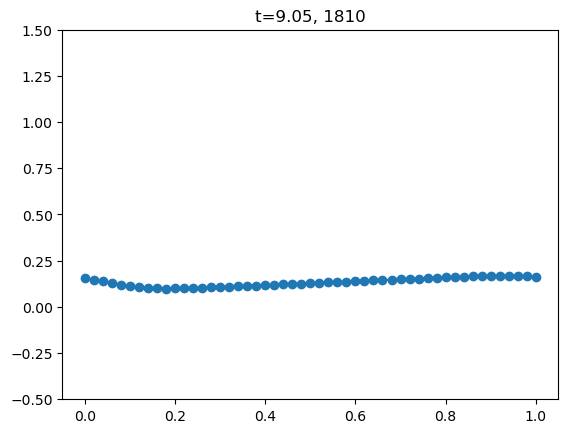

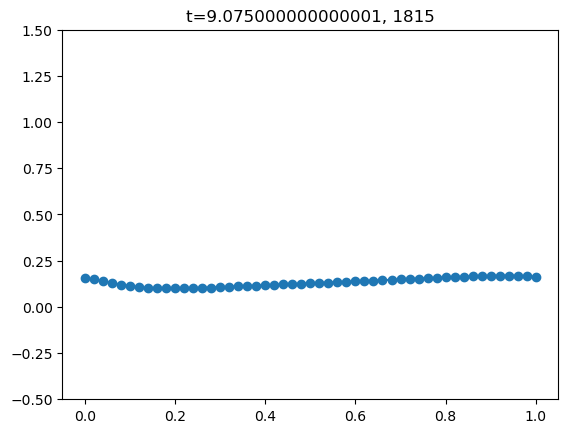

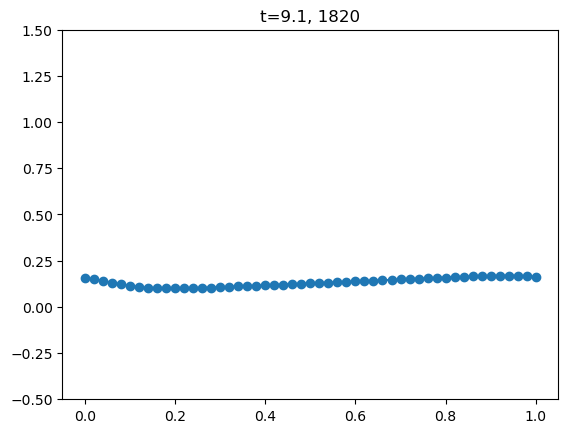

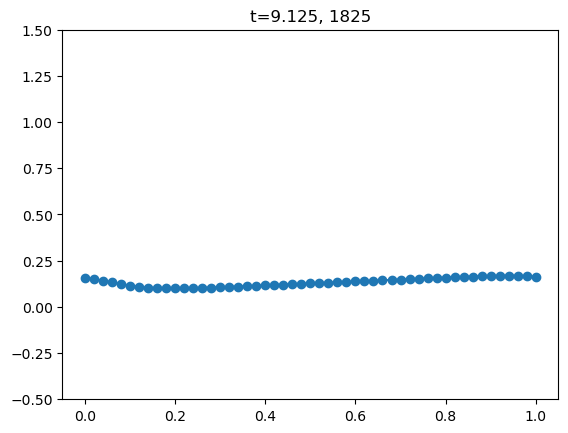

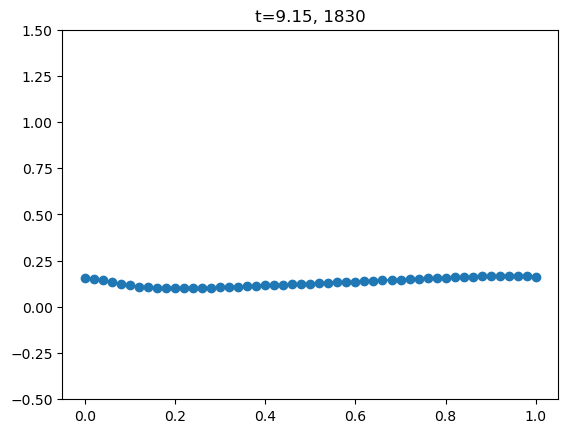

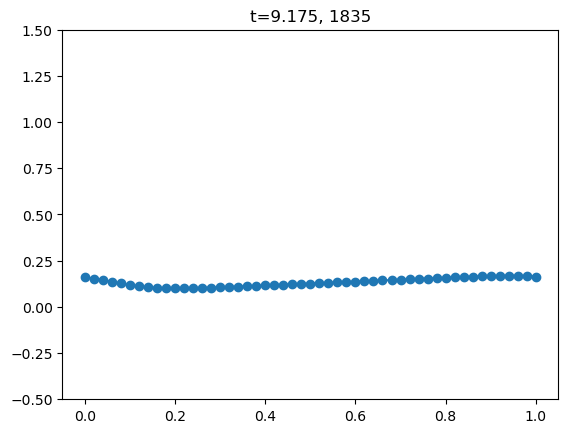

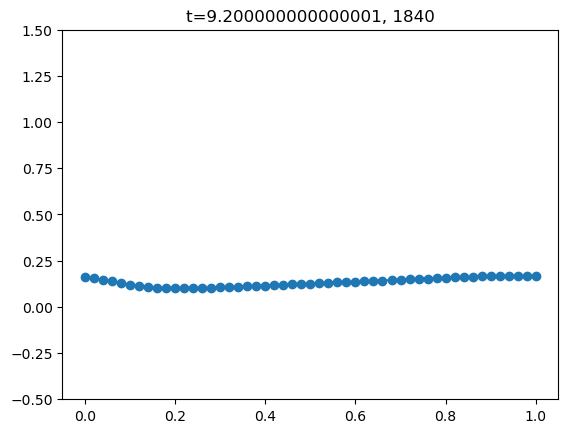

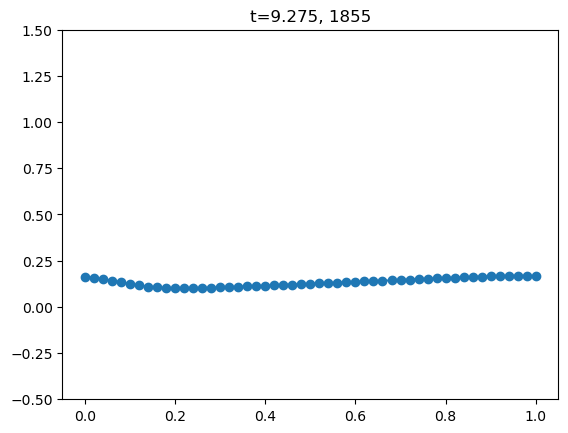

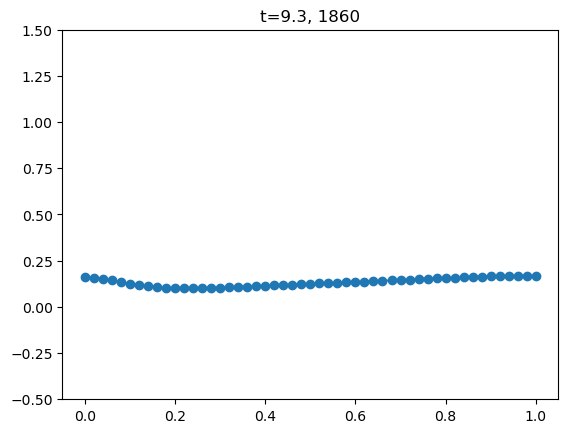

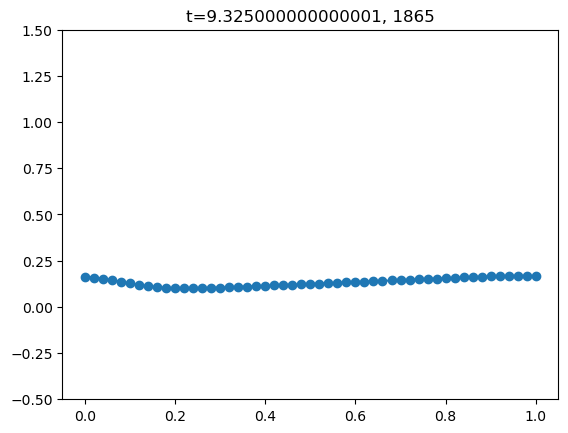

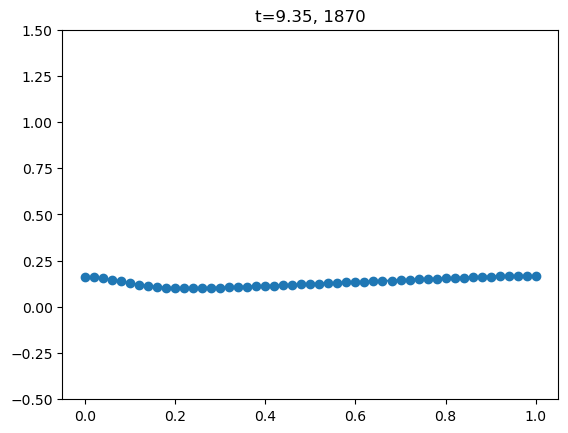

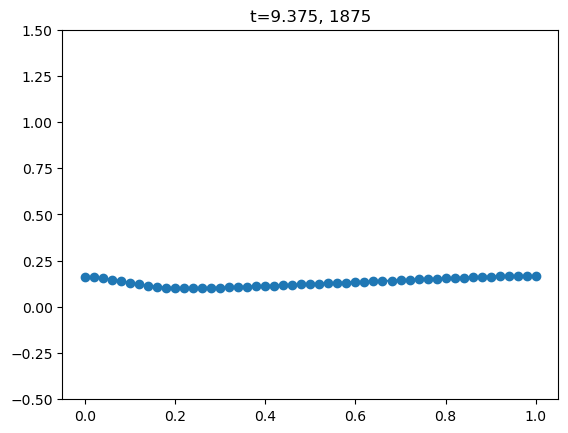

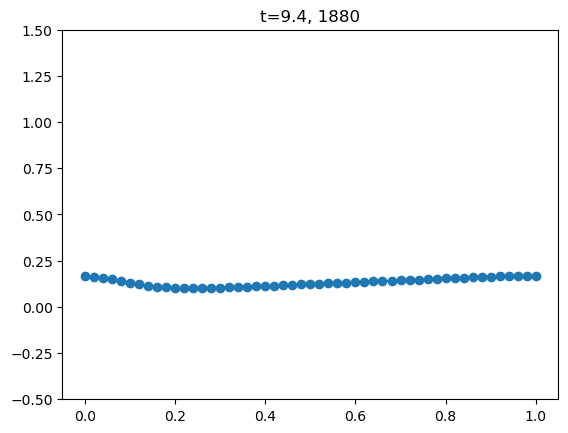

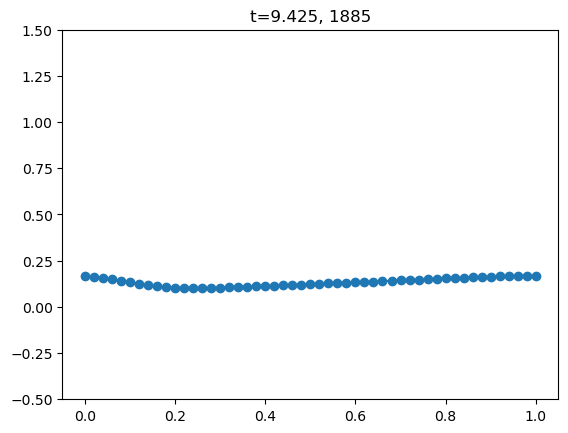

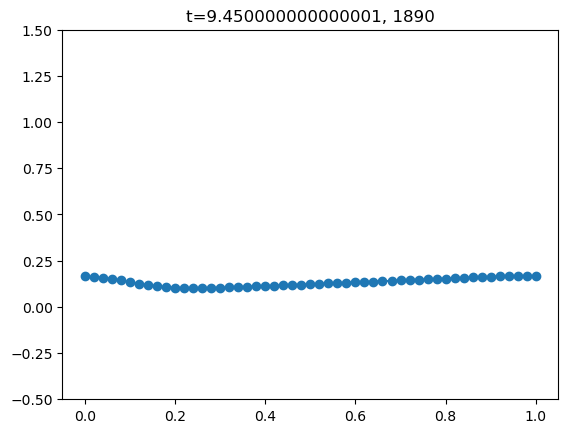

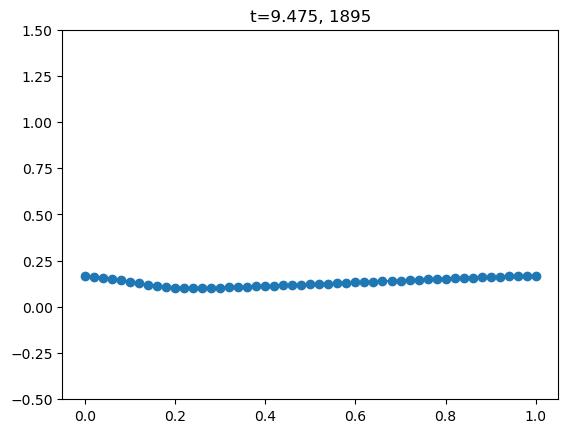

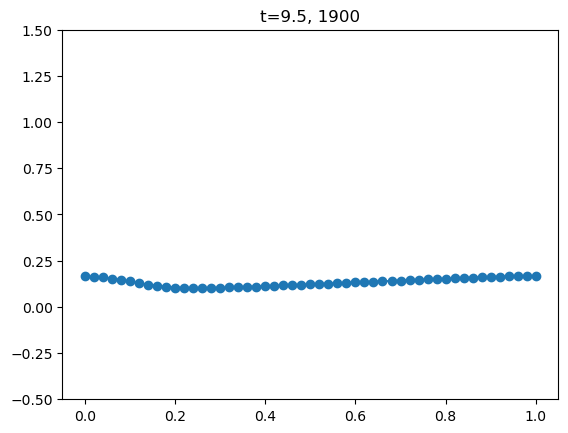

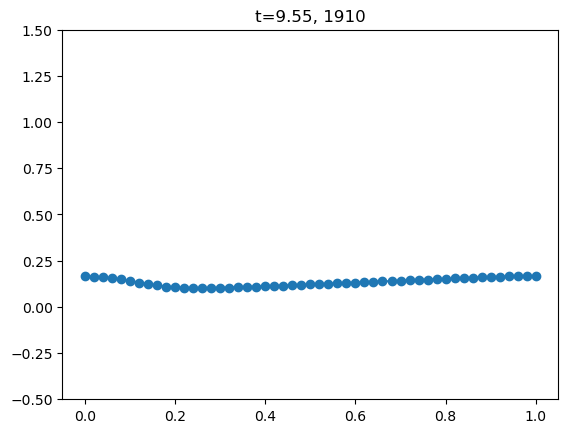

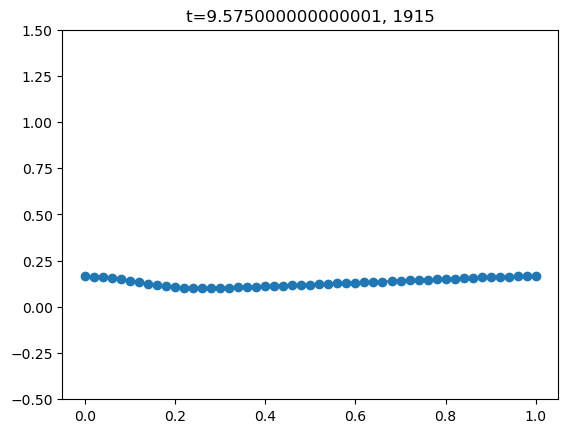

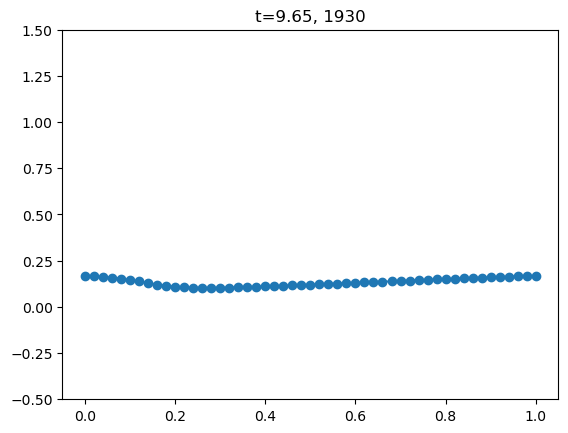

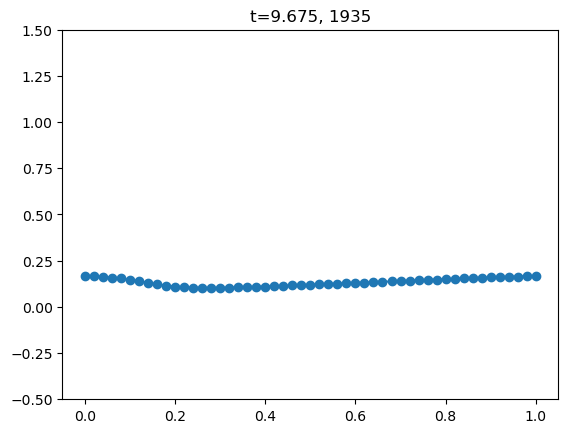

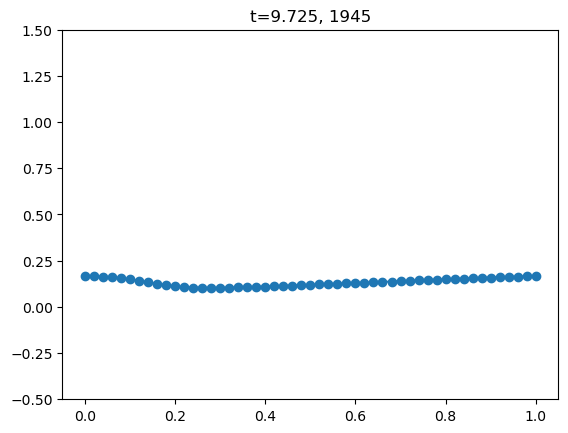

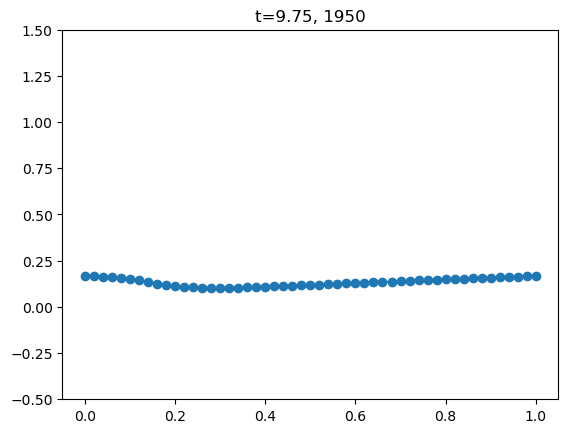

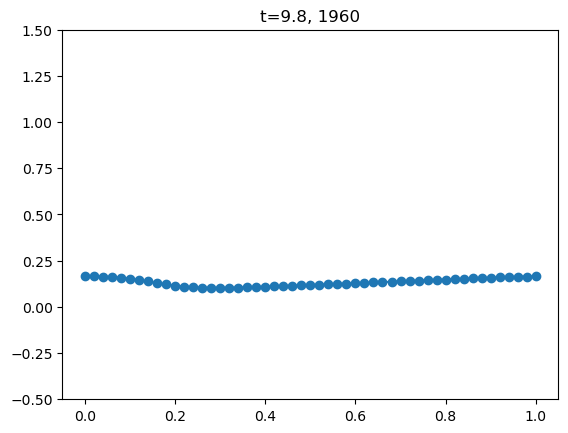

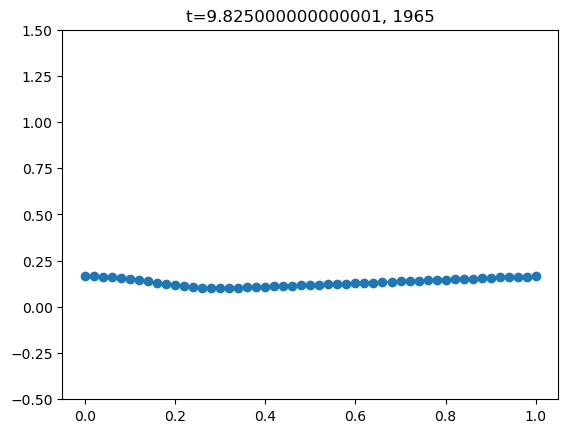

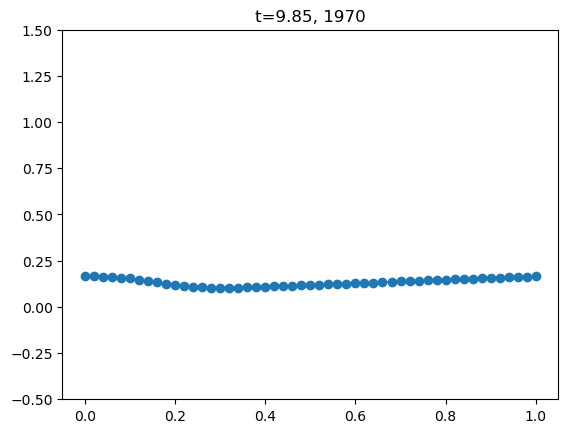

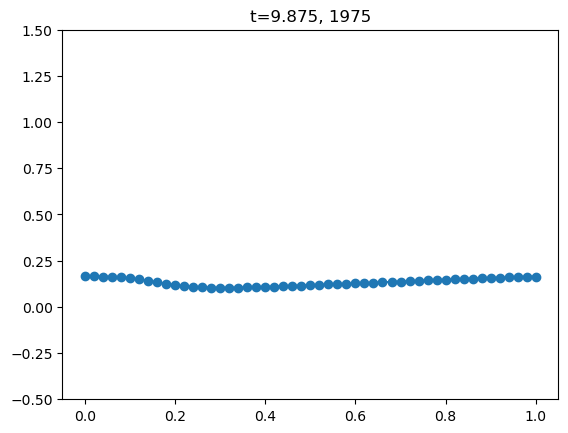

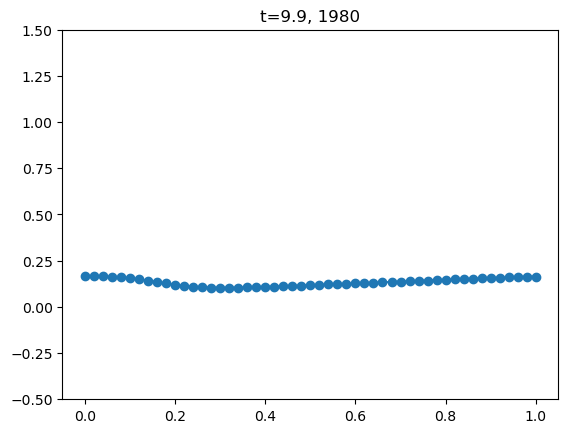

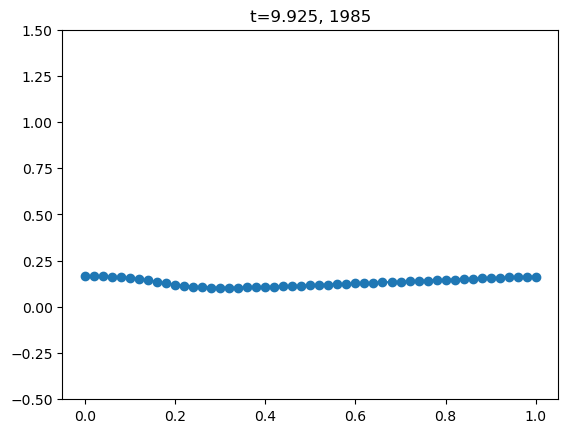

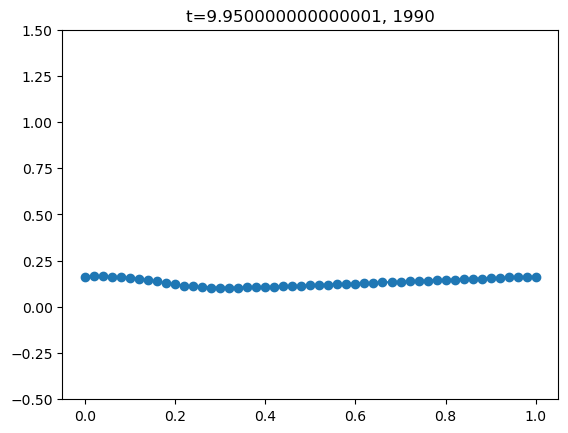

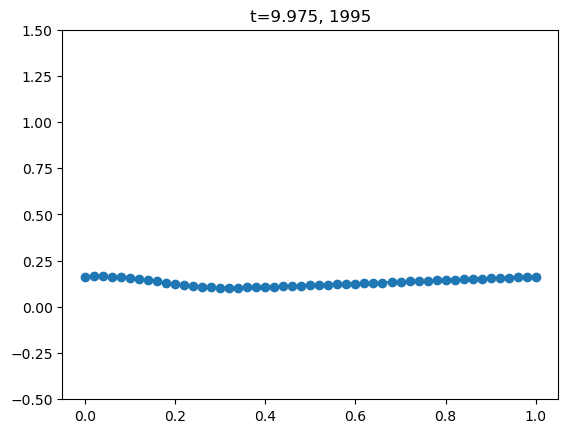

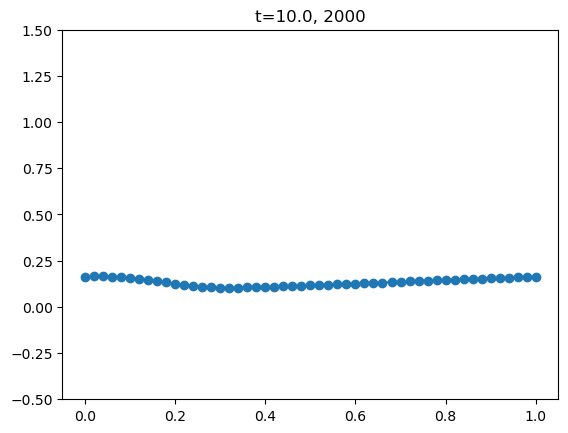

In [34]:
@time main(para)

In [ ]:
nu = 0.5/(0.1/0.02^2)